In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [12]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
xm_sol  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [3]:
################
### LMC Data ###
################

### GCs
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### PARSEC
parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

### GC cluster tables
'''
The ACS survey of Galactic globular clusters – XIV. Bayesian single-population analysis of 69 globular clusters
Wagner-Kaiser et al. 2017
'''
import pandas as pd
supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
                    names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
                           'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
                           'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
                           'RelativeAge'],sep='\s+')

In [4]:
ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #omegaCen: NGC5139
    elif (gcs['Cluster'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

In [5]:
apogee_clus_idx = []
apogee_clus_idx2 = []

for i in supp2['Cluster'][s2_ind]:
    apogee_clus_idx.append(np.where(ngc_names==i))
    apogee_clus_idx2.append(np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))]==i))
    

In [6]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [8]:
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

gcs_ksmag = absmag(gcs['K'],gcs['distmed'])

In [9]:
### Inital Interpolator setup
from photutils.utils import ShepardIDWInterpolator as idw

val_arr = np.array([parsec['logTe'],parsec['Kmag'],np.log10(parsec['Z']/0.02),parsec['logg']]).T
interpol = idw(val_arr,parsec['logAge'],weights=np.reciprocal(parsec['logAge']))

In [17]:
age_distrs = []

for i in tqdm_notebook(range(len(gcs)),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = gcs['distmed'][i]
    dist_err = gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noisy = []
    distr = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        dist_new = add_noise(dist,dist_err)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = xm_sol[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = xm_sol[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(xm_sol[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        noisy.append(interpol(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new])))
    
    age_distrs.append(noisy)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_distrs))):
    devs.append(afunc.mad(age_distrs[k]))
    parages.append(np.median(age_distrs[k]))
    
parages = np.asarray(parages)
devs = np.asarray(devs)

In [83]:
np.where(ngc_names=='NGC4147')

(array([366]),)

In [84]:
np.median(4.0)

4.0

In [96]:
np.asarray(supp2['Age'][s2_ind])

array([10.  , 10.9 , 12.  , 12.75, 13.  , 13.25, 13.5 , 12.  , 12.5 ,
       13.  , 12.25, 12.5 , 13.5 , 12.75, 13.  , 13.25, 13.  , 12.75,
       12.  , 13.5 , 11.3 , 12.  , 12.  , 12.75, 12.5 , 13.5 , 12.5 ,
       13.25, 12.5 ])

In [99]:
clus_ages = [-9999.0,-9999.0,14.46,13.06,10.62,10.37,10.24,-9999.0,-9999.0,-9999.0,10.24,-9999.0,-9999.0,12.54,
             12.67,12.29,11.52,11.39,12.54,13.57,10.62,12.67,12.16,12.54,12.54,12.52,13.82,13.95,11.65,12.67,
             11.39,13.57,13.18,12.67,13.57,13.31,12.03,12.67,12.9,11.26,12.42,10.50,12.93,11.26,12.54,13.06,12.93,
             12.67,12.80,-9999.0,13.18,13.06,11.78,13.70,12.29,13.70,11.14,10.88,-9999.0,12.93,11.78,12.93,
             -9999.0,-9999.0,9.8,-9999.0,-9999.0,-9999.0,-9999.0]

for i in range(len(supp2)):
    print('{} {} {}'.format(np.asarray(supp2['Cluster'])[i],clus_ages[i],np.asarray(supp2['Age'])[i]))

Arp2 -9999.0 13.0
IC4499 -9999.0 12.0
Lynga7 14.46 12.5
NGC0104 13.06 12.75
NGC0288 10.62 12.5
NGC0362 10.37 11.5
NGC1261 10.24 11.5
NGC1851 -9999.0 10.0
NGC2298 -9999.0 13.0
NGC2808 -9999.0 10.9
NGC3201 10.24 12.0
NGC4147 -9999.0 12.75
NGC4590 -9999.0 13.0
NGC4833 12.54 13.0
NGC5024 12.67 13.25
NGC5053 12.29 13.5
NGC5139 11.52 12.0
NGC5272 11.39 12.5
NGC5286 12.54 13.0
NGC5466 13.57 13.0
NGC5904 10.62 12.25
NGC5927 12.67 12.25
NGC5986 12.16 13.25
NGC6093 12.54 13.5
NGC6101 12.54 13.0
NGC6121 12.52 12.5
NGC6144 13.82 13.5
NGC6171 13.95 12.75
NGC6205 11.65 13.0
NGC6218 12.67 13.25
NGC6254 11.39 13.0
NGC6304 13.57 12.75
NGC6341 13.18 13.25
NGC6352 12.67 13.0
NGC6362 13.57 12.5
NGC6366 13.31 12.0
NGC6388 12.03 12.0
NGC6397 12.67 13.5
NGC6426 12.9 13.0
NGC6441 11.26 11.3
NGC6496 12.42 12.0
NGC6535 10.5 13.25
NGC6541 12.93 13.25
NGC6584 11.26 12.25
NGC6624 12.54 13.0
NGC6637 13.06 12.5
NGC6652 12.93 13.25
NGC6656 12.67 12.0
NGC6681 12.8 13.0
NGC6715 -9999.0 12.0
NGC6717 13.18 13.0
NGC6723 1

In [86]:
supp2.columns

Index(['Cluster', 'Dist', 'Dist_Sigma', 'Av', 'Av_Sigma', '[Fe/H]', 'Age'], dtype='object')

In [87]:
xmatch_age = np.array([9.2,11.2,11.1,14,12.7,12.7,12.3,11.52,11.4,13.6,11.5,13.1,13.4,10.98,11.7,13.4,12.4,12.3,
                       11.7,13.4,13.7,12.7,10.8,13.06,13.8,13.8,12.7,13.6,11.8])
log_xmatch_age = np.log10(xmatch_age*10**9)

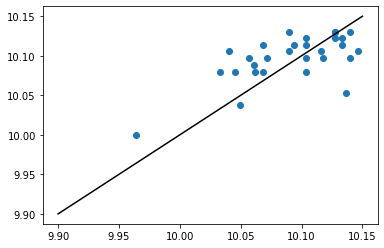

In [88]:
plt.scatter(log_xmatch_age,np.log10(np.asarray(supp2['Age']*10**9)[s2_ind]))
plt.plot([9.9,10.15],[9.9,10.15],c='k')

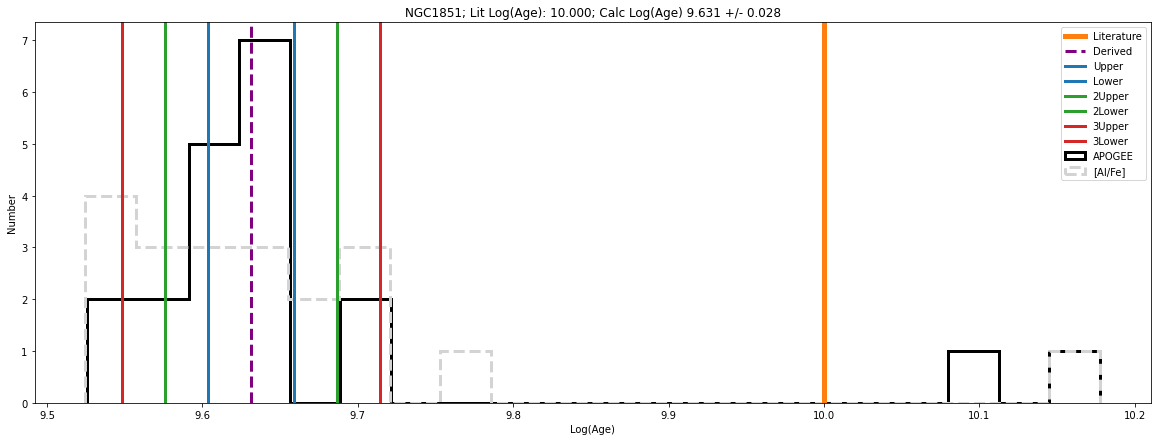

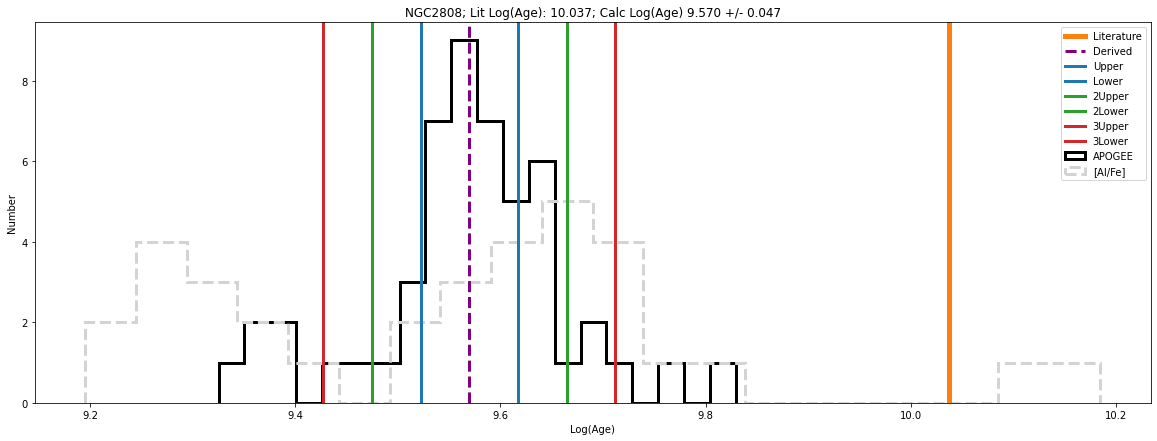

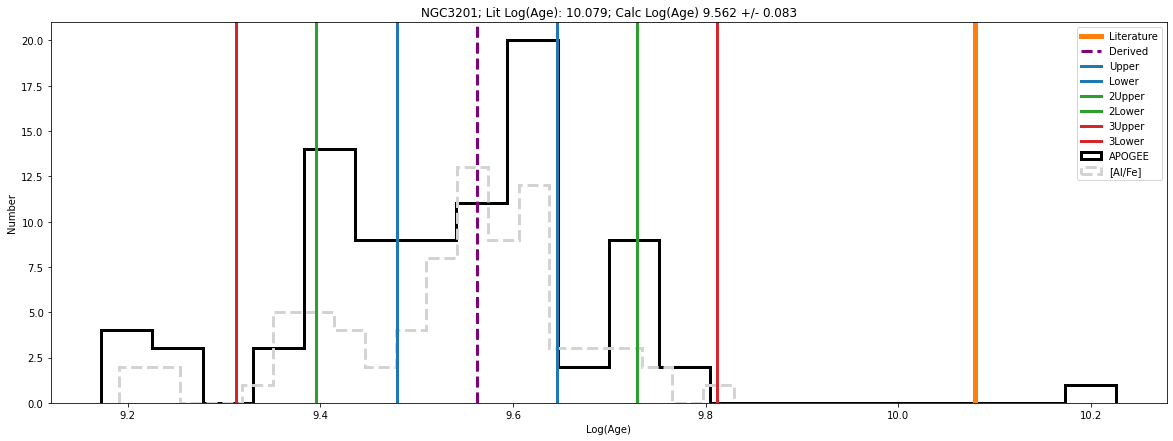

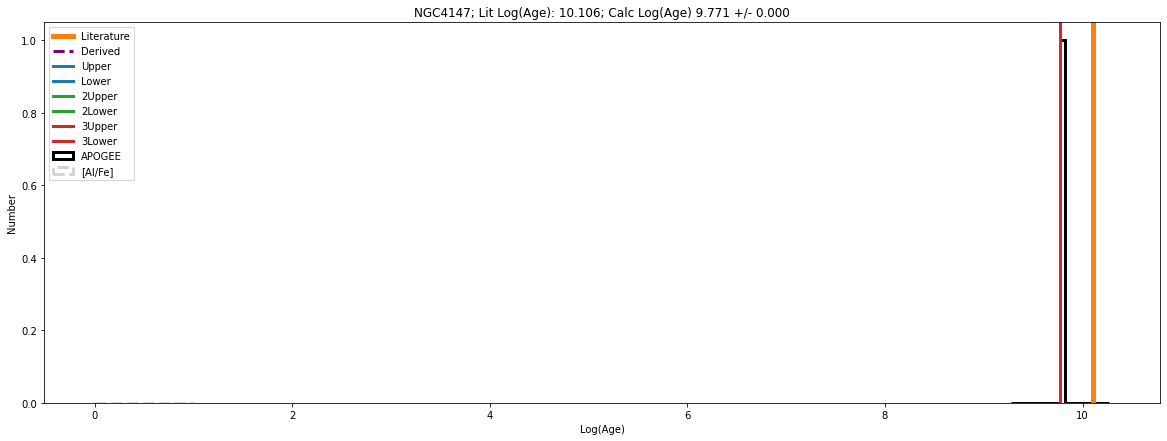

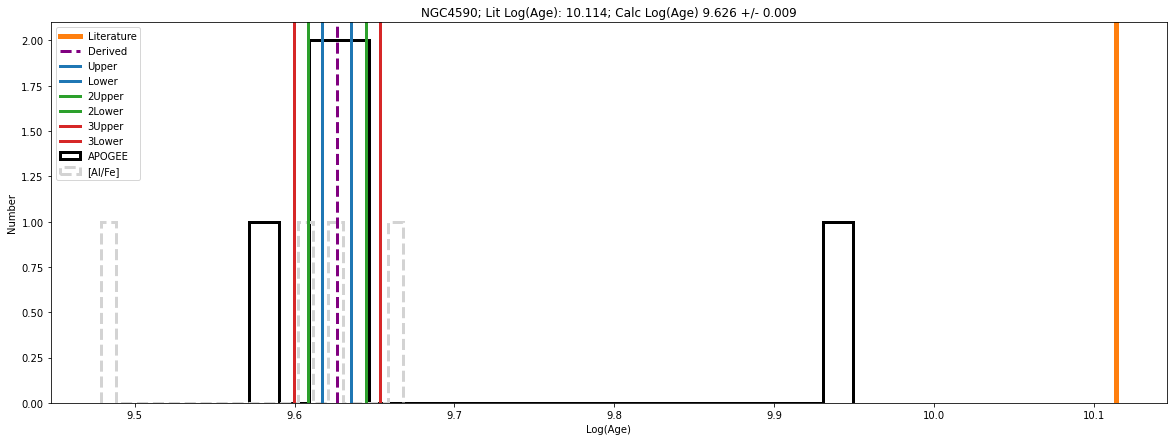

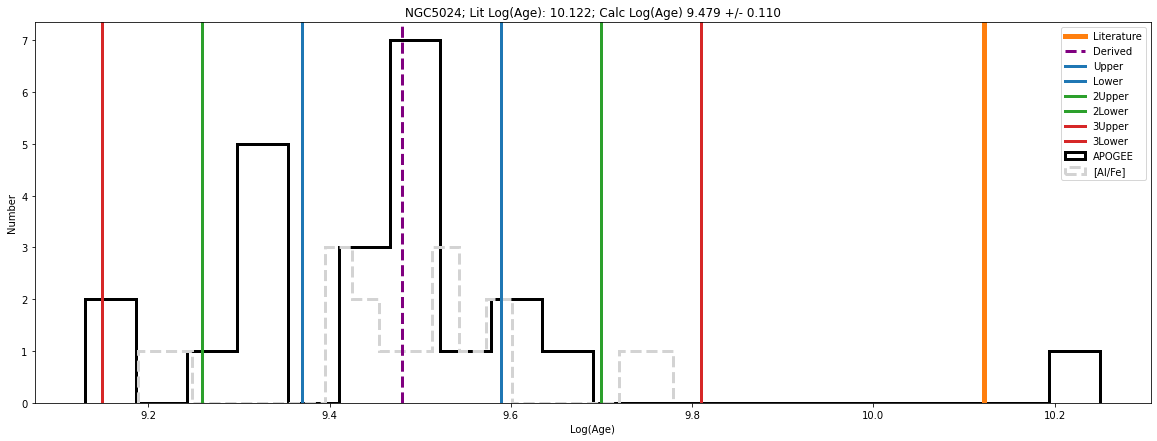

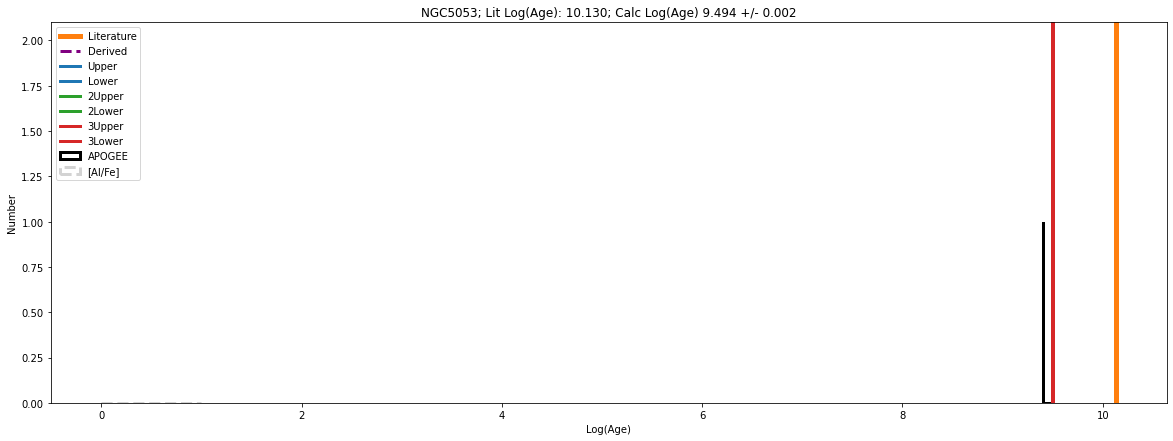

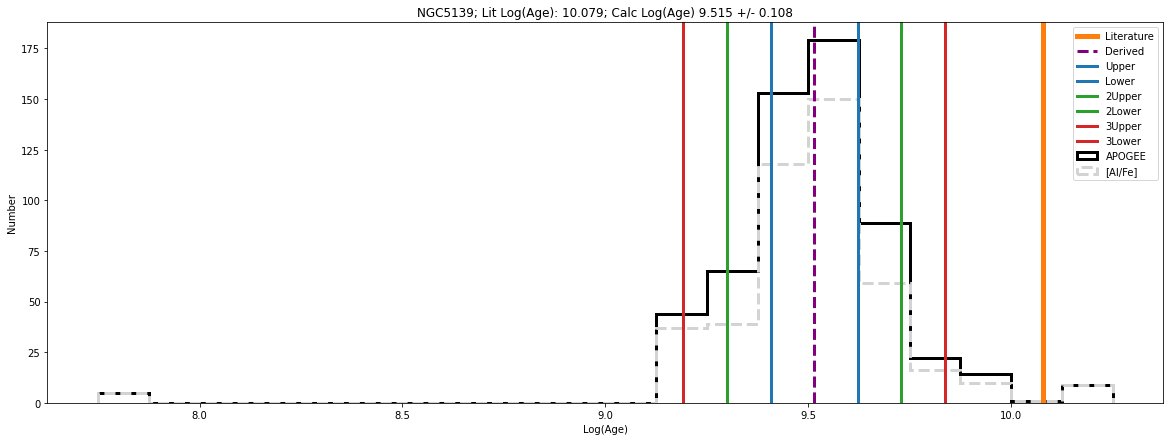

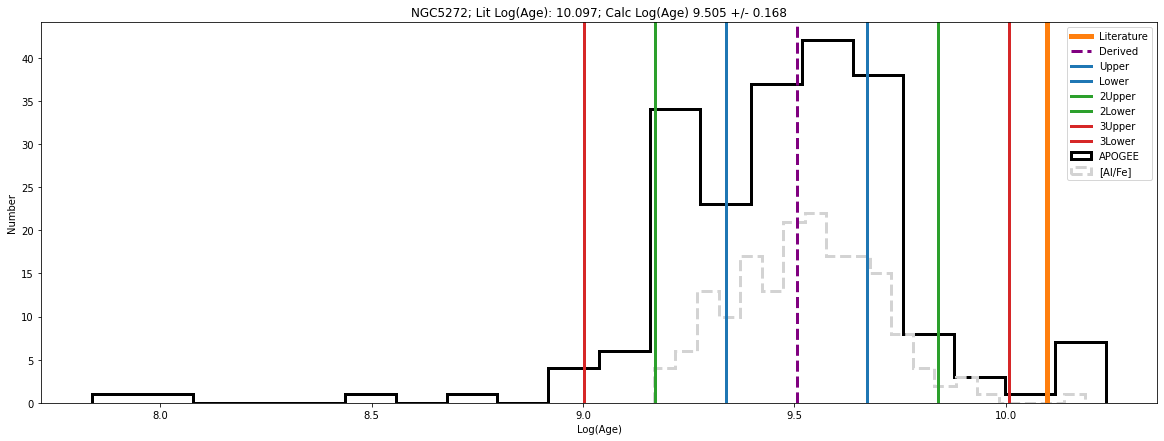

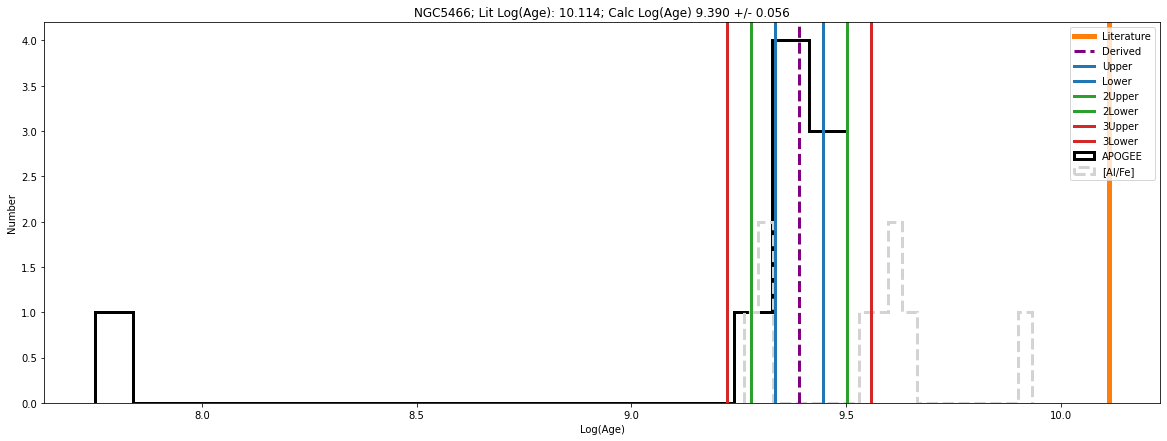

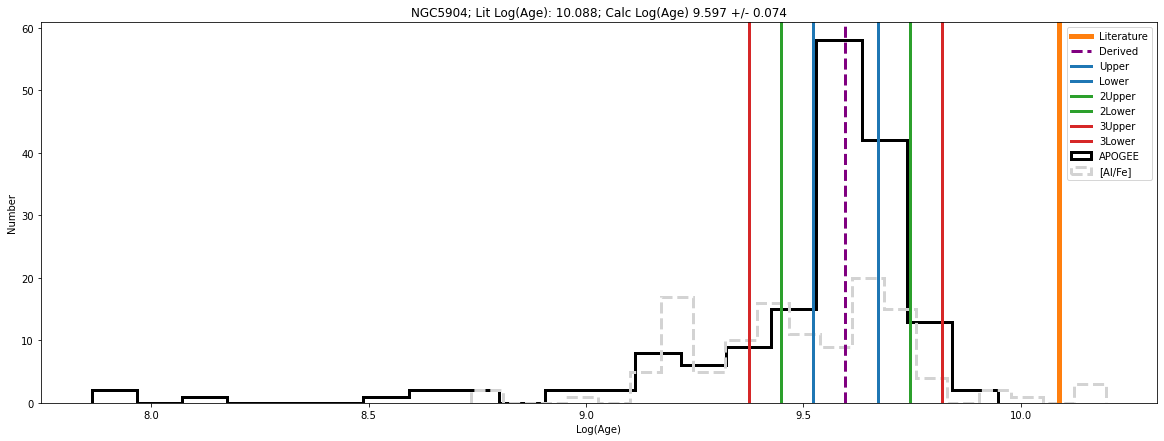

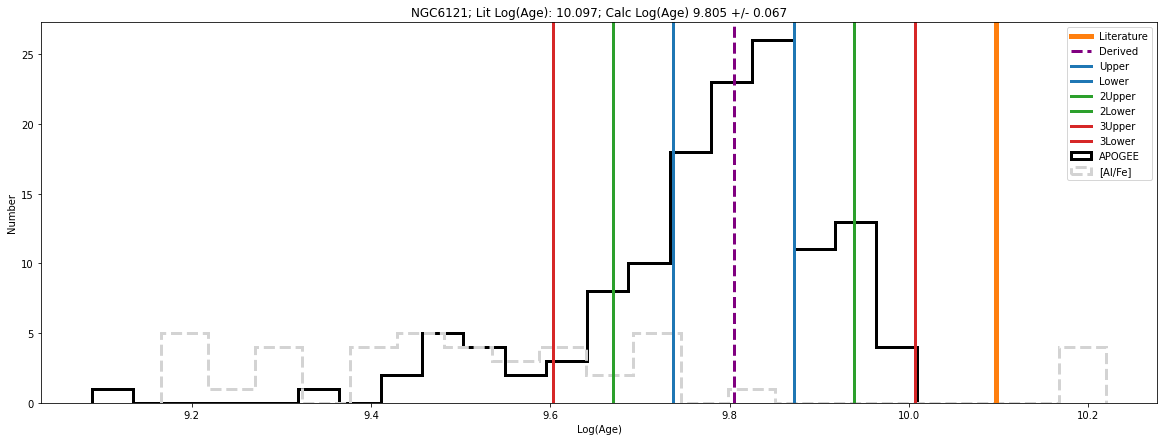

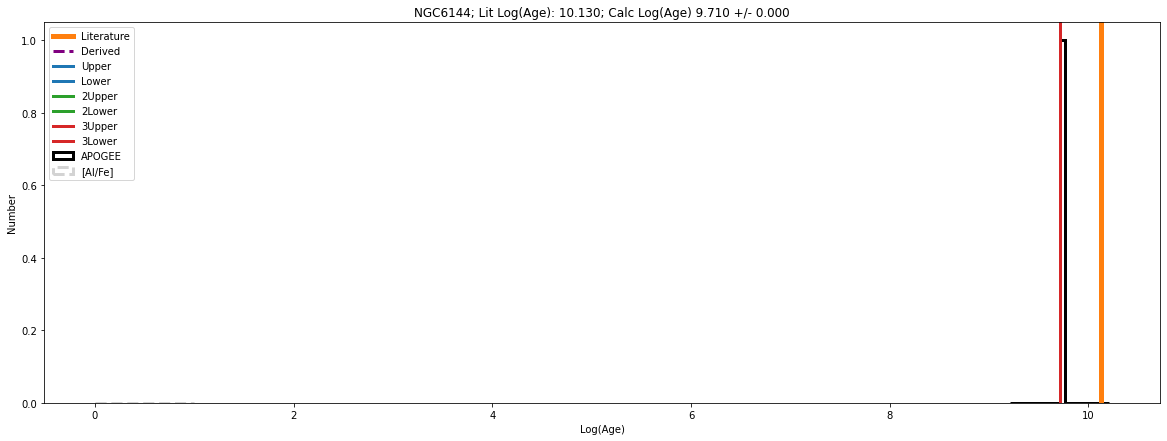

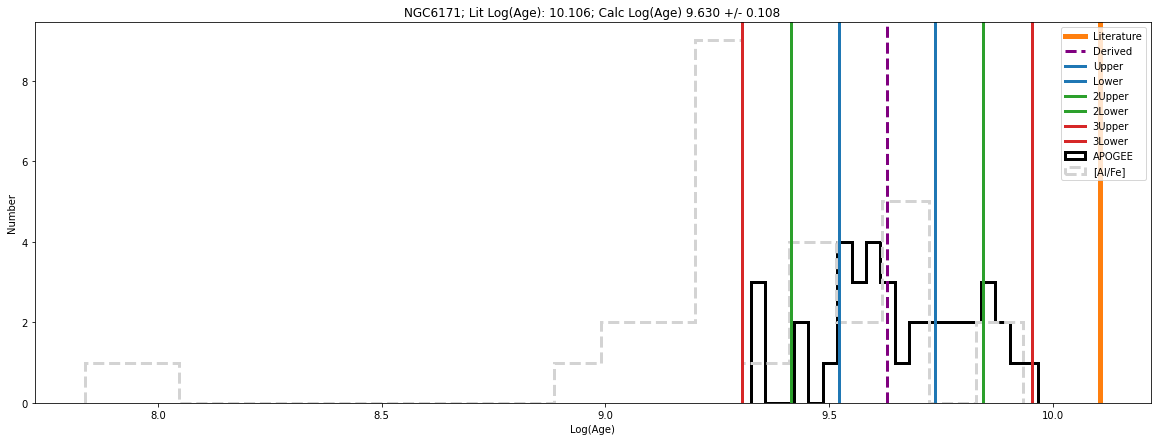

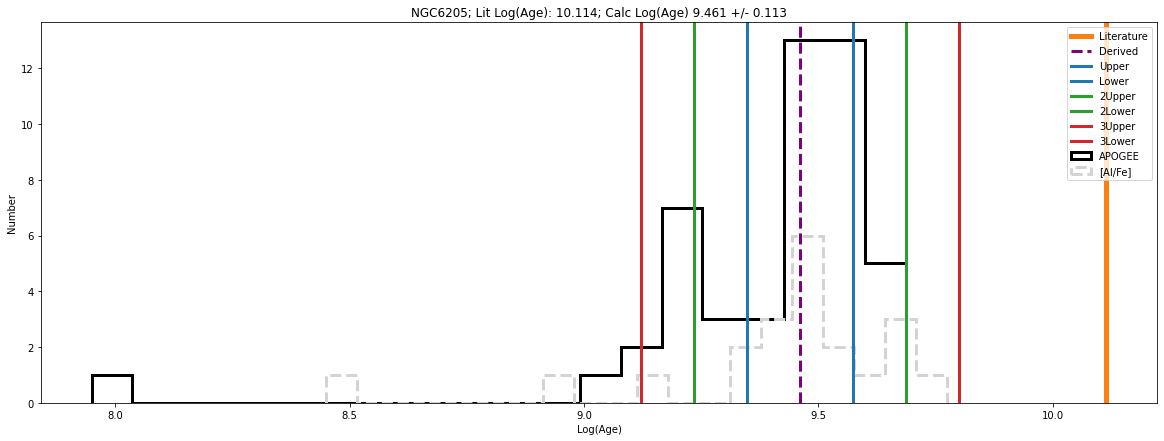

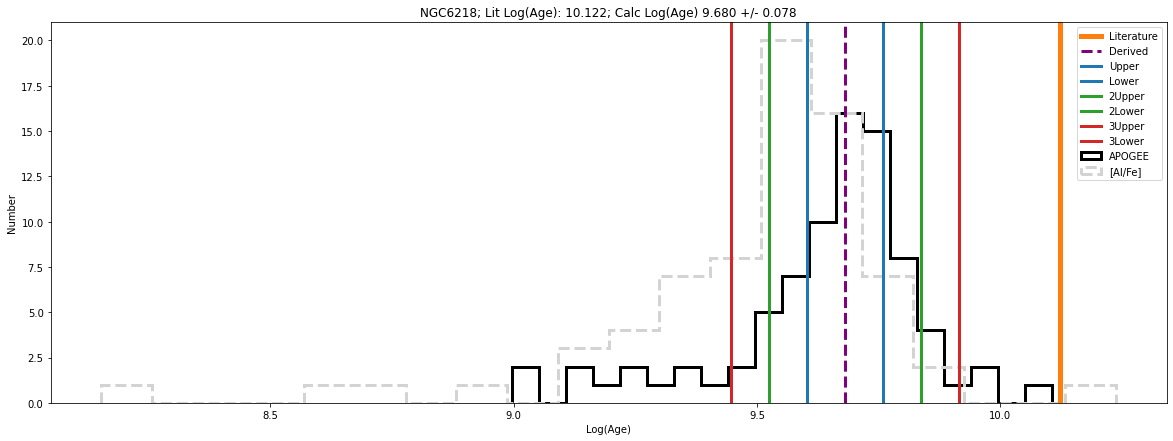

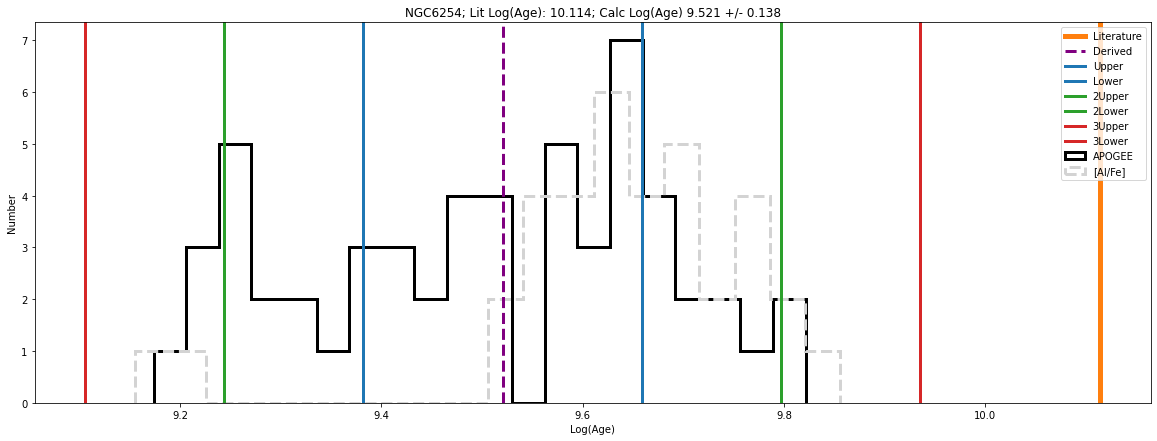

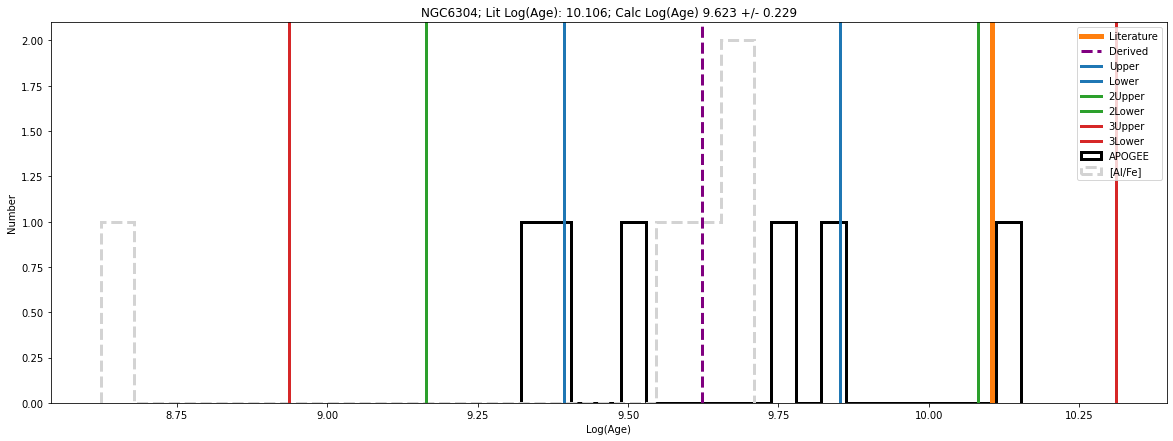

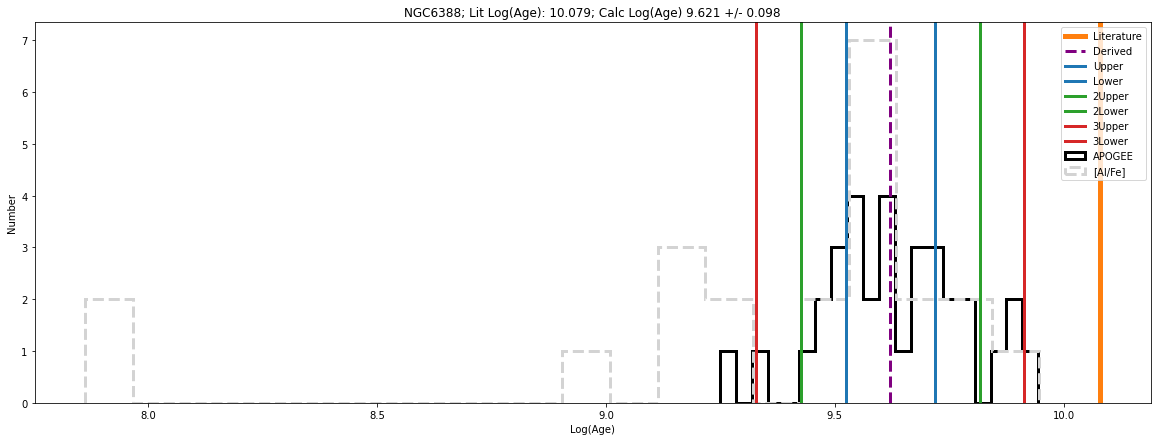

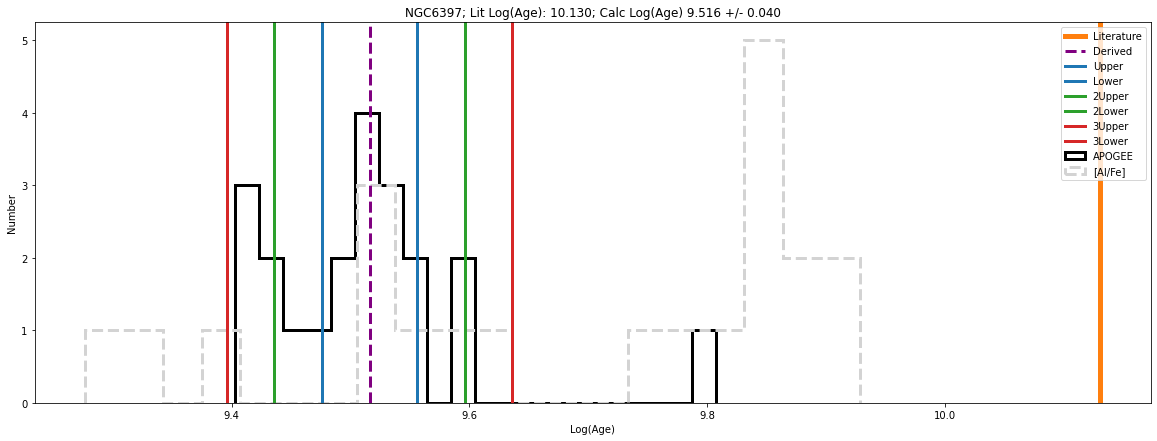

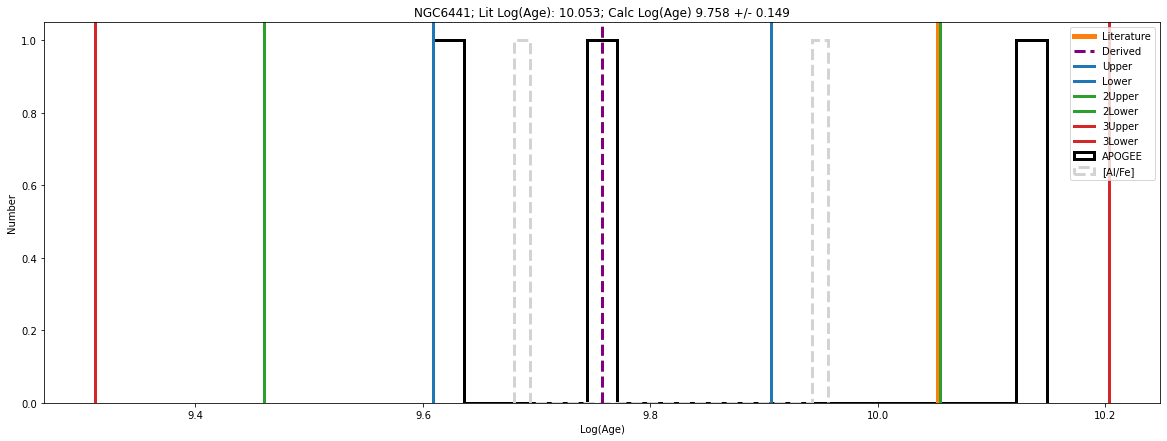

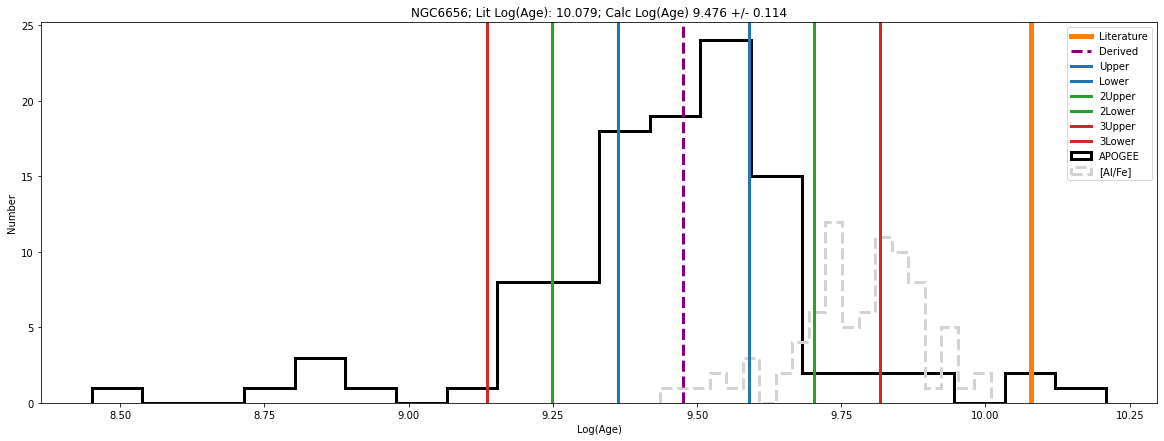

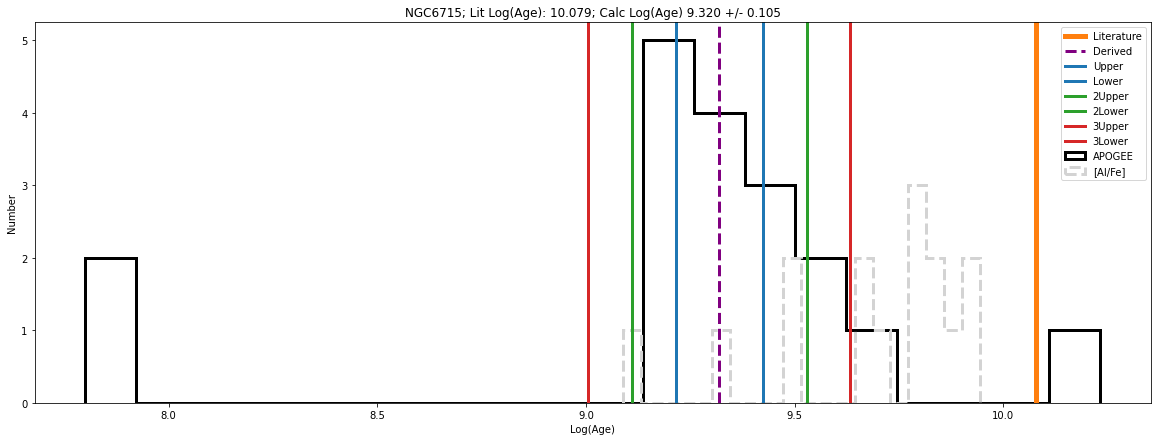

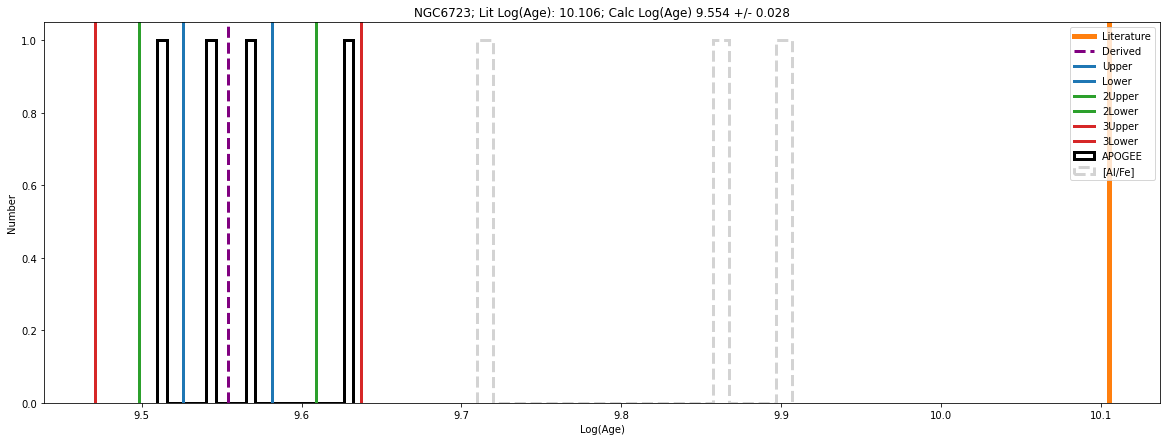

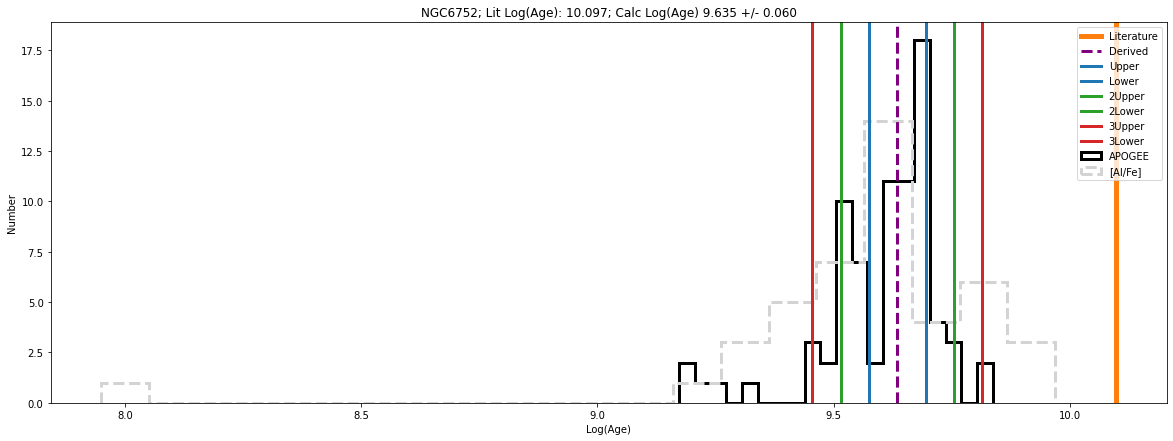

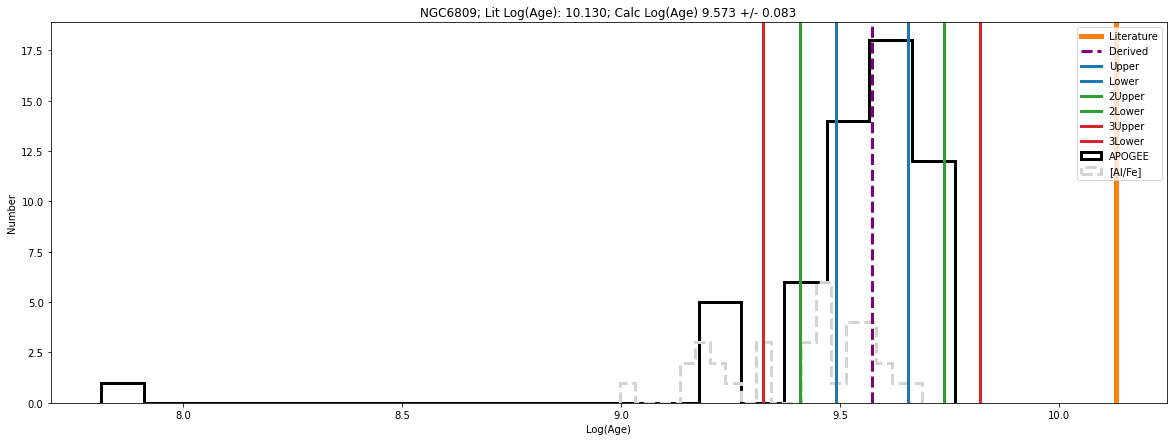

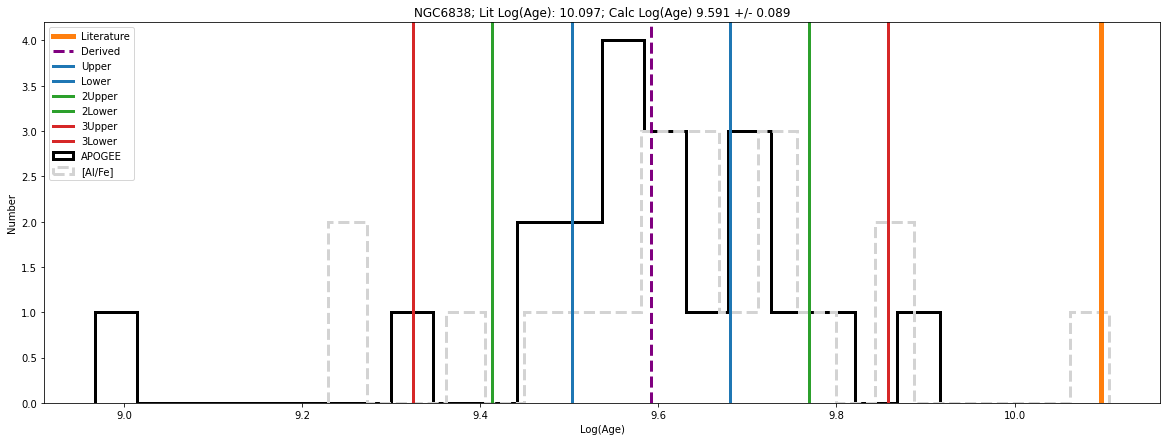

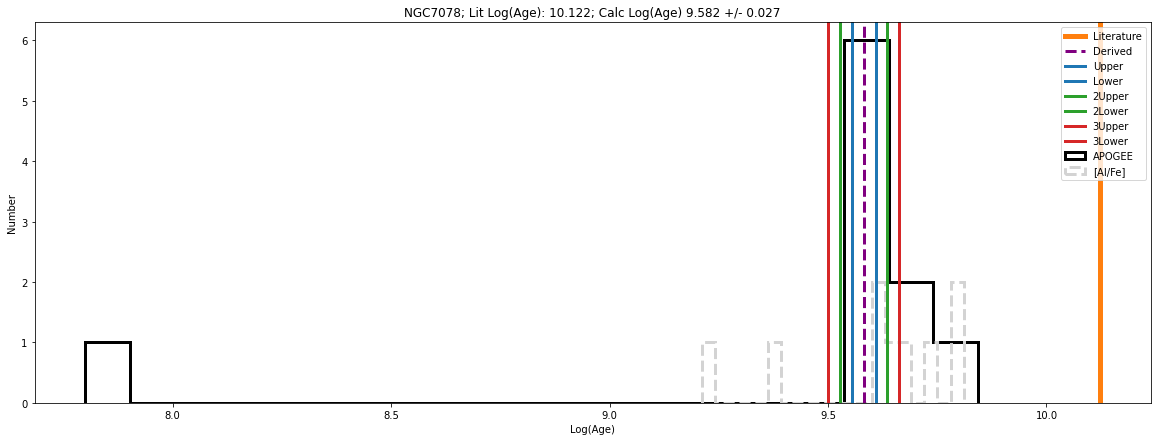

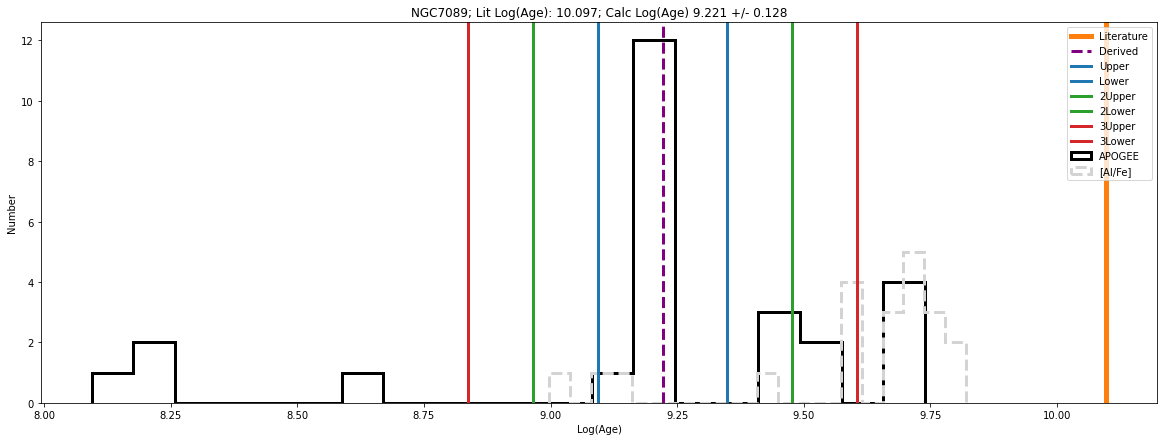

In [19]:
wiki = np.array([9.2,10.2,11.3,14,11.2,12.67,12.3,11.52,11.39,13.57,10.62,12.2,-9999.0,13.95,11.65,12.67,11.39,
                 12.3,-9999.0,13.4,13.0,12.0,13.0,13.06,11.78,12.3,10.0,12.0,13.0])

for i in range(len(np.squeeze(s2_ind))):
    clus_al = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
                                       (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind[i]])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind[i]])
    plt.figure(figsize=[20,7])
    
    ### Calculated Age Distribution
    plt.hist(parages[clus],histtype='step',lw=3.0,bins=20,label='APOGEE',color='k')
    plt.hist(parages[clus_al],histtype='step',lw=3.0,bins=20,label='[Al/Fe]',color='lightgrey',ls='--')
    
    ### Literature Value
    plt.axvline(np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]),c='tab:orange',label='Literature',lw=5.0)
#     plt.axvline(log_xmatch_age[i],c='tab:orange',label='Literature',lw=5.0)
    
    ### Calculated Age With Different Sigmas
    plt.axvline(np.median(parages[clus]),c='purple',ls='--',label='Derived',lw=3.0)
    plt.axvline(np.median(parages[clus])+afunc.mad(parages[clus]),c='tab:blue',label='Upper',lw=3.0)
    plt.axvline(np.median(parages[clus])-afunc.mad(parages[clus]),c='tab:blue',label='Lower',lw=3.0)
    plt.axvline(np.median(parages[clus])+2.*afunc.mad(parages[clus]),c='tab:green',label='2Upper',lw=3.0)
    plt.axvline(np.median(parages[clus])-2.*afunc.mad(parages[clus]),c='tab:green',label='2Lower',lw=3.0)
    plt.axvline(np.median(parages[clus])+3.*afunc.mad(parages[clus]),c='tab:red',label='3Upper',lw=3.0)
    plt.axvline(np.median(parages[clus])-3.*afunc.mad(parages[clus]),c='tab:red',label='3Lower',lw=3.0)
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind[i]],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]])
    #np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]])
    #log_match_age[i]
    plt.xlabel(r'Log(Age)')
    plt.ylabel(r'Number')
    plt.show()

In [21]:
close_age = []
med_age = []
close_feh = []
med_feh = []
for i in apogee_clus_idx2:
    use_age = np.median(parages[i])
    med_age.append(np.median(parages[i]))
    use_feh = np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i]))
    med_feh.append(np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i])))
    
    close_age.append(closest(use_age,parsec['logAge']))
    close_feh.append(closest(use_feh,parsec['MH']))
    
# supp2_close_age = []
# np.asarray(supp2['Age'])[s2_ind]
# for i in np.asarray(supp2['Age'])[s2_ind]:
#     supp2_close_age.append(closest(np.log10(i*(10**9)),parsec['logAge']))
#     print(np.log10(i*(10**9)))
    
supp2_close_age = []
for i in range(len(np.log10(np.asarray(supp2['Age']*10**9)[s2_ind]))):
    supp2_close_age.append(closest(np.asarray(wiki)[i],parsec['logAge']))
#     print(log_xmatch_age[i])

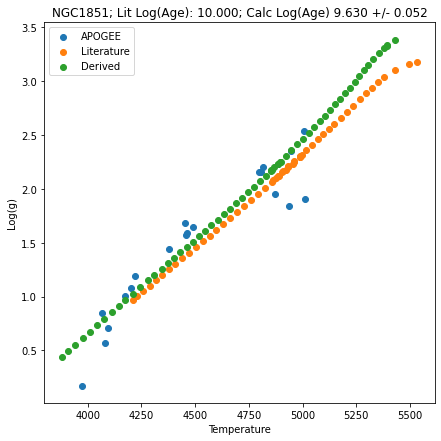

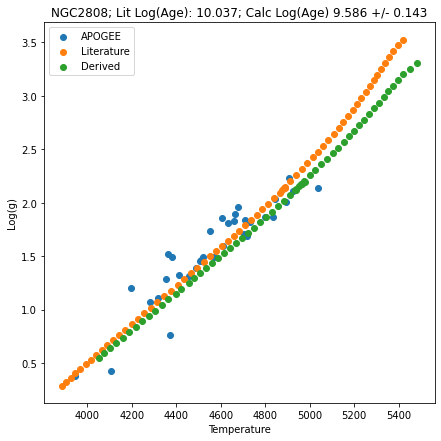

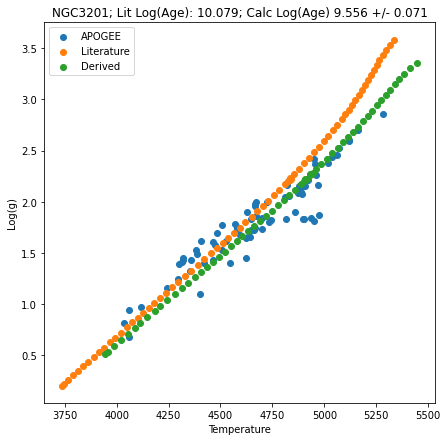

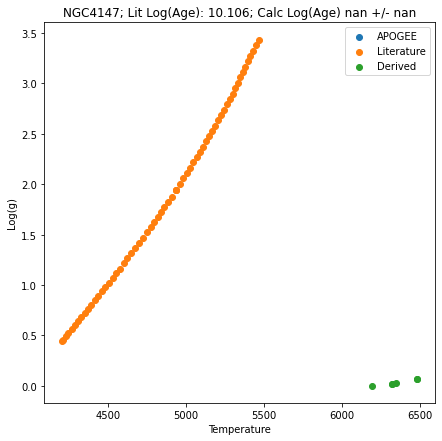

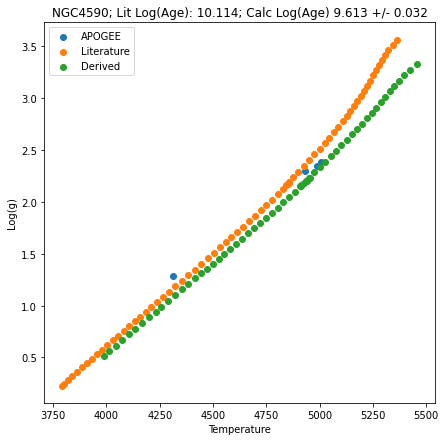

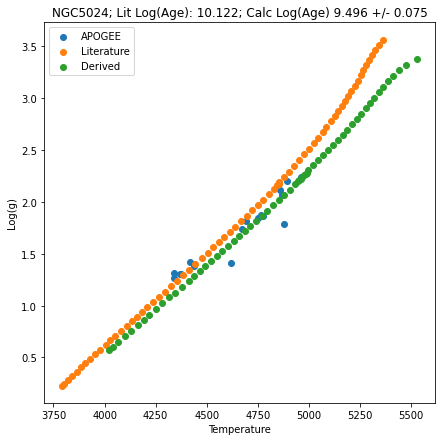

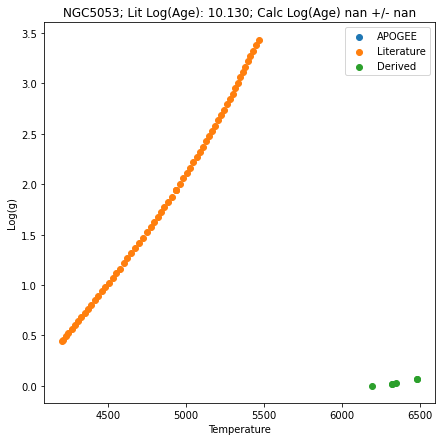

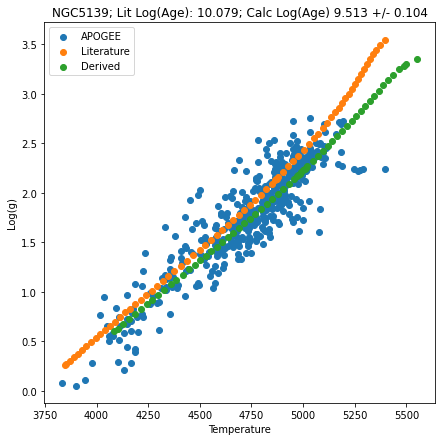

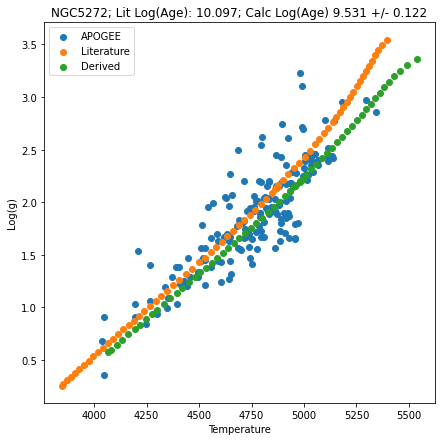

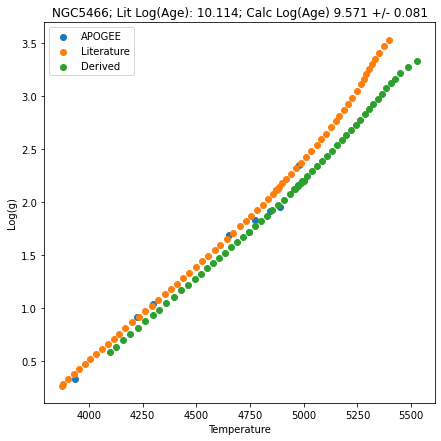

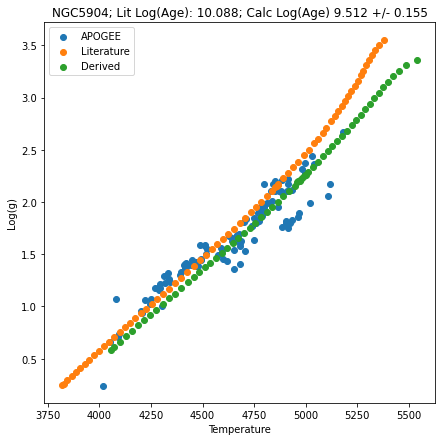

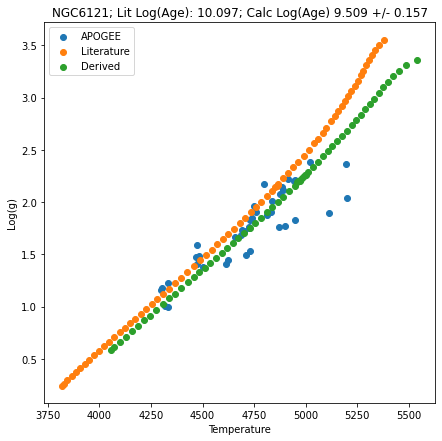

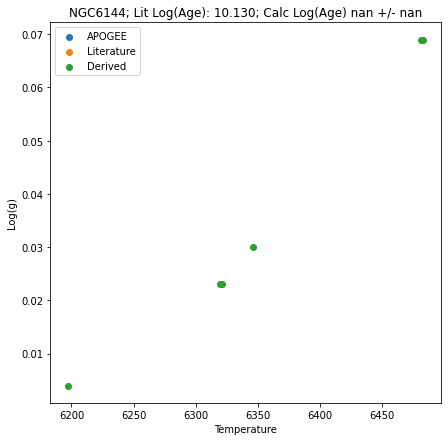

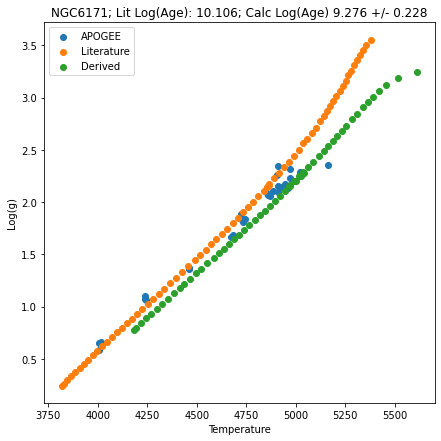

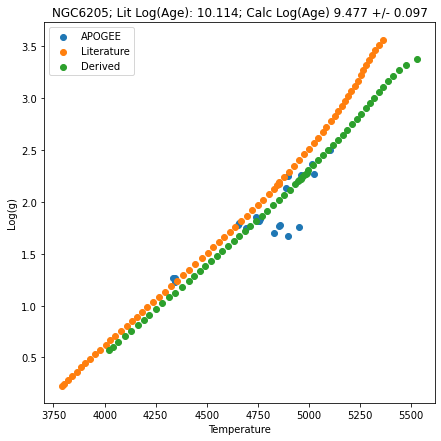

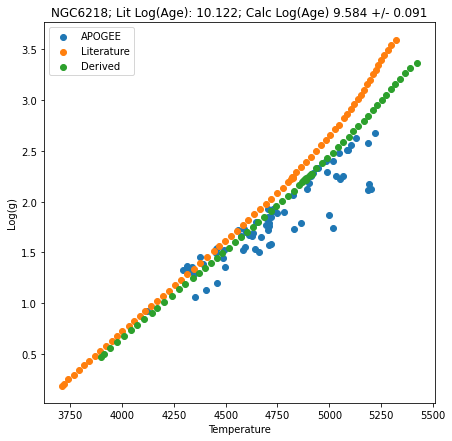

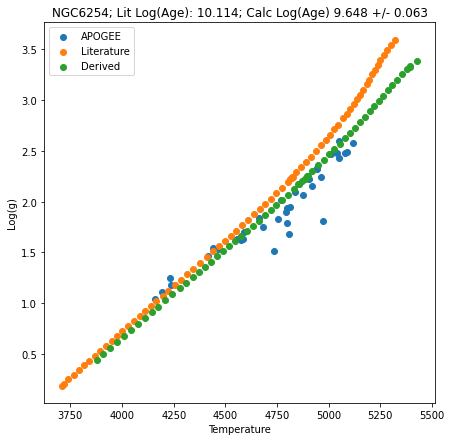

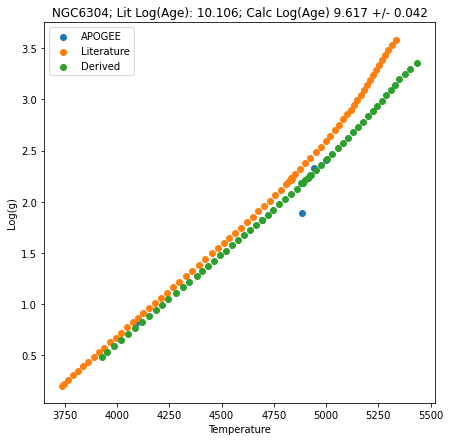

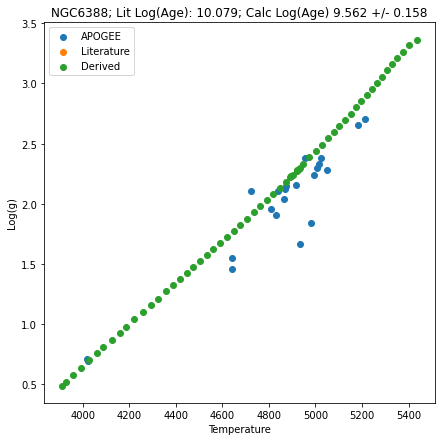

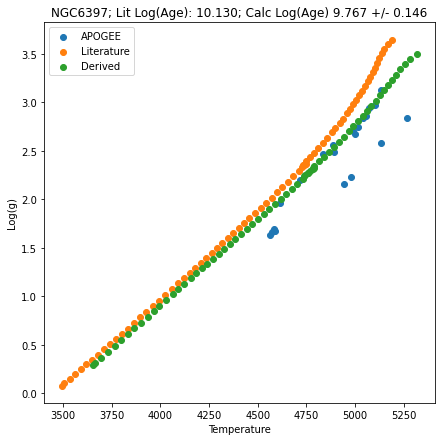

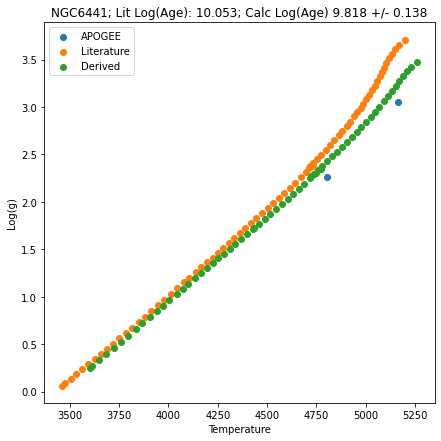

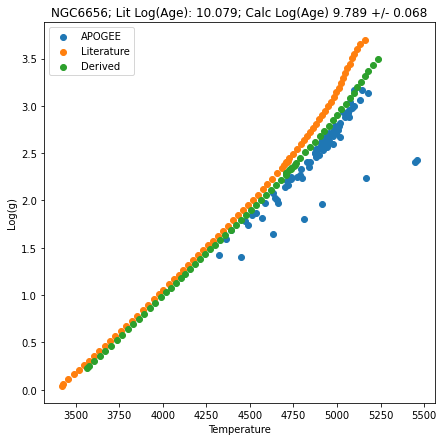

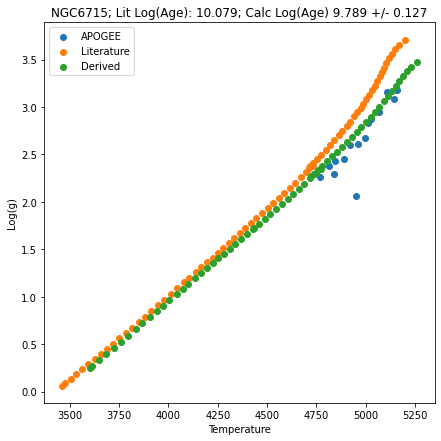

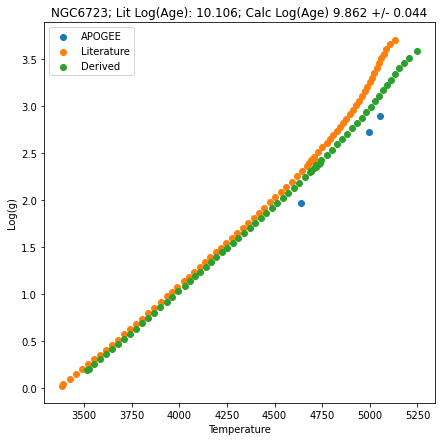

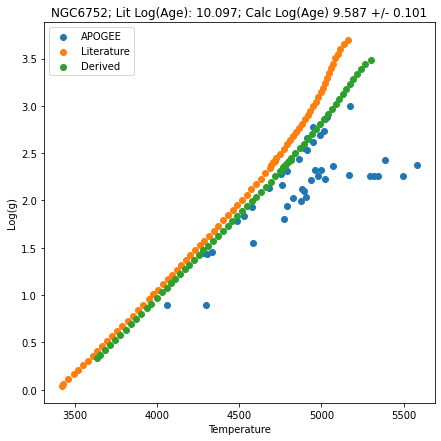

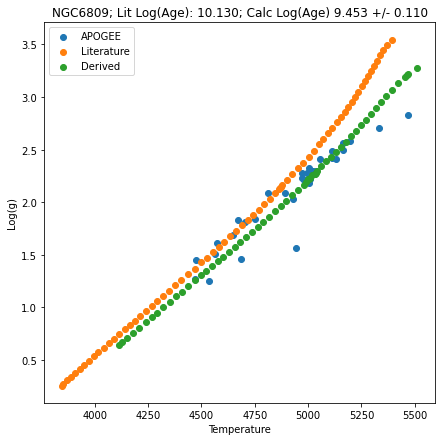

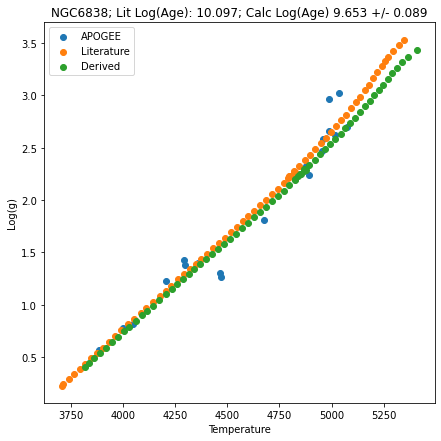

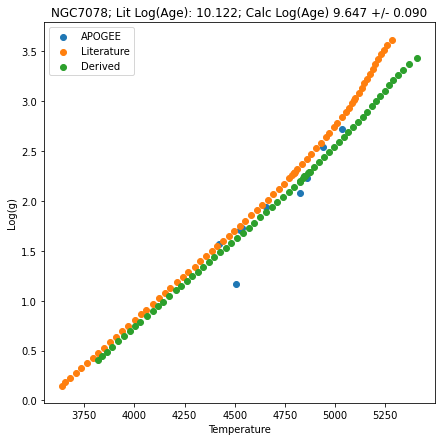

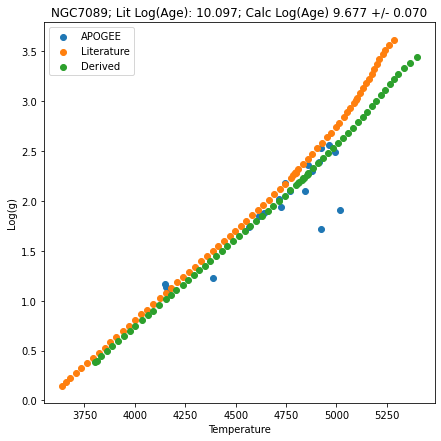

In [22]:
derived = [] 
derived_err = []
lits = []
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
                                       (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
    pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
    plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
    plt.scatter(10**parsec['logTe'][theo],parsec['logg'][theo],label='Literature')
    plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Derived')
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    #np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]])
    derived.append(np.median(parages[clus]))
    derived_err.append(afunc.mad(parages[clus]))
#     lits.append(wiki[i])
    lits.append(np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]))
#     lits.append(np.log10(np.asarray(clus_ages)[s2_ind][i]*10**9))
    
    plt.xlabel(r'Temperature')
    plt.ylabel(r'Log(g)')
    plt.show()

In [23]:
# for i in range(len(np.squeeze(s2_ind))):
#     plt.figure(figsize=[7,7])
#     clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
#                                        (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
# #     theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
# #     pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
#     gyr10 = np.where((parsec['logAge']==10.00432)&(parsec['MH']==close_feh[i]))
    
#     plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
#     plt.scatter(10**parsec['logTe'][gyr10],parsec['logg'][gyr10],label='~10 Gyr')
# #     plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Derived')
    
#     plt.legend()
    
#     plt.title(r'{}; Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
#         np.asarray(supp2['Cluster'])[s2_ind][i],10.00432,np.median(parages[clus]),afunc.mad(parages[clus])))
    
#     plt.xlabel(r'Temperature')
#     plt.ylabel(r'Log(g)')
#     plt.show()

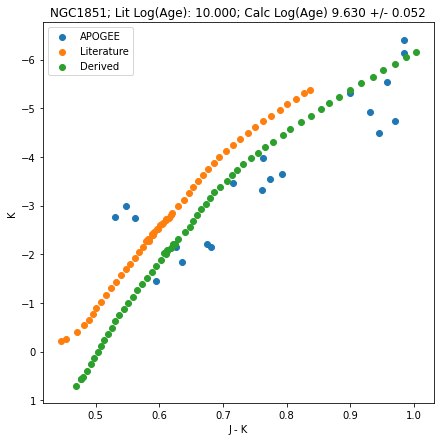

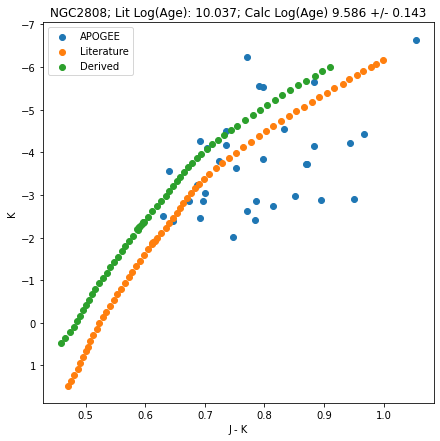

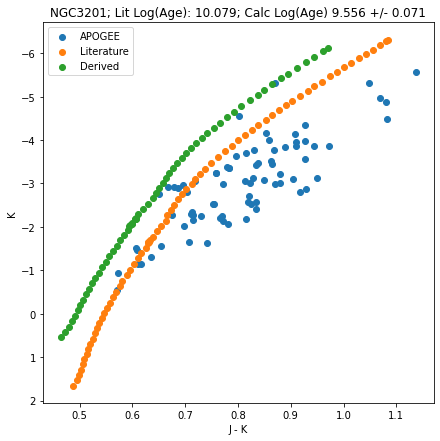

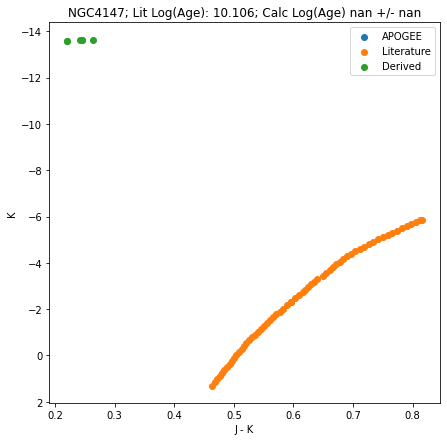

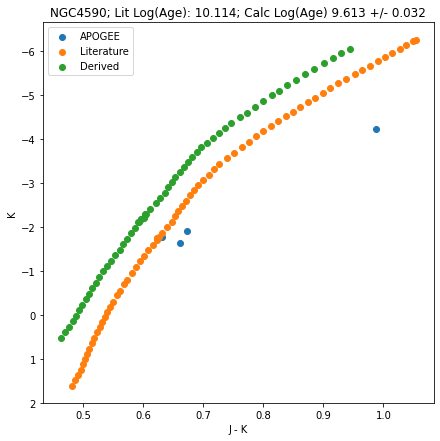

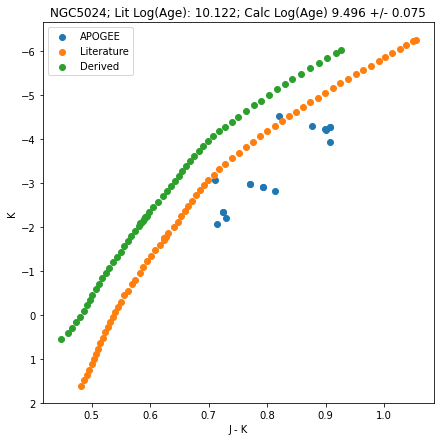

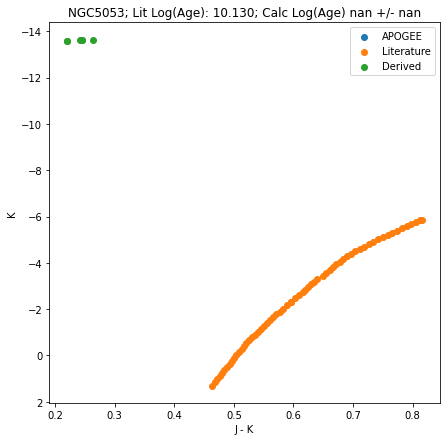

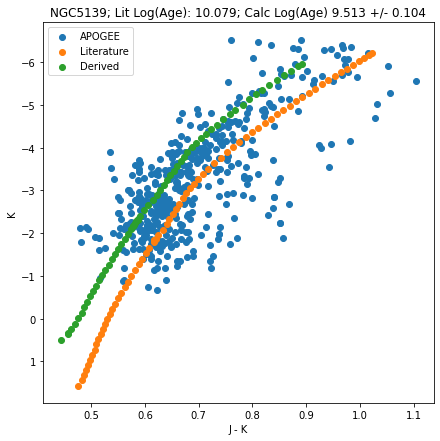

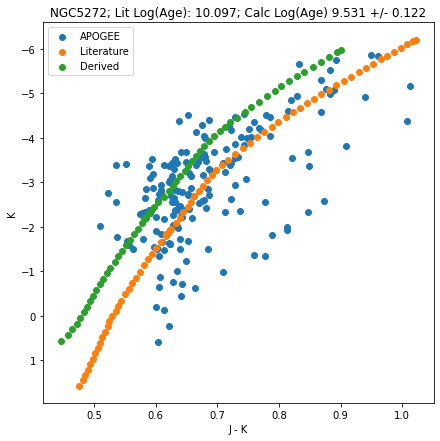

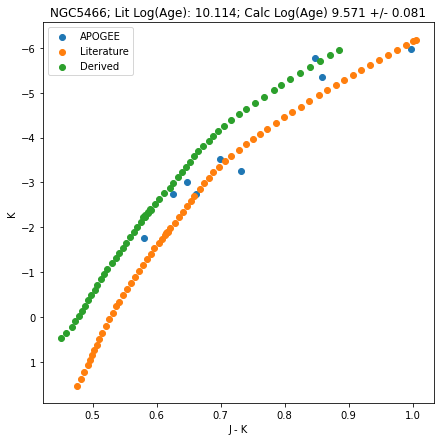

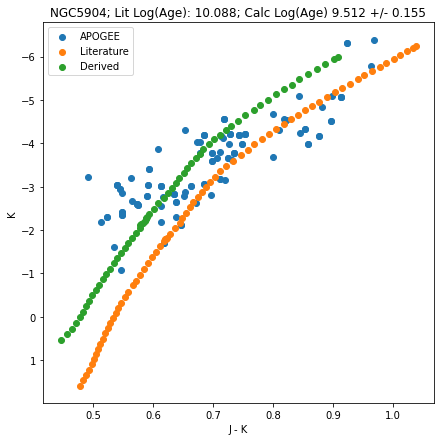

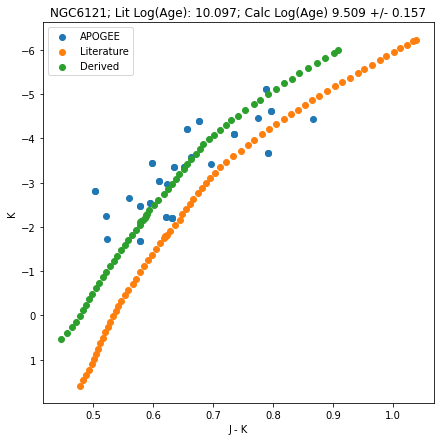

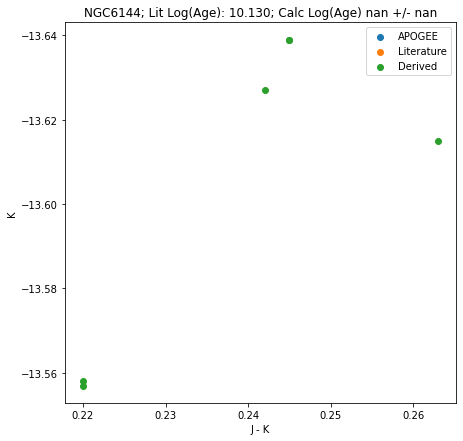

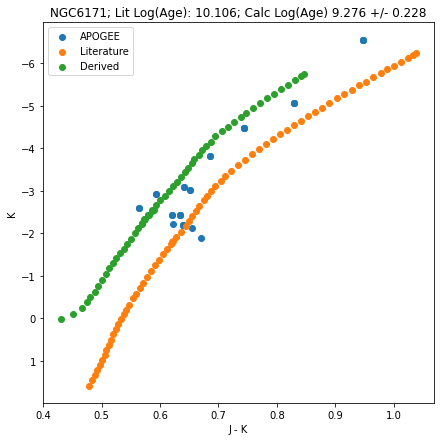

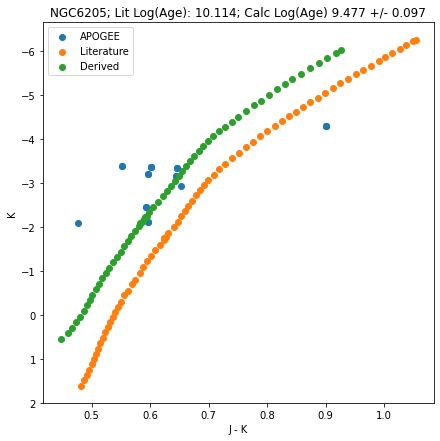

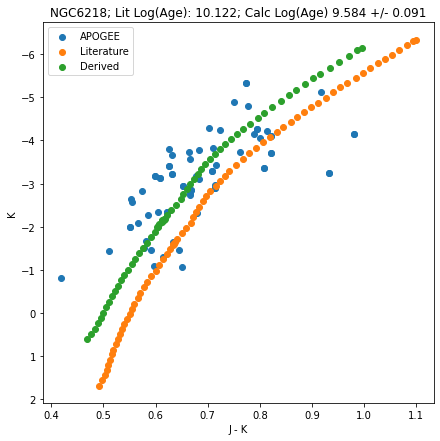

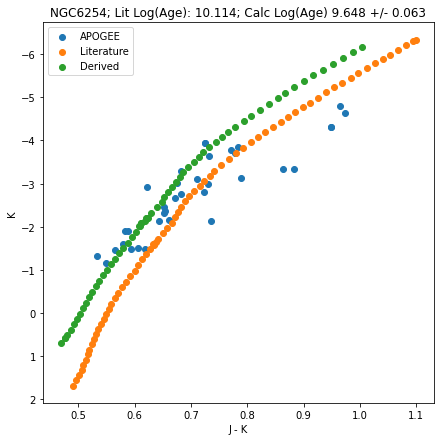

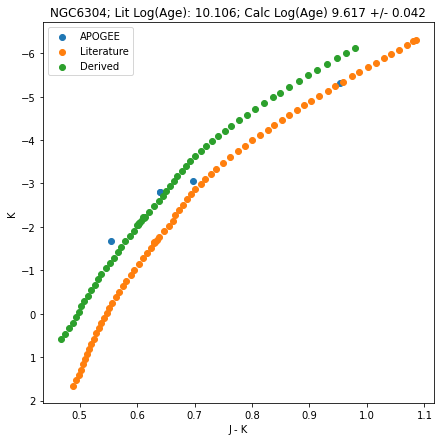

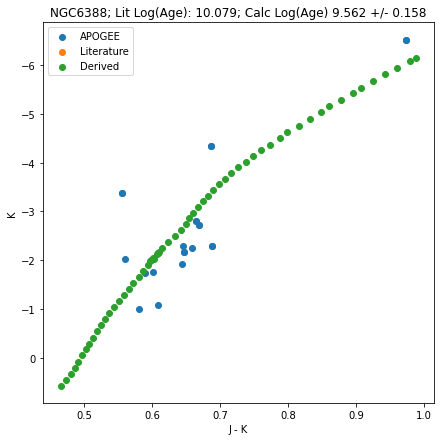

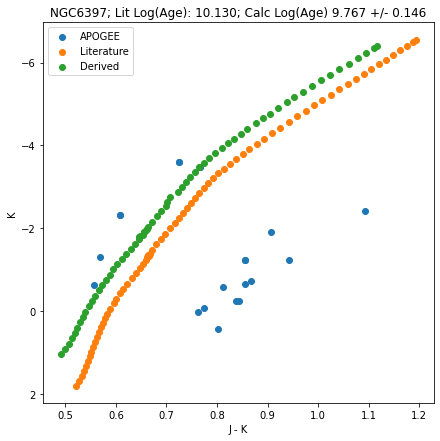

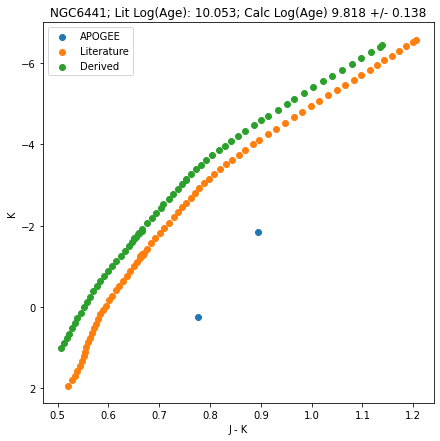

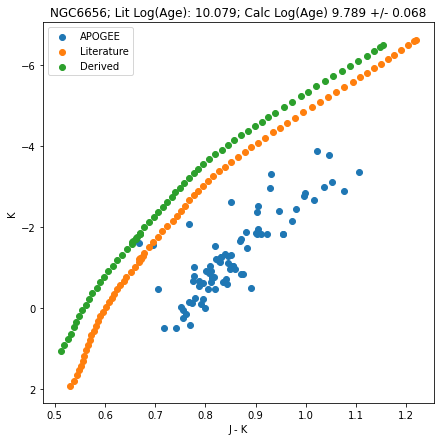

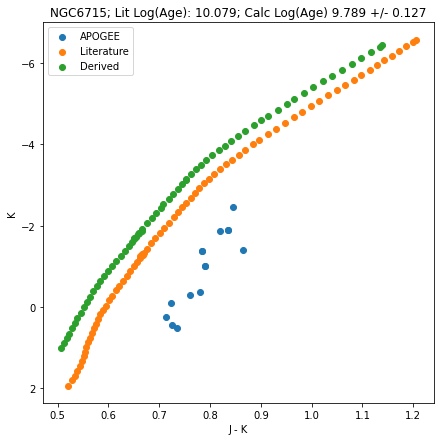

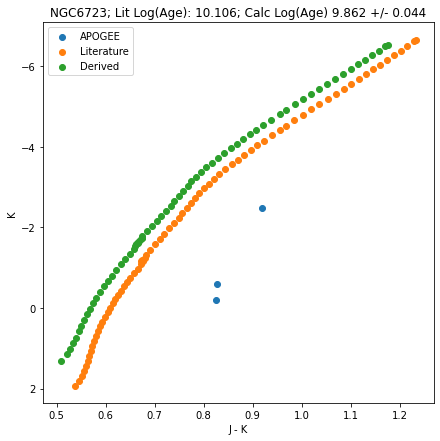

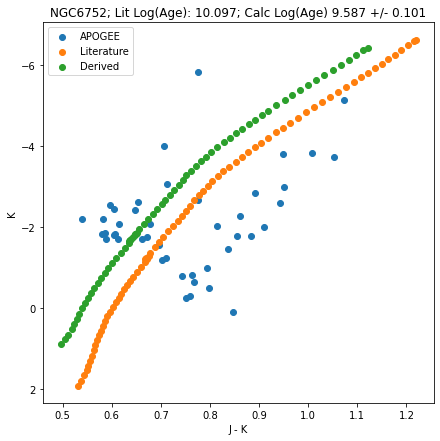

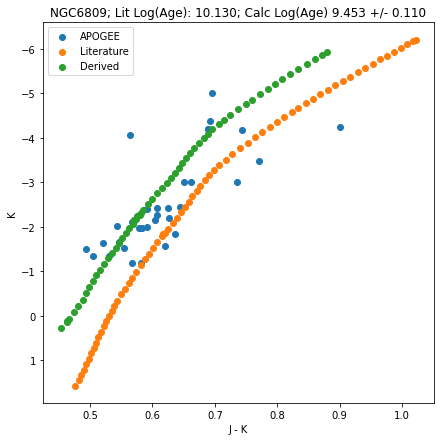

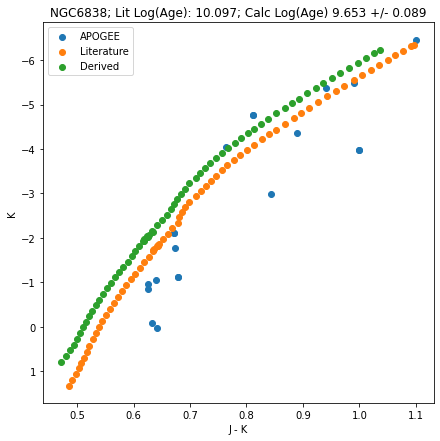

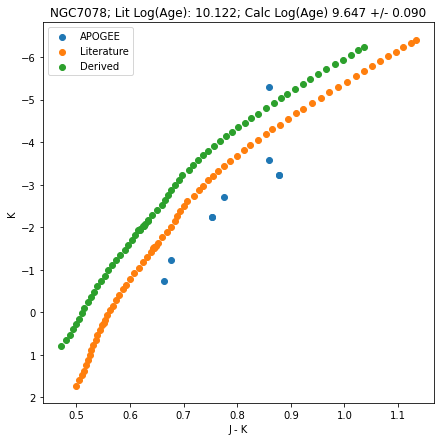

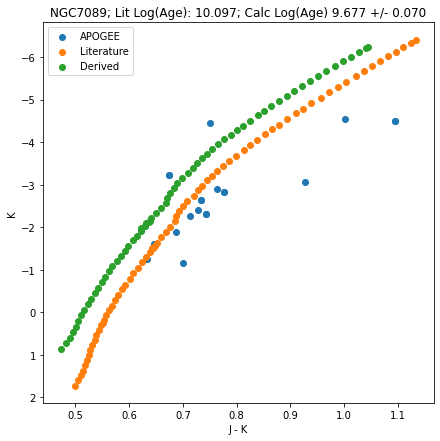

In [26]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
                                       (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
    pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
    plt.scatter((gcs['J']-gcs['K'])[clus],gcs_ksmag[clus],label='APOGEE')
    plt.scatter((parsec['Jmag']-parsec['kmag'])[theo],parsec['kmag'][theo],label='Literature')
    plt.scatter((parsec['Jmag']-parsec['kmag'])[pred],parsec['kmag'][pred],label='Derived')
    
    plt.legend()
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    #np.log10(np.asarray(clus_ages)[s2_ind][i]*10**9)
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

In [27]:
# for i in range(len(np.squeeze(s2_ind))):
#     plt.figure(figsize=[7,7])
#     clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
#                                        (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
#     gyr10 = np.where((parsec['logAge']==10.00432)&(parsec['MH']==close_feh[i]))
    
#     plt.scatter((gcs['J']-gcs['K'])[clus],gcs_ksmag[clus],label='APOGEE')
#     plt.scatter((parsec['Jmag']-parsec['Ksmag'])[gyr10],parsec['Ksmag'][gyr10],label='~10 Gyr')
    
#     plt.legend()
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
#         np.asarray(supp2['Cluster'])[s2_ind][i],10.00432,np.median(parages[clus]),afunc.mad(parages[clus])))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
#     plt.show()

In [30]:
print(np.where(np.asarray(supp2['Cluster'])[s2_ind]=='NGC6254'))
print(np.asarray(supp2['Cluster'])[s2_ind][16])
print(derived[16])
print(lits[16])

(array([16]),)
NGC6254
9.648316630159822
10.113943352306837


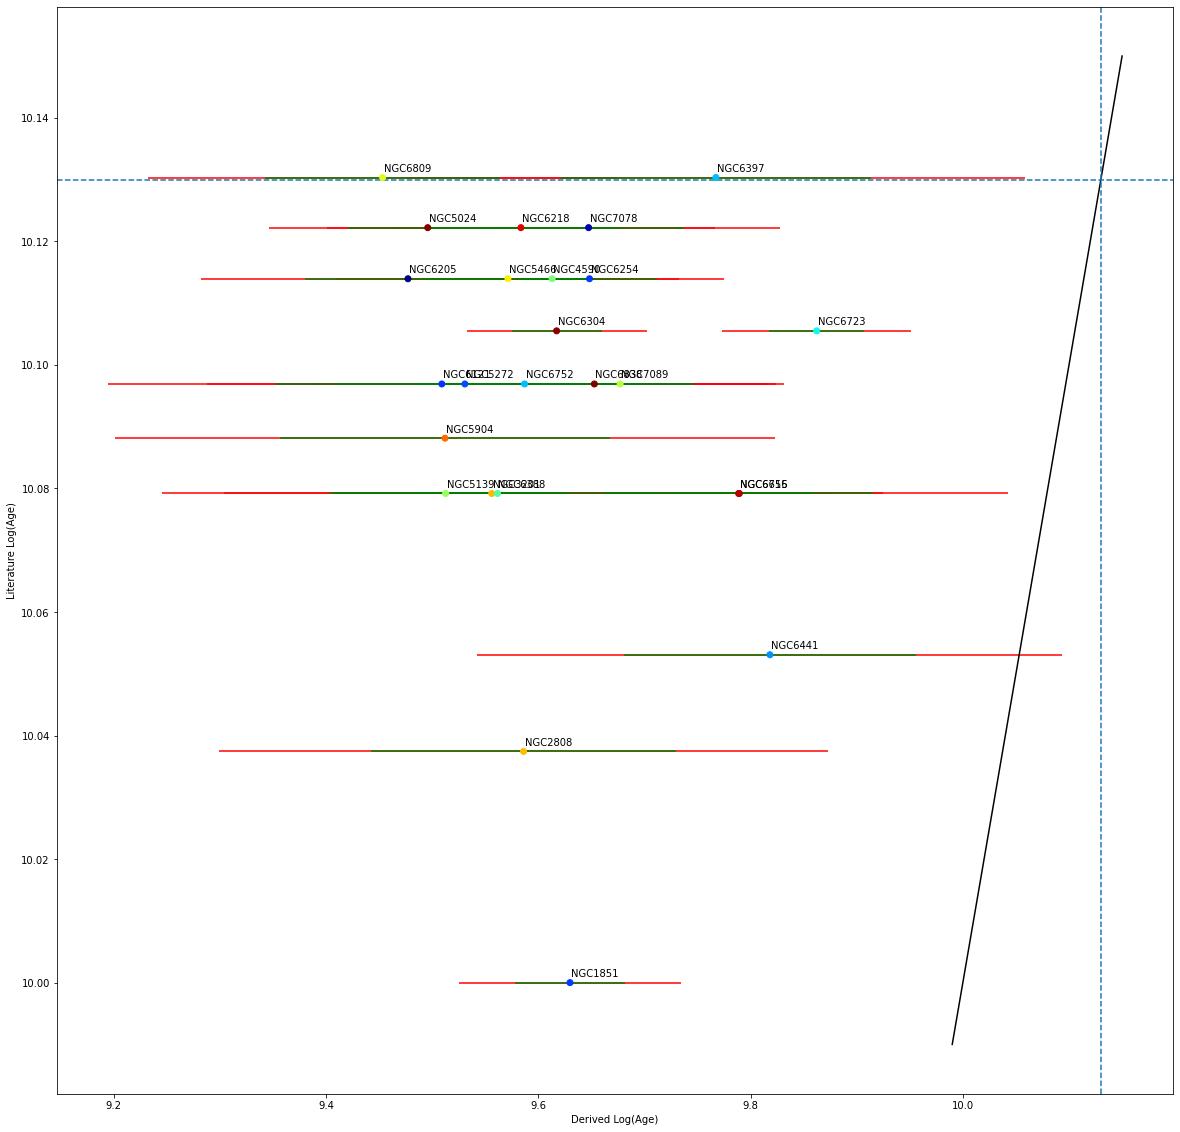

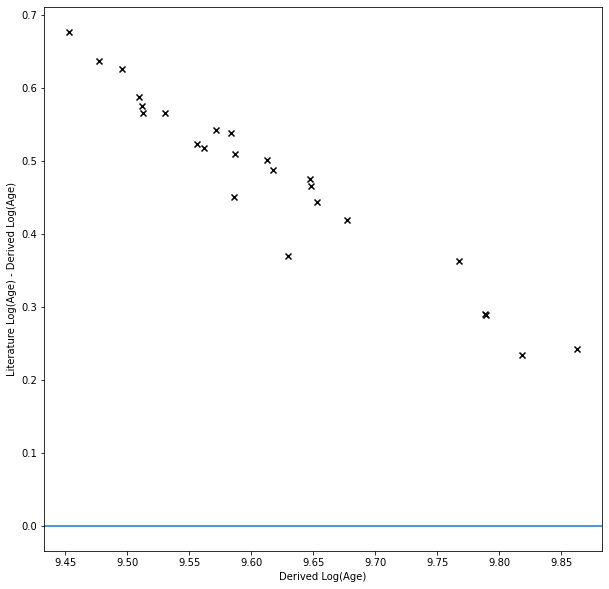

In [31]:
fin = np.where((np.isfinite(derived)==True)&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))

plt.figure(figsize=[20,20])
plt.errorbar(np.asarray(derived)[fin],np.asarray(lits)[fin],xerr=np.asarray(derived_err)[fin],ls='none',
             c='green',zorder=2)
plt.errorbar(np.asarray(derived)[fin],np.asarray(lits)[fin],xerr=2.*np.asarray(derived_err)[fin],ls='none',
             c='red',zorder=1)
plt.scatter(np.asarray(derived)[fin],np.asarray(lits)[fin],c=np.random.random(len(derived))[fin],zorder=3,
            cmap='jet')
plt.plot([9.99,10.15],[9.99,10.15],c='k')

for i in range(len(np.asarray(derived)[fin])):
    plt.text(np.asarray(derived)[fin][i]*(1.+0.0001),np.asarray(lits)[fin][i]*(1.+0.0001),
             '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(10.13,c='tab:blue',ls='--')
plt.axvline(10.13,c='tab:blue',ls='--')

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()

###
plt.figure(figsize=[10,10])
plt.scatter(x=np.asarray(derived)[fin],y=np.subtract(lits,derived)[fin],c='k',marker='x')
plt.axhline(0.0)

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age) - Derived Log(Age)')
plt.show()

In [32]:
zoff = np.polyfit(np.asarray(derived)[fin],np.subtract(np.asarray(lits)[fin],np.asarray(derived)[fin]),1)
offpoly = np.poly1d(zoff)
print(offpoly)

 
-1.045 x + 10.53


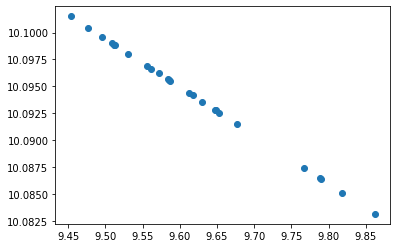

In [33]:
plt.scatter(np.asarray(derived)[fin],offpoly(np.asarray(derived)[fin])+np.asarray(derived)[fin])

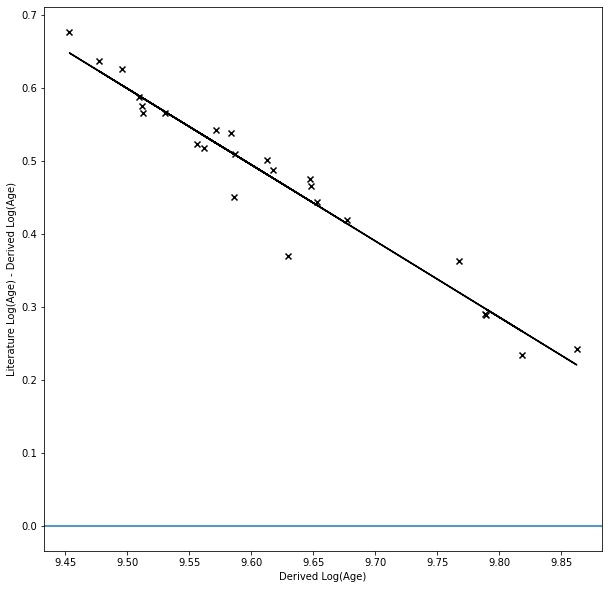

In [34]:
plt.figure(figsize=[10,10])
plt.scatter(x=np.asarray(derived)[fin],y=np.subtract(lits,derived)[fin],c='k',marker='x')
plt.plot(np.asarray(derived)[fin],offpoly(derived)[fin],c='k')
plt.axhline(0.0)

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age) - Derived Log(Age)')
plt.show()

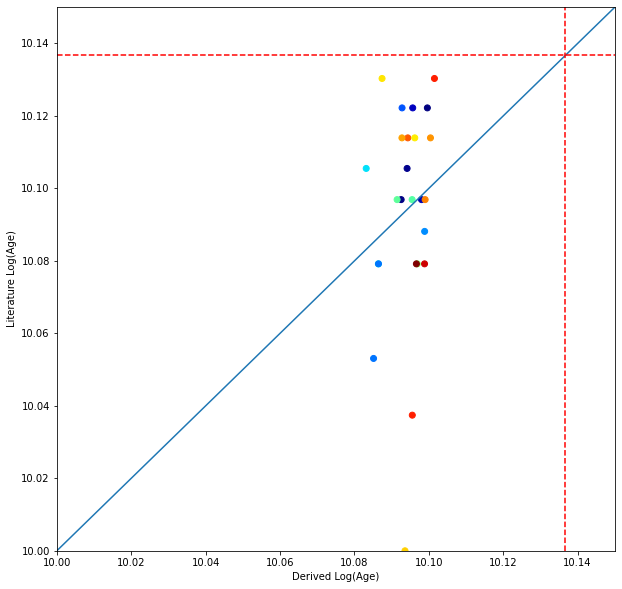

In [35]:
plt.figure(figsize=[10,10])
# plt.errorbar(np.asarray(derived)[fin],np.asarray(lits)[fin],xerr=np.asarray(derived_err)[fin],ls='none',
#              c='lightgrey',zorder=1)
plt.scatter(offpoly(np.asarray(derived)[fin])+np.asarray(derived)[fin],np.asarray(lits)[fin],
            c=np.random.random(len(derived))[fin],zorder=2,cmap='jet')
# plt.plot([9.99,10.15],[9.99,10.15],c='k')
plt.plot([10,10.2],[10,10.2])

# for i in range(len(np.asarray(derived)[fin])):
#     plt.text((offpoly(np.asarray(derived)[fin])+np.asarray(derived)[fin])[i]*(1.+0.0001),
#              np.asarray(lits)[fin][i]*(1.+0.0001),
#              '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(np.log10(13.7*10**9),c='r',ls='--')
plt.axvline(np.log10(13.7*10**9),c='r',ls='--')

plt.ylim(10,10.15)
plt.xlim(10,10.15)

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()

In [116]:
# fin = np.where((np.isfinite(derived)==True)&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))

# plt.figure(figsize=[10,10])
# plt.errorbar(np.asarray(derived)[fin],np.ones(len(np.squeeze(fin)))*10.00432,xerr=np.asarray(derived_err)[fin],
#              ls='none',c='lightgrey',zorder=1)
# plt.scatter(np.asarray(derived)[fin],np.ones(len(np.squeeze(fin)))*10.00432,c=np.random.random(len(derived))[fin],
#             zorder=2,cmap='jet')
# plt.plot([9.99,10.15],[9.99,10.15],c='k')

# # for i in range(len(np.asarray(derived)[fin])):
# #     plt.text(np.asarray(derived)[fin][i]*(1.+0.0001),np.asarray(lits)[fin][i]*(1.+0.0001),
# #              '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

# plt.axhline(10.13,c='r',ls='--')
# plt.axvline(10.13,c='r',ls='--')

# plt.xlabel('Derived Log(Age)')
# plt.ylabel('Literature Log(Age)')
# plt.show()

In [36]:
# fin = np.where((np.isfinite(derived)==True))#&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))

# plt.figure(figsize=[20,20])

# plt.errorbar(np.asarray(derived)[fin],log_xmatch_age[fin],xerr=np.asarray(derived_err)[fin],
#              ls='none',c='blue',zorder=2,label='1 Sigma')
# plt.errorbar(np.asarray(derived)[fin],log_xmatch_age[fin],xerr=2.*np.asarray(derived_err)[fin],
#              ls='none',c='green',zorder=1,label='2 Sigma')
# plt.scatter(np.asarray(derived)[fin],log_xmatch_age[fin],c='purple', zorder=3,cmap='jet') 
# #c=np.random.random(len(derived))[fin]
# plt.plot([9.96,10.15],[9.96,10.15],c='k')

# plt.plot(np.linspace(9.8,10.,10),np.linspace(9.8,10.,10)+0.15,c='r')

# for i in range(len(np.asarray(derived)[fin])):
#     plt.text(np.asarray(derived)[fin][i]*(1.+0.0001),log_xmatch_age[fin][i]*(1.+0.0001),
#              '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

# plt.axhline(10.136720567156408,c='brown',ls='--',label='Age of Universe')
# plt.axvline(10.136720567156408,c='brown',ls='--')

# plt.legend(loc='lower left',prop={'size': 20})

# plt.xlabel('Derived Log(Age)')
# plt.ylabel('Literature Log(Age)')
# plt.show()

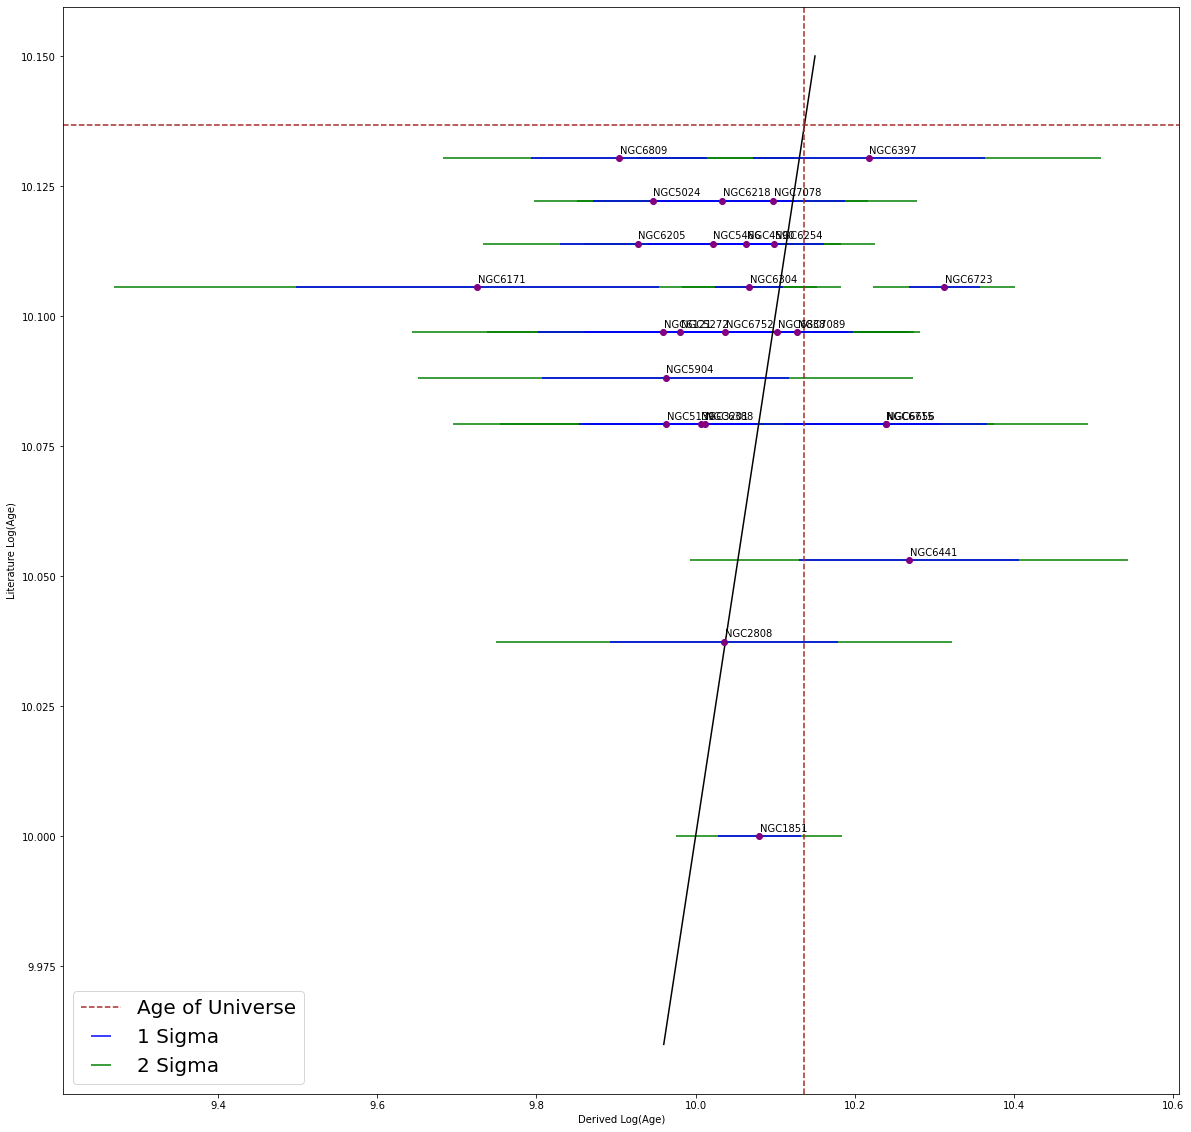

In [39]:
fin = np.where((np.isfinite(derived)==True))#&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))
shift = 0.45 #0.125

plt.figure(figsize=[20,20])

plt.errorbar(np.asarray(derived)[fin]+shift,np.asarray(lits)[fin],xerr=np.asarray(derived_err)[fin],
             ls='none',c='blue',zorder=2,label='1 Sigma')
plt.errorbar(np.asarray(derived)[fin]+shift,np.asarray(lits)[fin],xerr=2.*np.asarray(derived_err)[fin],
             ls='none',c='green',zorder=1,label='2 Sigma')
plt.scatter(np.asarray(derived)[fin]+shift,np.asarray(lits)[fin],c='purple', zorder=3,cmap='jet') 
#c=np.random.random(len(derived))[fin]
plt.plot([9.96,10.15],[9.96,10.15],c='k')

# plt.plot(np.linspace(9.8,10.,10),np.linspace(9.8,10.,10)+0.15,c='r')

for i in range(len(np.asarray(derived)[fin])):
    plt.text(np.asarray(derived)[fin][i]*(1.+0.0001)+shift,np.asarray(lits)[fin][i]*(1.+0.0001),
             '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(10.136720567156408,c='brown',ls='--',label='Age of Universe')
plt.axvline(10.136720567156408,c='brown',ls='--')

plt.legend(loc='lower left',prop={'size': 20})

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()

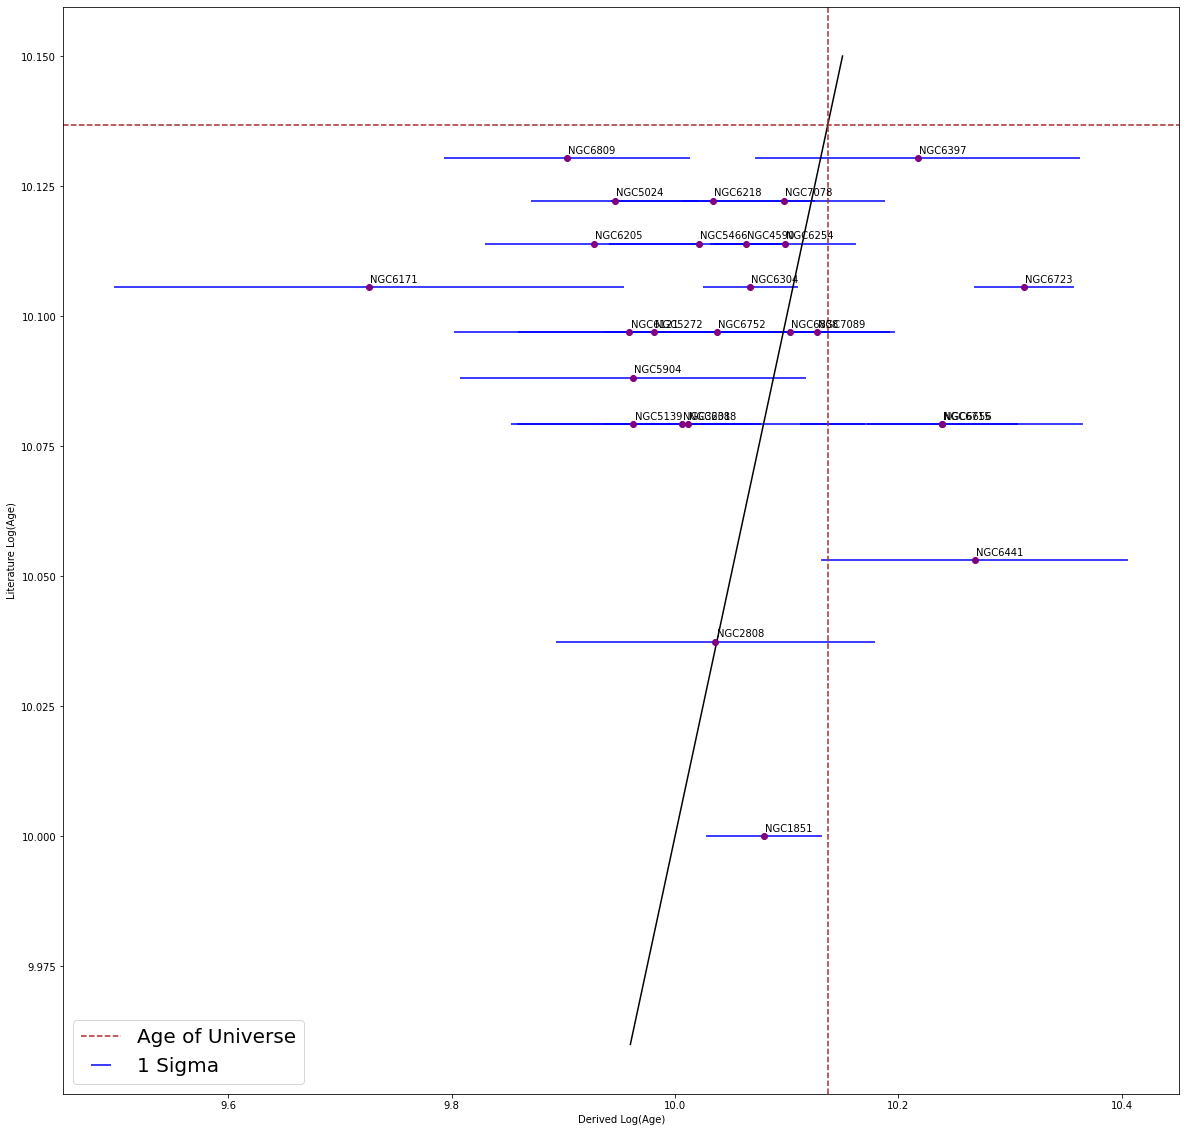

In [40]:
fin = np.where((np.isfinite(derived)==True))#&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))
shift = 0.45 #0.125

plt.figure(figsize=[20,20])

plt.errorbar(np.asarray(derived)[fin]+shift,np.asarray(lits)[fin],xerr=np.asarray(derived_err)[fin],
             ls='none',c='blue',zorder=2,label='1 Sigma')
# plt.errorbar(np.asarray(derived)[fin]+shift,log_xmatch_age[fin],xerr=2.*np.asarray(derived_err)[fin],
#              ls='none',c='green',zorder=1,label='2 Sigma')
plt.scatter(np.asarray(derived)[fin]+shift,np.asarray(lits)[fin],c='purple', zorder=3,cmap='jet') 
#c=np.random.random(len(derived))[fin]
plt.plot([9.96,10.15],[9.96,10.15],c='k')

# plt.plot(np.linspace(9.8,10.,10),np.linspace(9.8,10.,10)+0.15,c='r')

for i in range(len(np.asarray(derived)[fin])):
    plt.text(np.asarray(derived)[fin][i]*(1.+0.0001)+shift,np.asarray(lits)[fin][i]*(1.+0.0001),
             '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(10.136720567156408,c='brown',ls='--',label='Age of Universe')
plt.axvline(10.136720567156408,c='brown',ls='--')

plt.legend(loc='lower left',prop={'size': 20})

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()

In [52]:
print(10**(np.median(parages)+0.45)/10**9)
print(10**(np.median(parages))/10**9)
print(10**(np.median(parages)+0.125)/10**9)

10.509836319992901
3.729030644986816
4.972742286283743


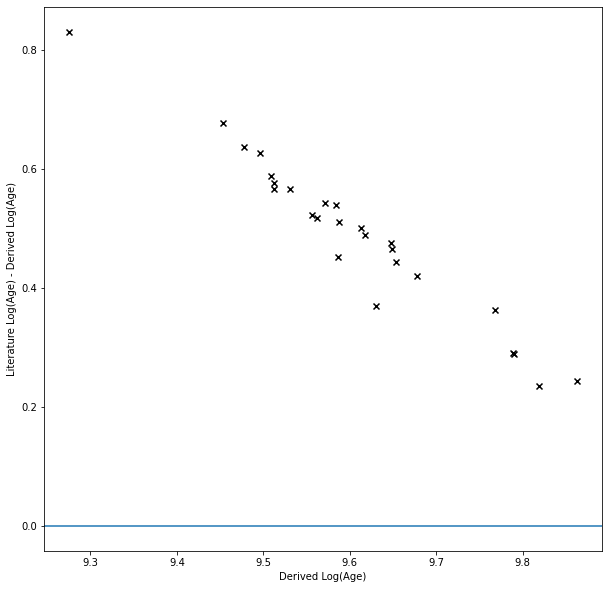

In [51]:
###
plt.figure(figsize=[10,10])
plt.scatter(x=np.asarray(derived)[fin],y=np.subtract(lits,derived)[fin],c='k',marker='x')
plt.axhline(0.0)

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age) - Derived Log(Age)')
plt.show()

In [100]:
10**log_xmatch_age/10**9

array([ 9.2 , 11.2 , 11.1 , 14.  , 12.7 , 12.7 , 12.3 , 11.52, 11.4 ,
       13.6 , 11.5 , 13.1 , 13.4 , 10.98, 11.7 , 13.4 , 12.4 , 12.3 ,
       11.7 , 13.4 , 13.7 , 12.7 , 10.8 , 13.06, 13.8 , 13.8 , 12.7 ,
       13.6 , 11.8 ])

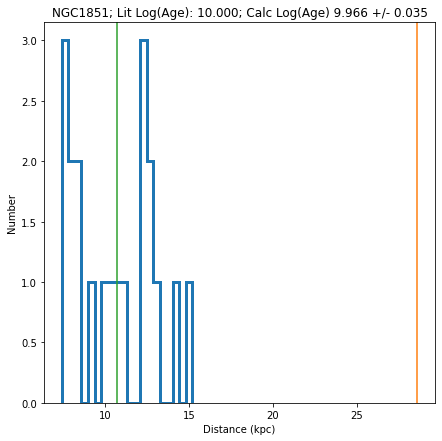

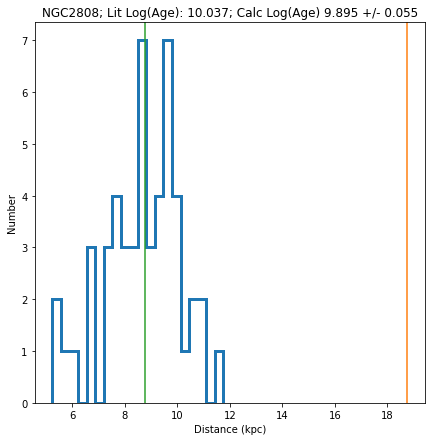

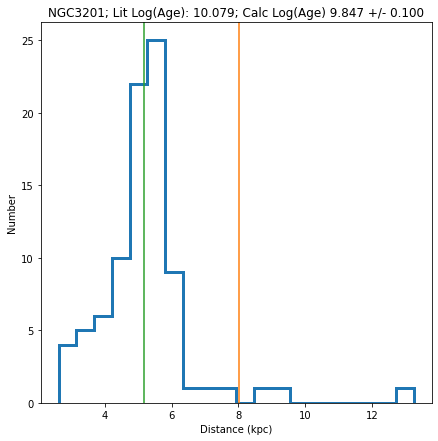

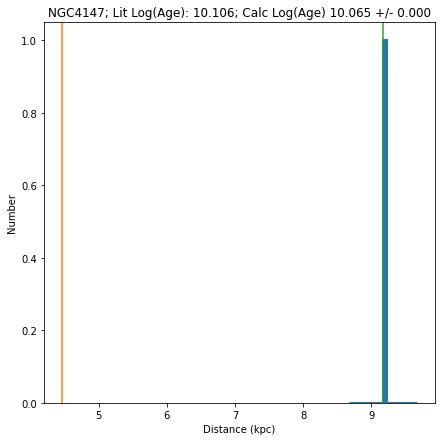

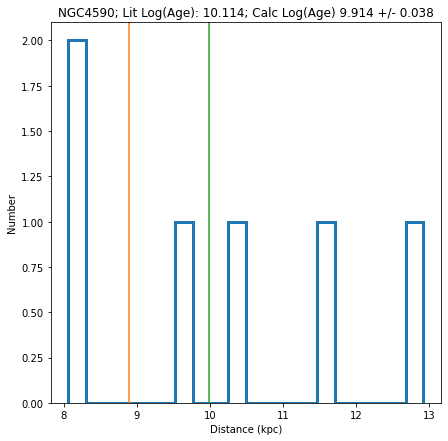

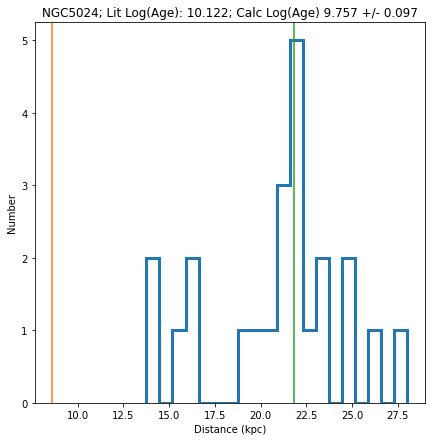

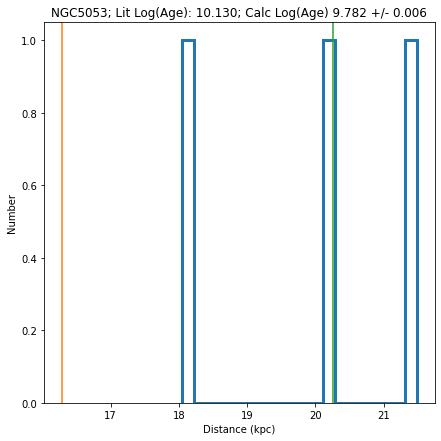

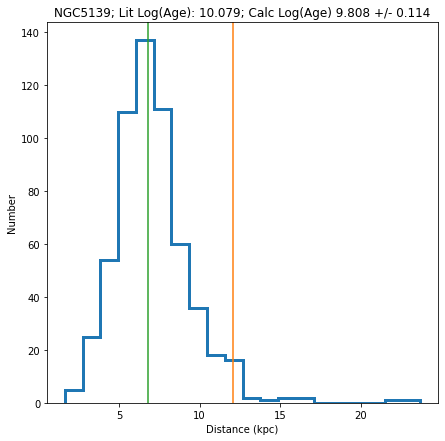

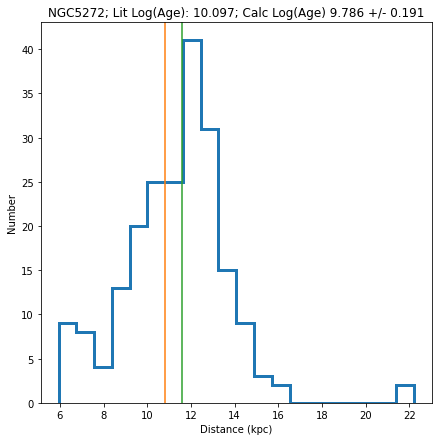

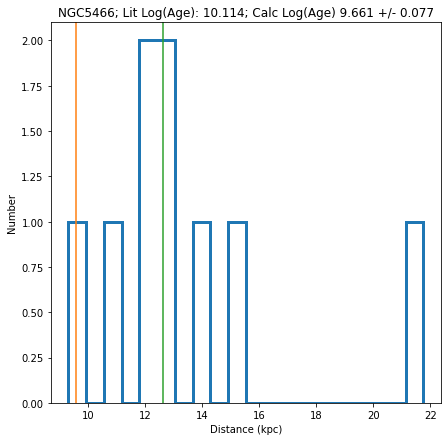

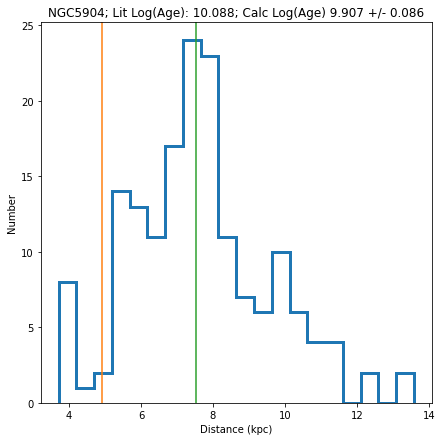

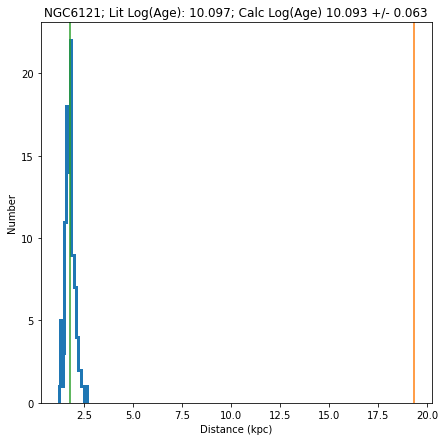

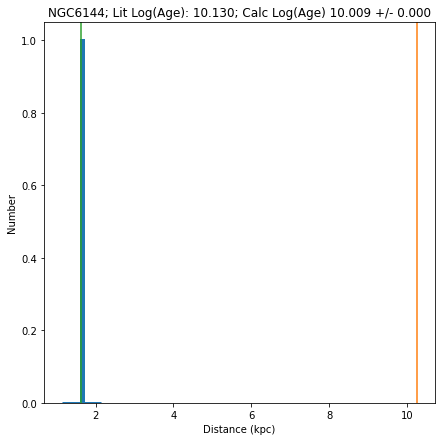

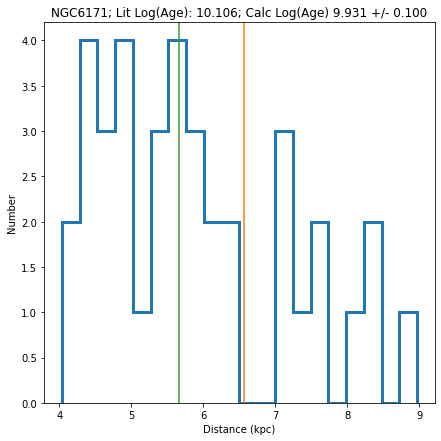

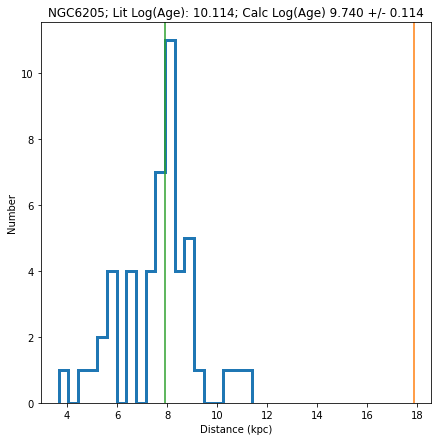

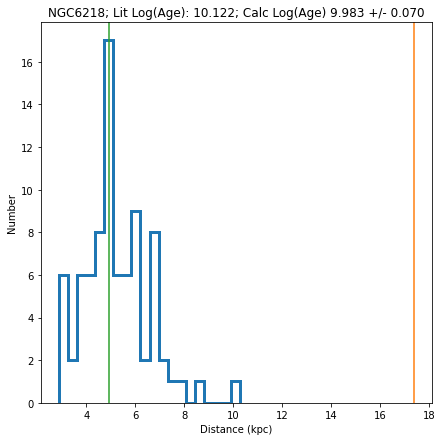

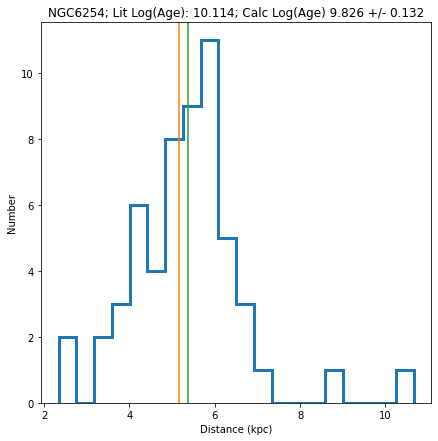

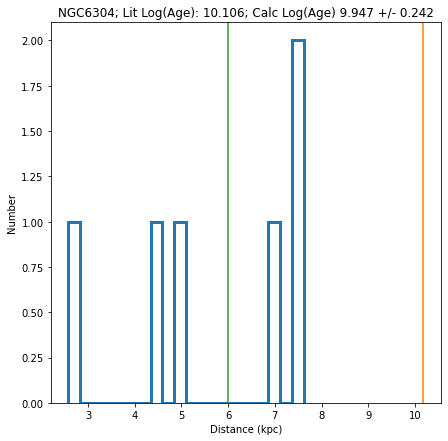

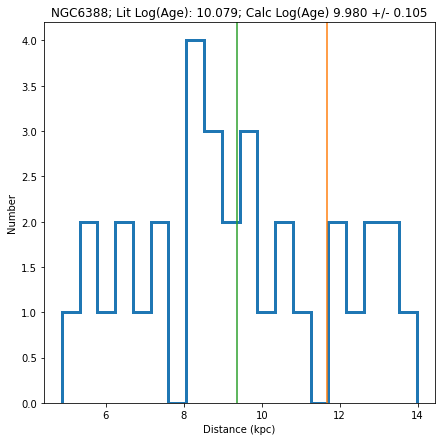

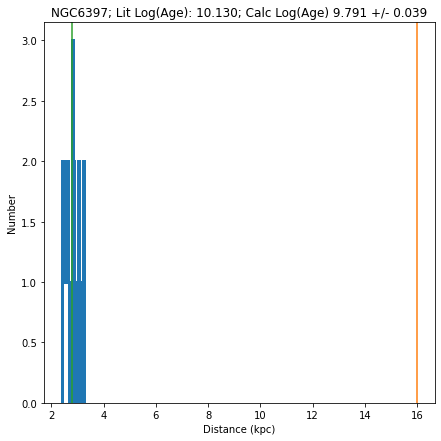

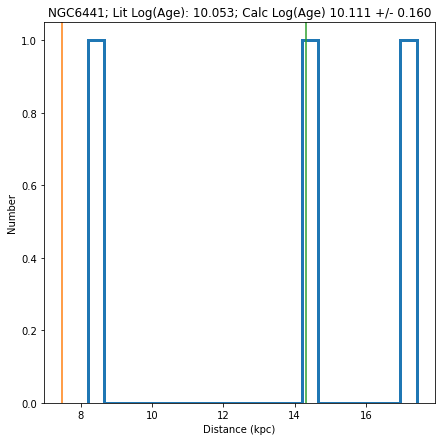

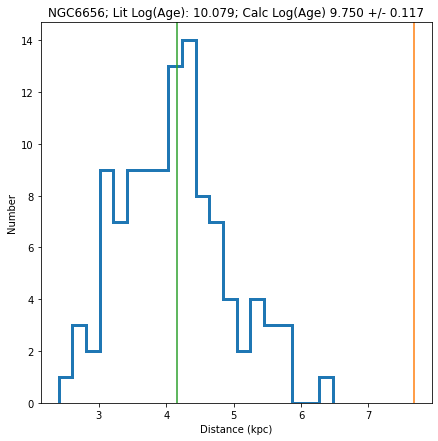

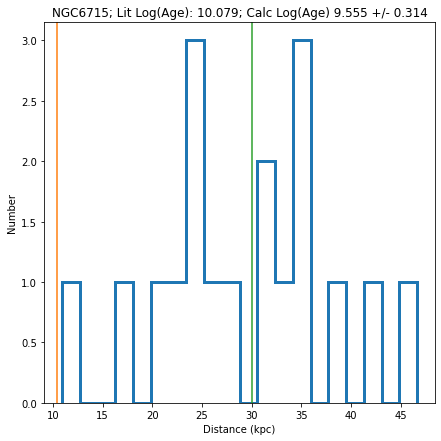

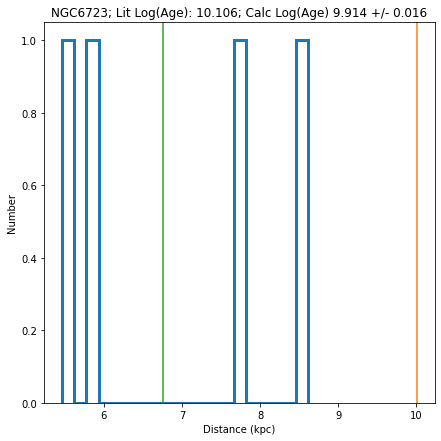

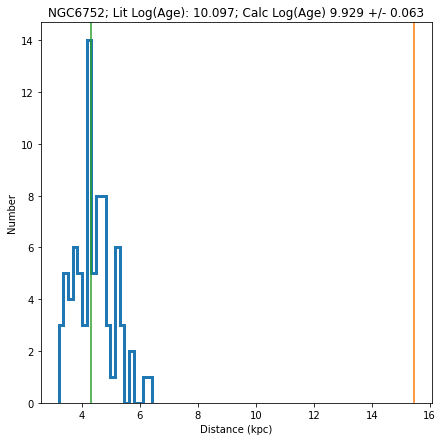

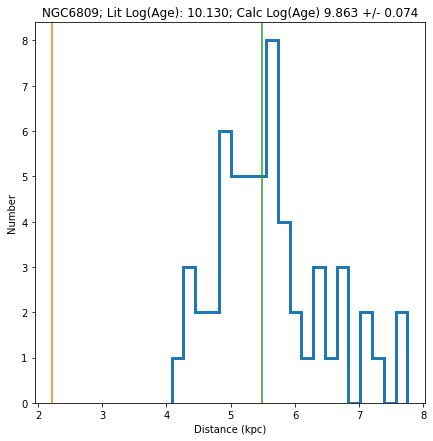

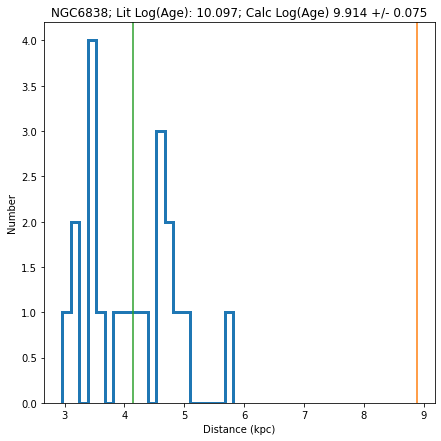

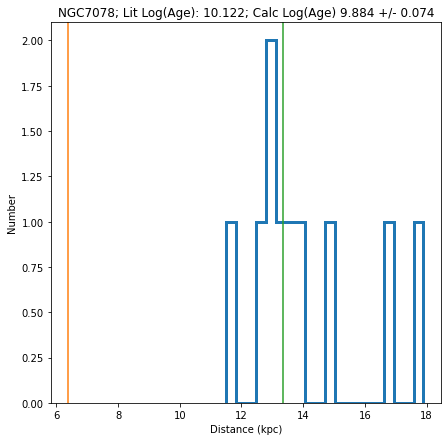

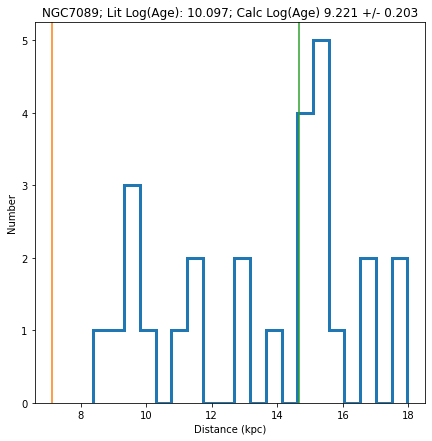

In [48]:
clusdist = 10**((supp2['Dist']+5.-supp2['Av'])/5.) 
diff_dist = []
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    plt.hist(gcs['distmed'][clus],histtype='step',lw=3.0,bins=20,label='APOGEE')
    plt.axvline(np.median(gcs['distmed'][clus]),color='tab:green',label='Observed')
    plt.axvline(clusdist[i]/1000.,c='tab:orange',label='Literature')
    
    
    diff_dist.append(np.asarray(clusdist[i])/1000.-np.median(gcs['distmed'][clus]))
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind][i]),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    plt.xlabel(r'Distance (kpc)')
    plt.ylabel(r'Number')
    plt.show()

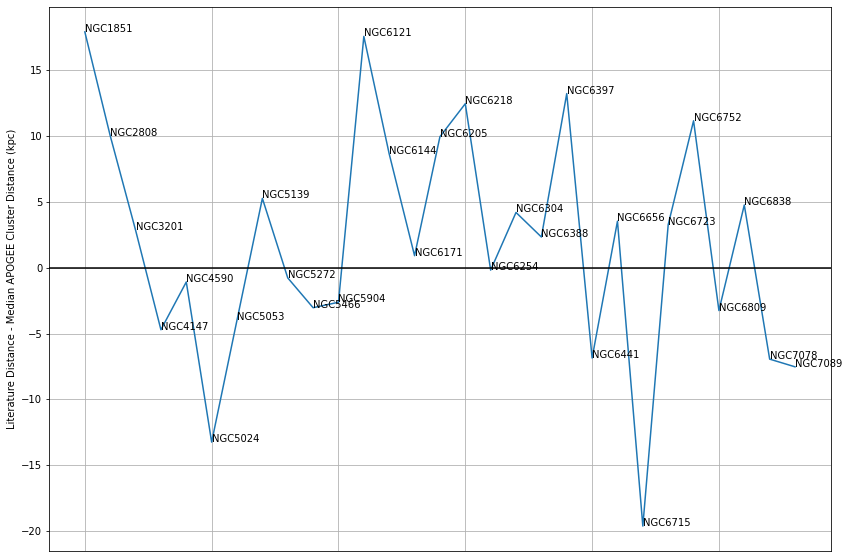

In [49]:
plt.figure(figsize=[14,10])
plt.plot(diff_dist)
plt.tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)

plt.axhline(0,c='k')

for i in range(len(diff_dist)):
    plt.text(range(len(diff_dist))[i],diff_dist[i],'{}'.format(np.asarray(supp2['Cluster'])[s2_ind][i]))

plt.grid()
plt.ylabel(r'Literature Distance - Median APOGEE Cluster Distance (kpc)')
plt.show()

(array([  1.,   0.,   2.,  15., 160., 378., 252., 256., 290., 275.]),
 array([-1.0292716 , -0.8863756 , -0.7434796 , -0.60058355, -0.45768756,
        -0.31479156, -0.17189555, -0.02899954,  0.11389647,  0.2567925 ,
         0.39968848], dtype=float32),
 <a list of 10 Patch objects>)

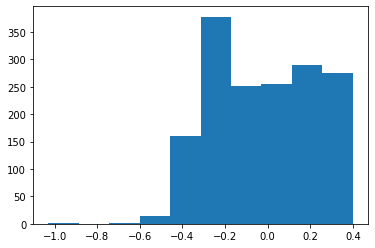

In [50]:
plt.hist(gcs['AL_FE'][np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))])

In [51]:
len(np.squeeze(np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))))/len(gcs)

0.745537757437071

In [52]:
supp2['Dist']

0     17.59
1     17.08
2     16.78
3     13.37
4     14.84
      ...  
64    19.51
65    18.63
66    17.25
67    17.01
68    17.47
Name: Dist, Length: 69, dtype: float64

<font size='45'>
    <b>
        Harris Distances
    </b>
</font>

In [109]:
# clusdist = 10**((supp2['Dist']+5.-supp2['Av'])/5.)
# dists = np.ones(len(gcs))
# dists_err = np.ones(len(gcs))
# for i in range(len(np.squeeze(s2_ind))):
#     clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
#     dists[clus] = clusdist[i]/1000.
#     dists_err[clus] = (0.461*clusdist[i]/1000.*np.sqrt(np.asarray(supp2['Dist_Sigma'][i])**2+
#                                                  np.asarray(supp2['Av_Sigma'][i])**2))
    
#     diff_dist.append(np.asarray(clusdist[i])/1000.-np.median(gcs['distmed'][clus]))

# harris_dis = np.array([12.1,9.6,4.9,19.3,10.3,17.9,17.4,5.2,10.2,16.0,7.5,2.2,8.9,6.4,7.1,4.8,4.4,5.9,9.9,2.3,
#                        11.6,10.0,26.5,8.7,4.0,5.4,4.0,10.4,11.5])
# dists = np.ones(len(gcs))
# for i,j in enumerate(s2_ind):
#     clus = np.where(ngc_names==np.asarray(supp2['Cluster'][j]))
#     dists[clus] = harris_dis[i]

In [111]:
harris_dis = np.array([12.1,9.6,4.9,19.3,10.3,17.9,17.4,5.2,10.2,16.0,7.5,2.2,8.9,6.4,7.1,4.8,4.4,5.9,9.9,2.3,
                       11.6,10.0,26.5,8.7,4.0,5.4,4.0,10.4,11.5])
dists = np.ones(len(gcs))
for i,j in enumerate(s2_ind):
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'][j]))
    dists[clus] = harris_dis[i]

age_dist_lit = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],
                                                  parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = dists[i]
#     dist_err = dists_err[i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = dist #np.abs(add_noise(dist,dist_err))
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist_lit.append(noise_ages)

parages_lit = [] 
devs_lit = []
for k in tqdm_notebook(range(len(age_dist_lit))):
    devs_lit.append(afunc.mad(age_dist_lit[k]))
    parages_lit.append(np.median(age_dist_lit[k]))
devs_lit = np.asarray(devs_lit)
parages_lit = np.asarray(parages_lit)

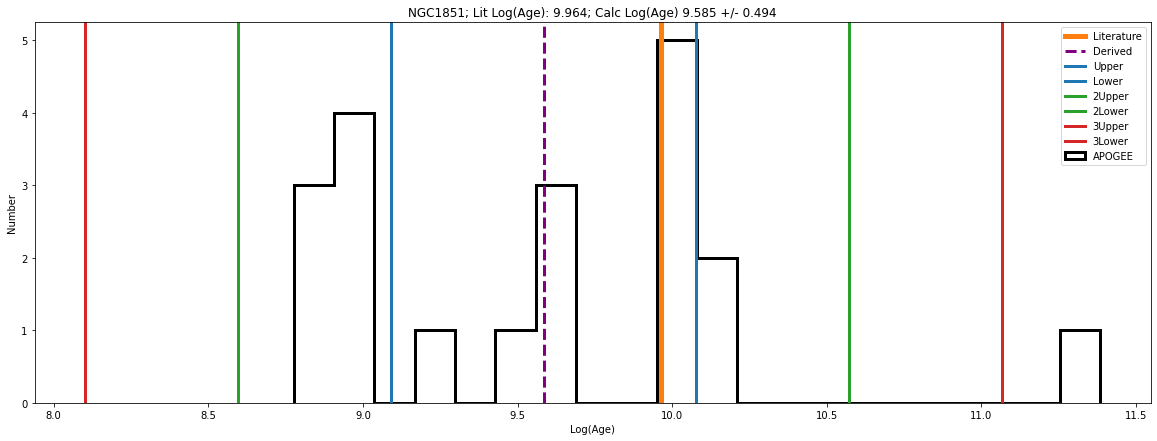

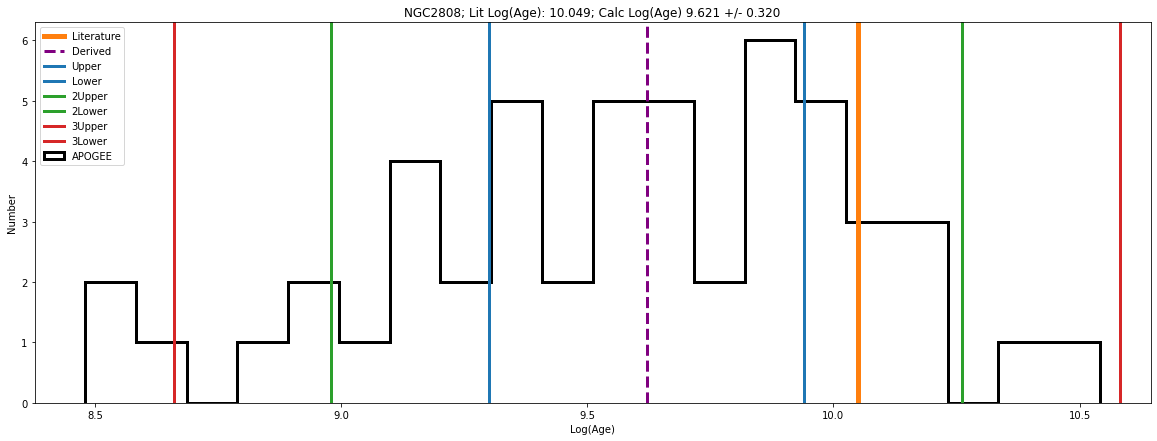

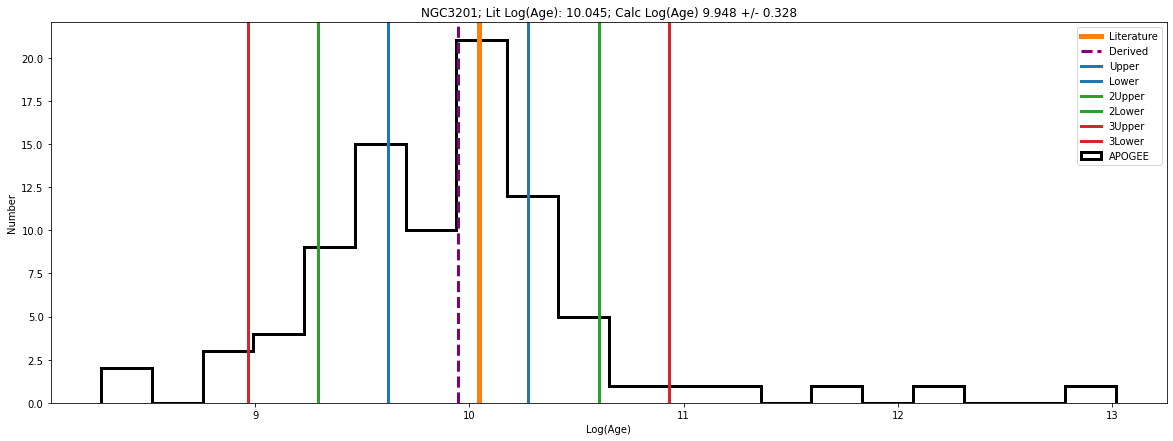

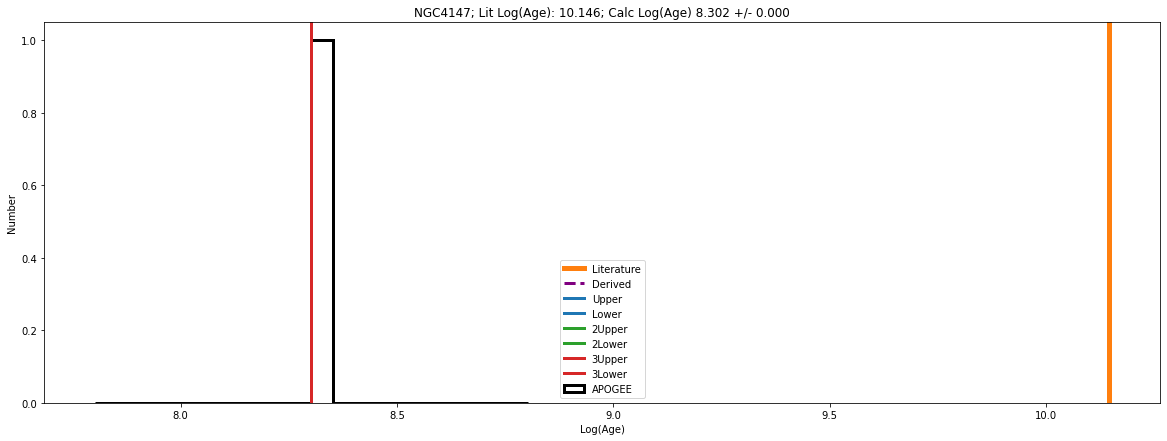

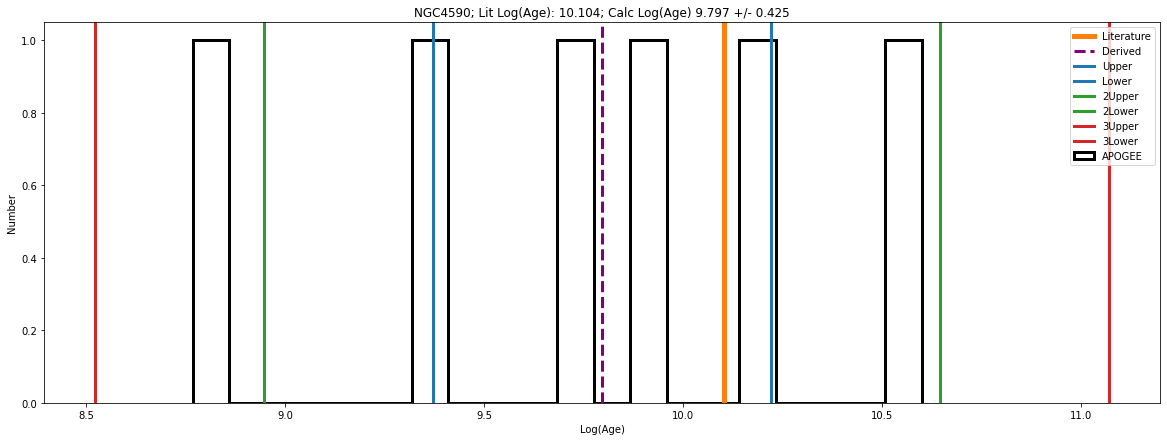

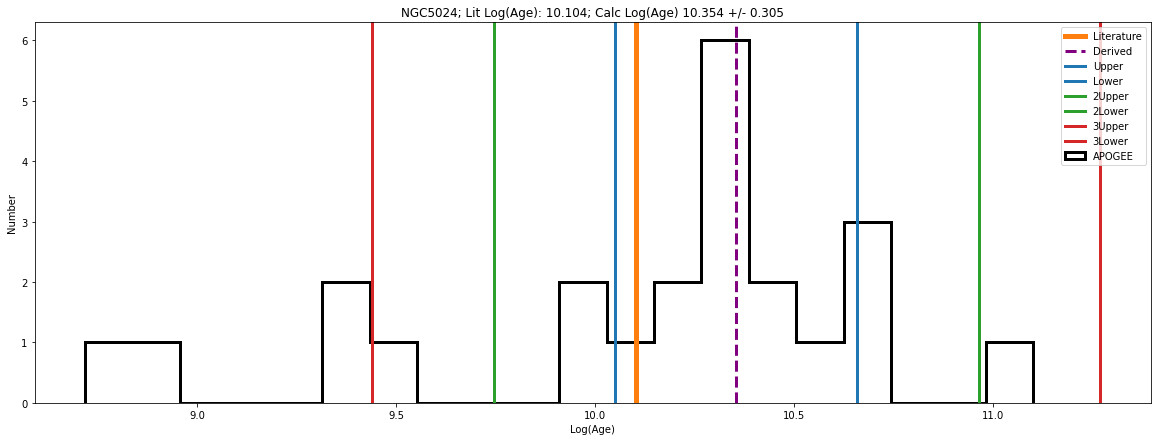

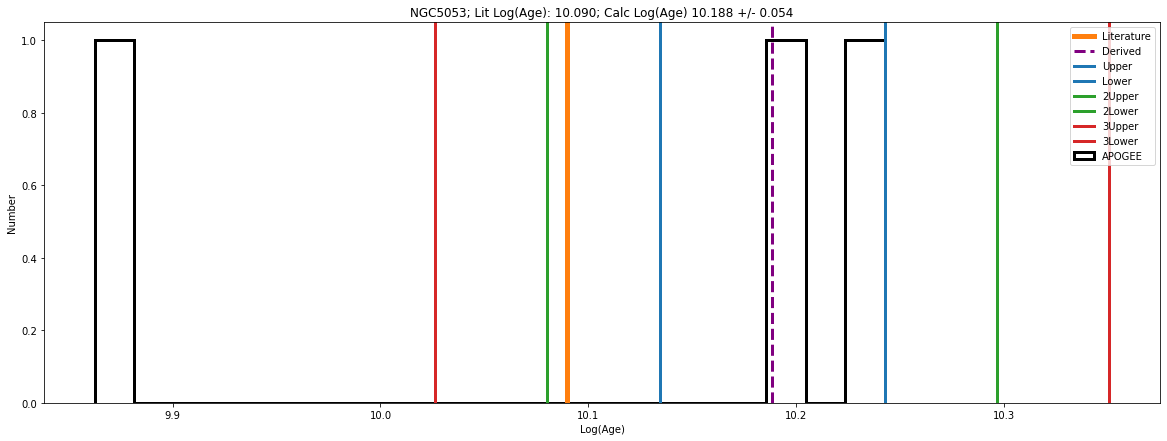

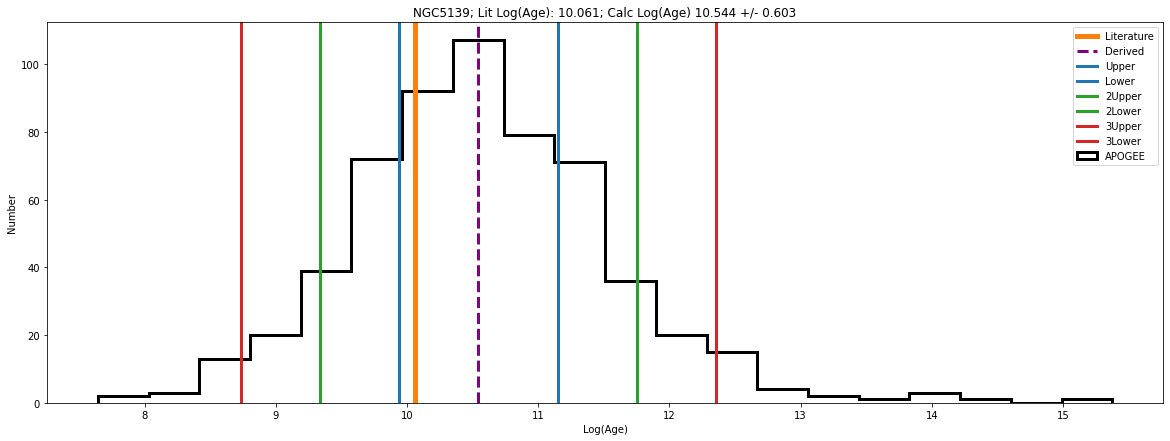

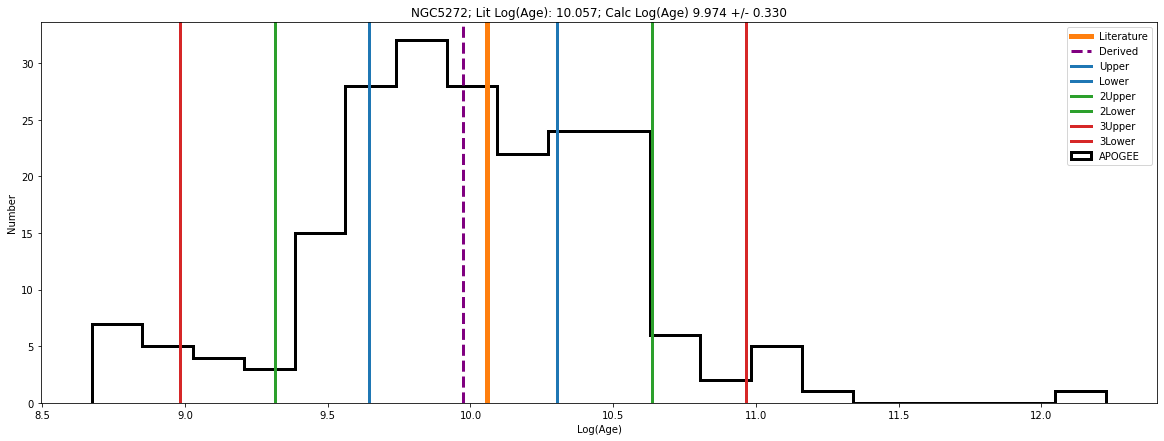

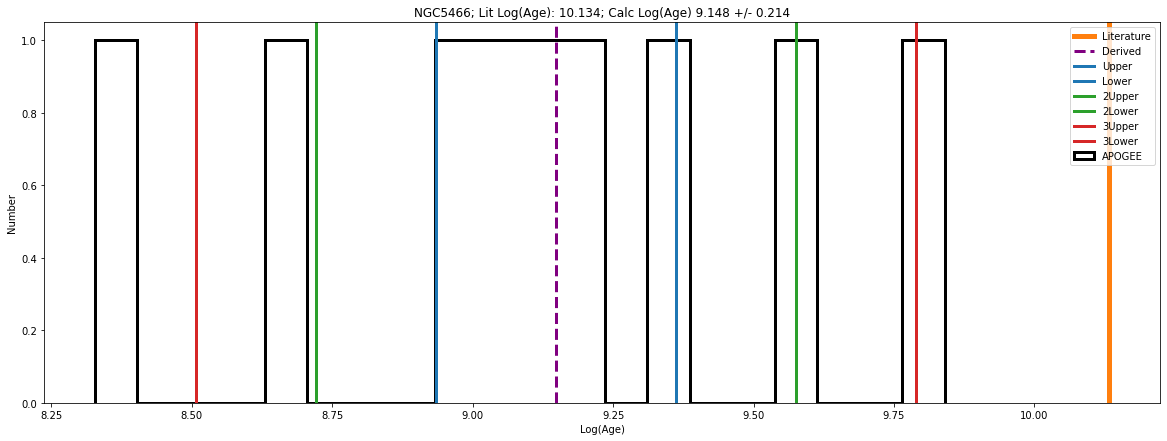

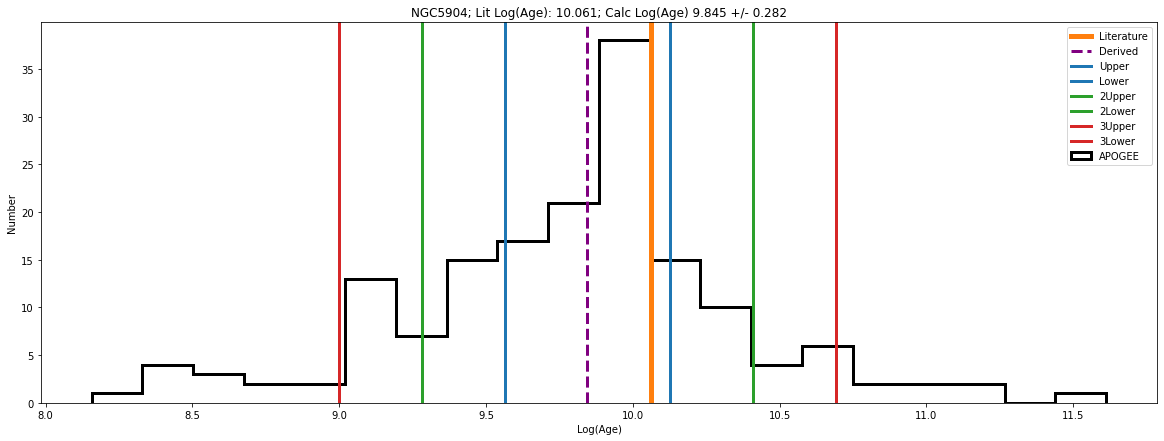

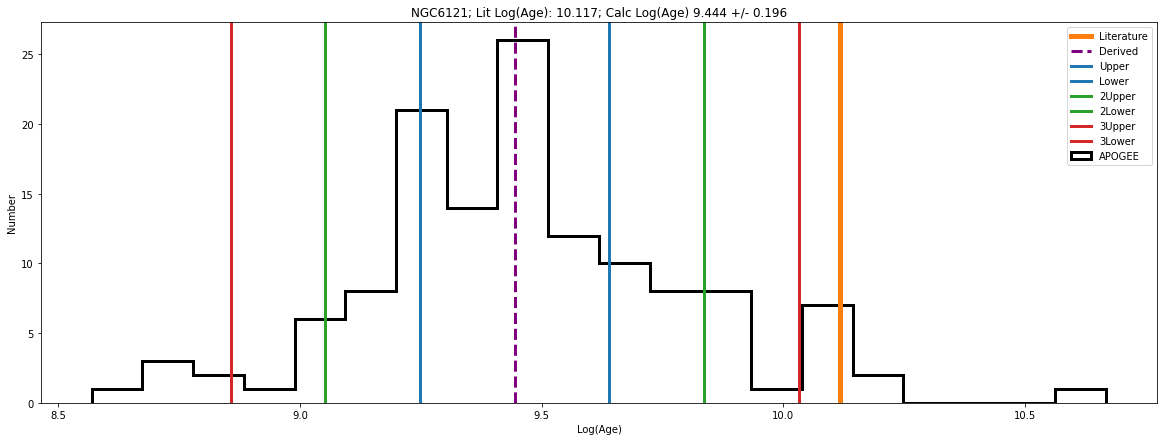

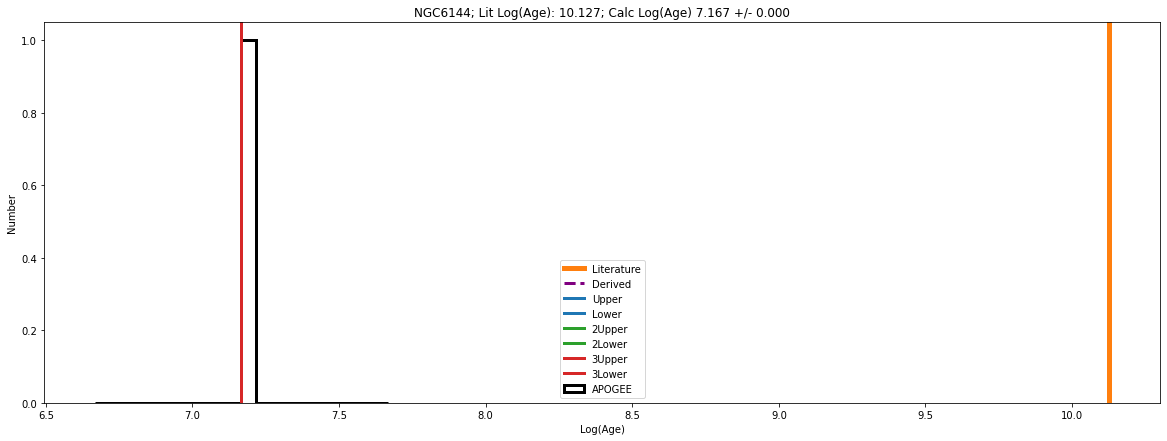

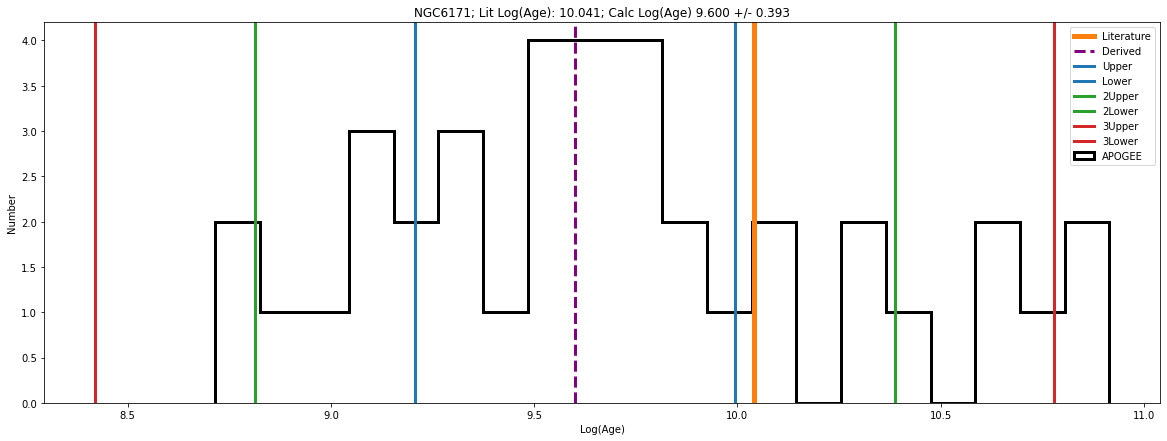

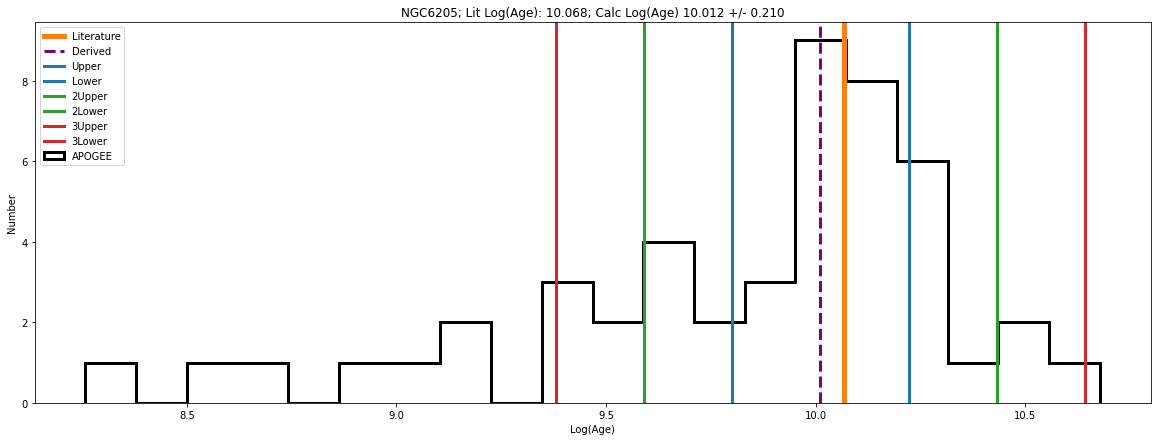

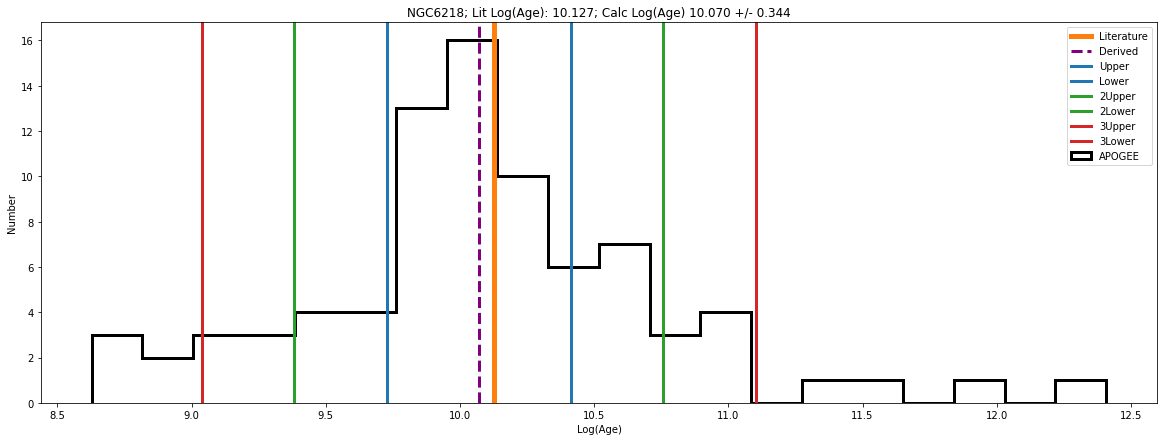

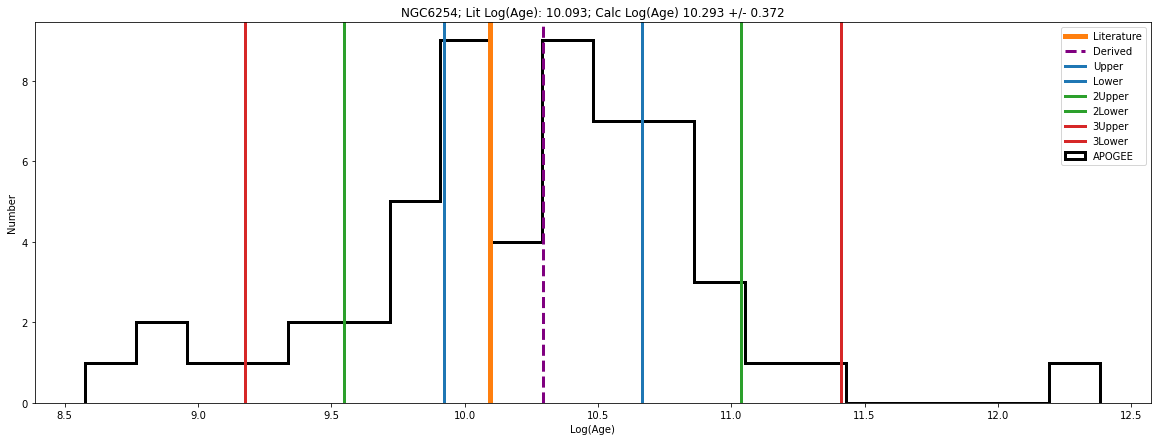

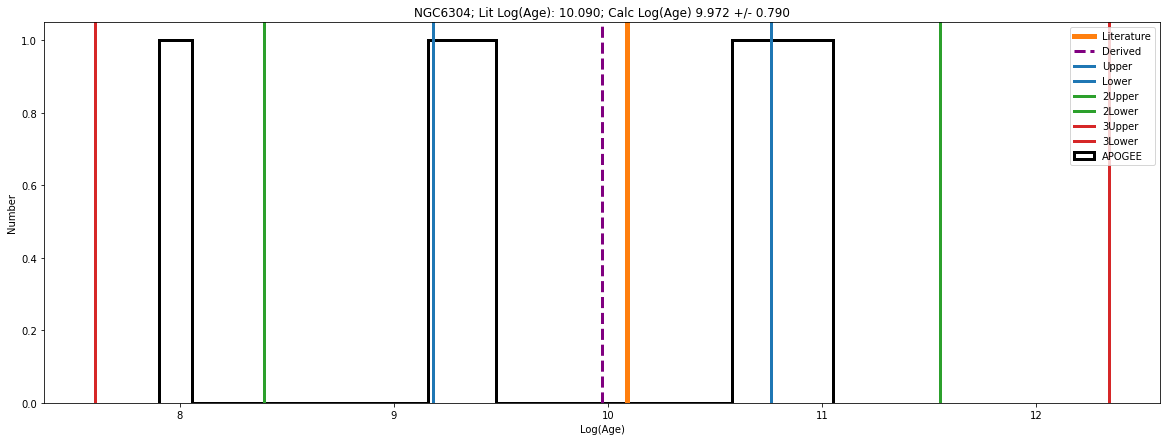

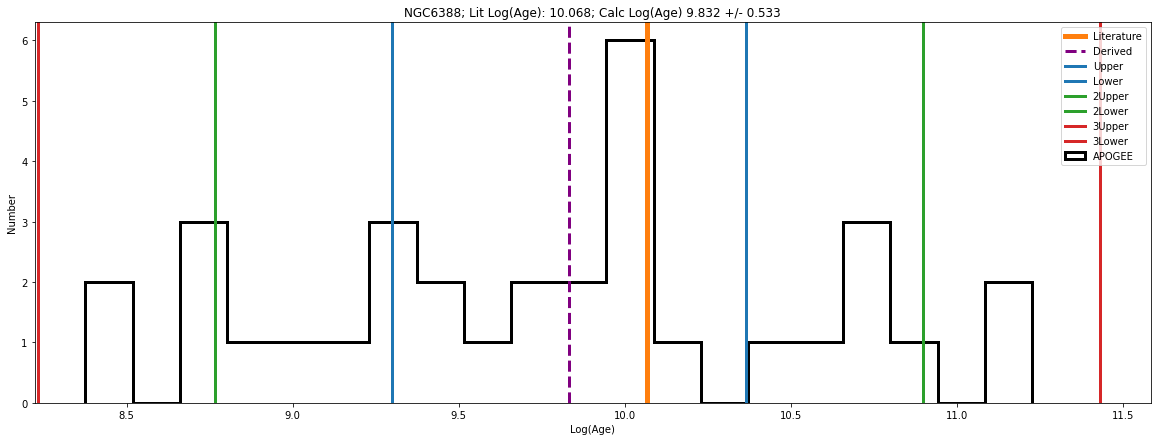

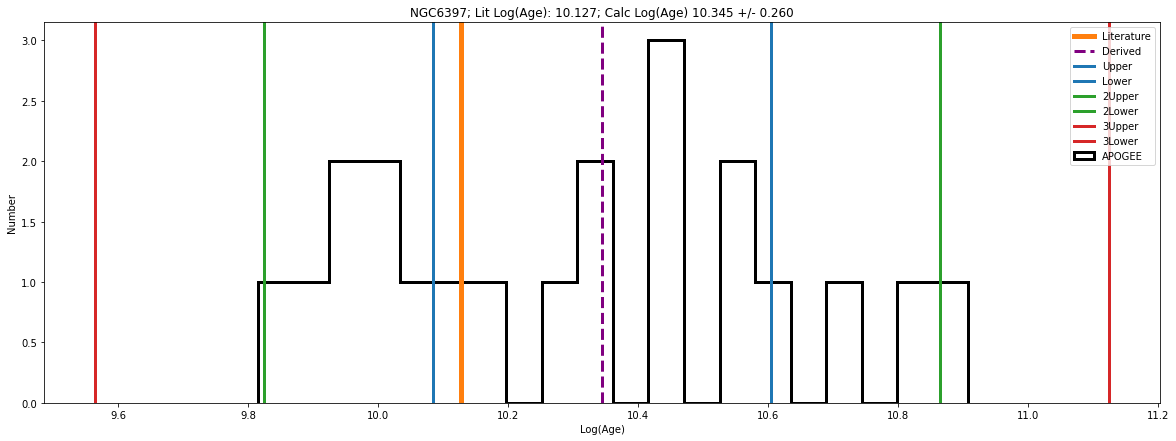

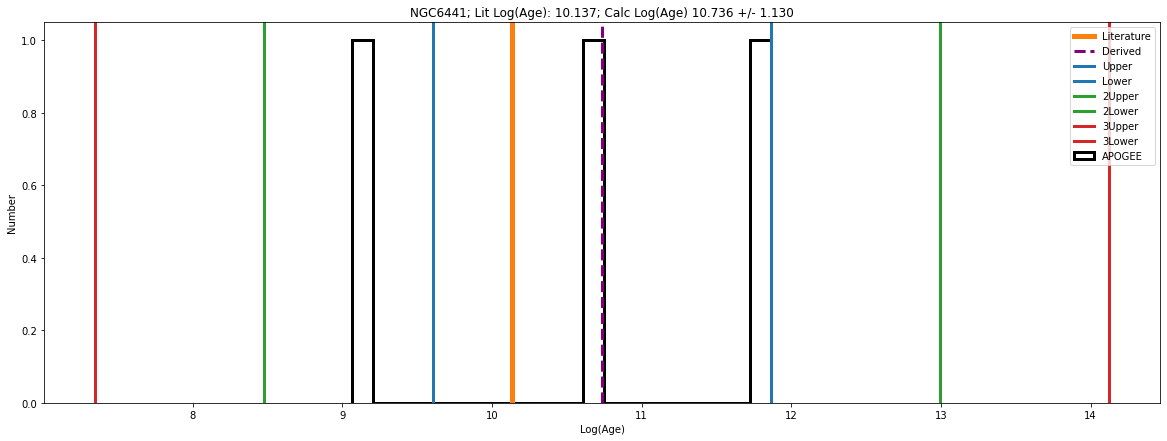

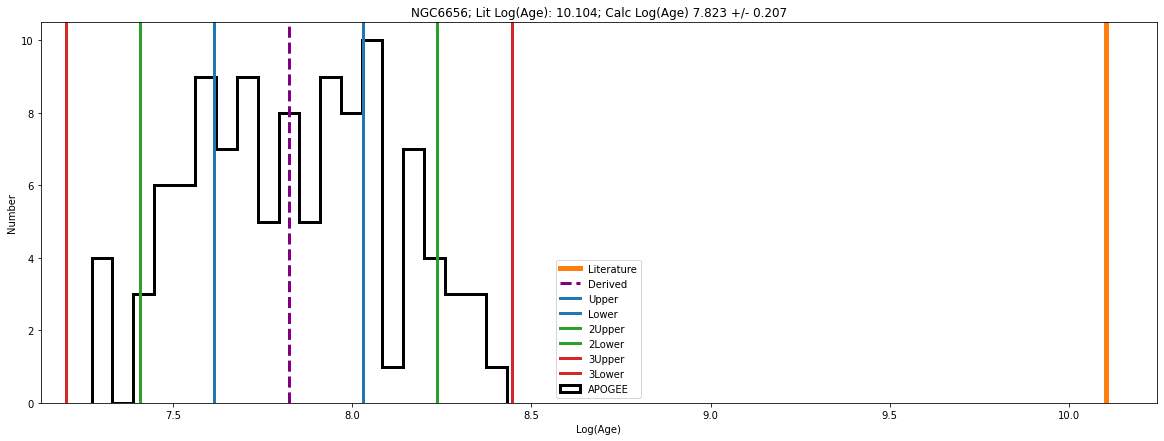

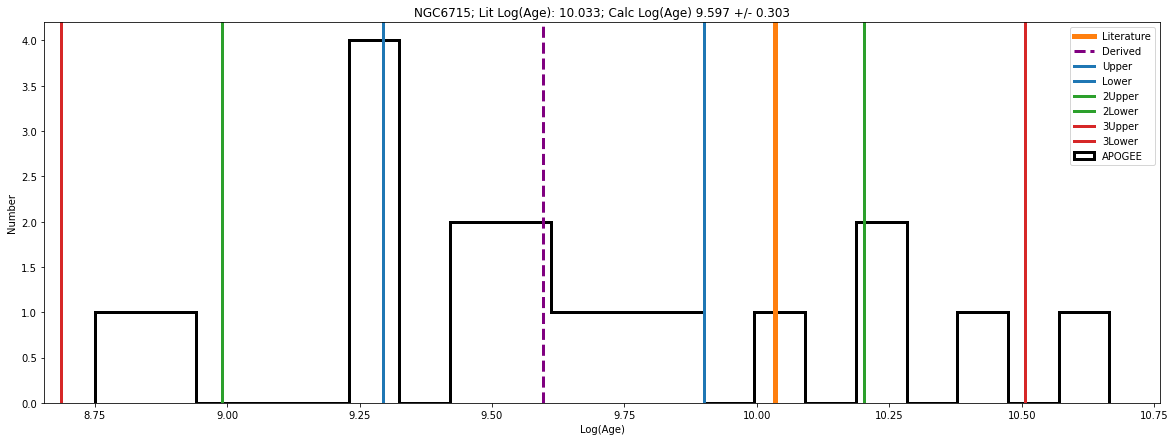

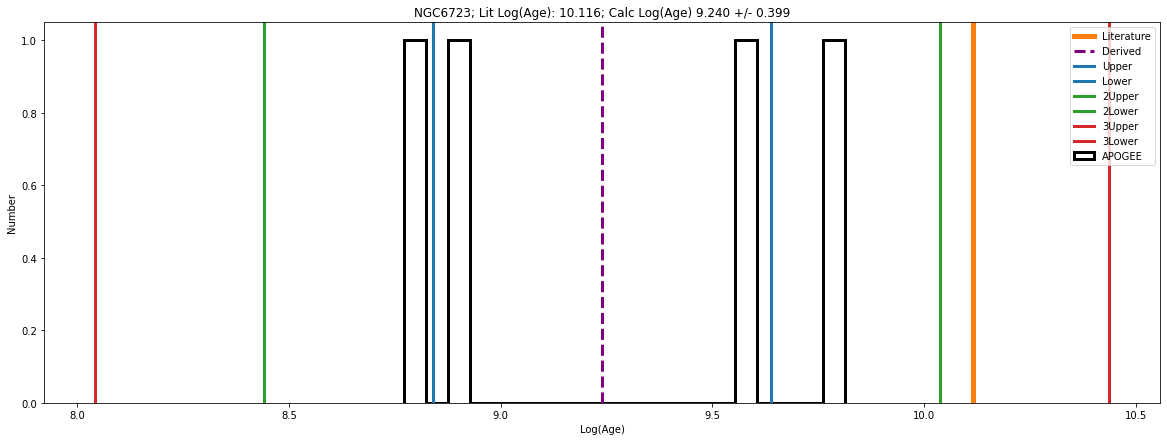

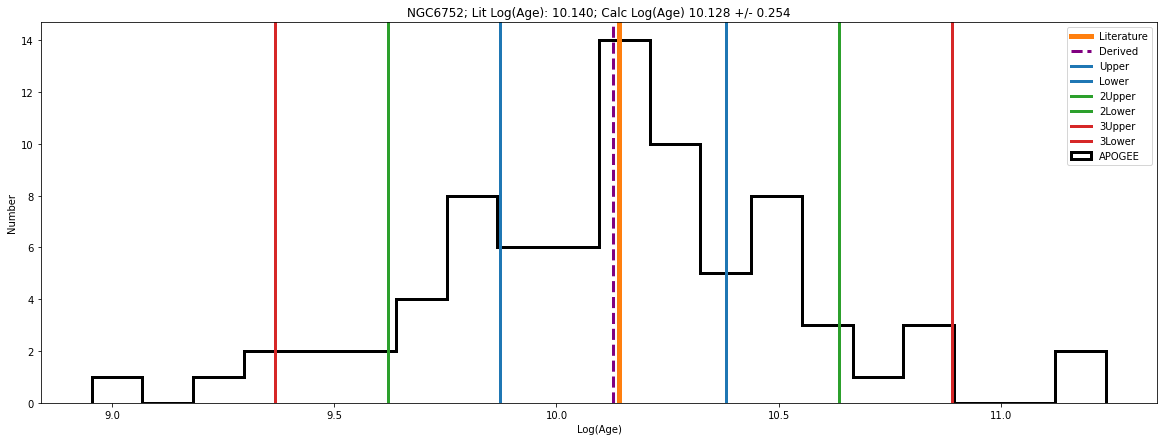

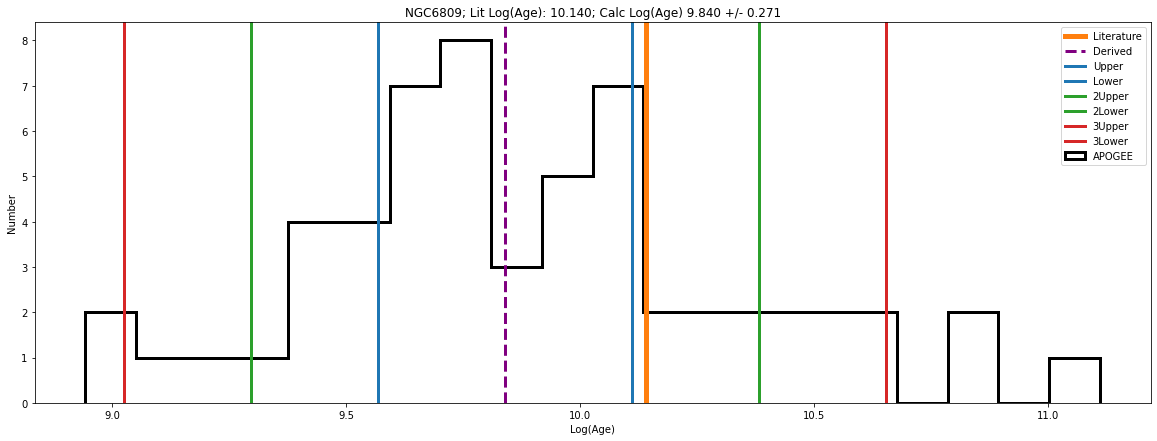

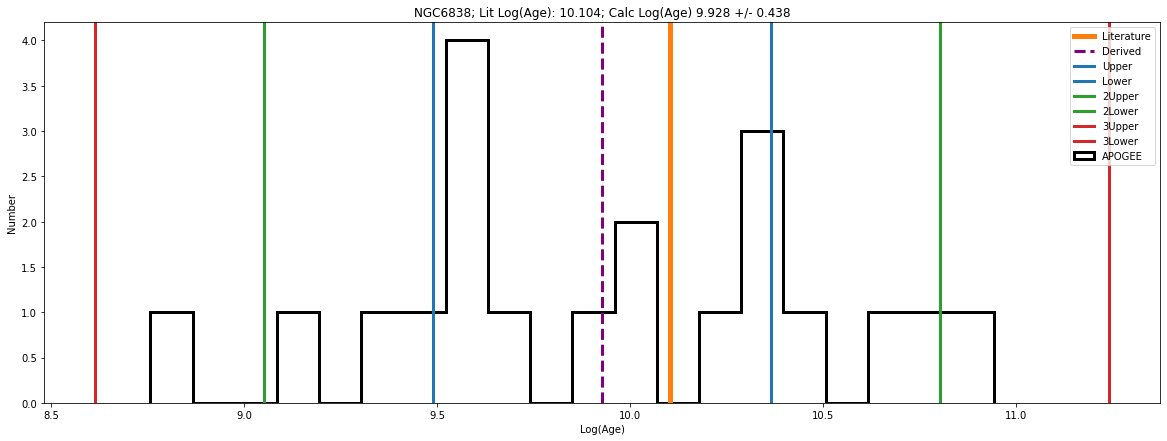

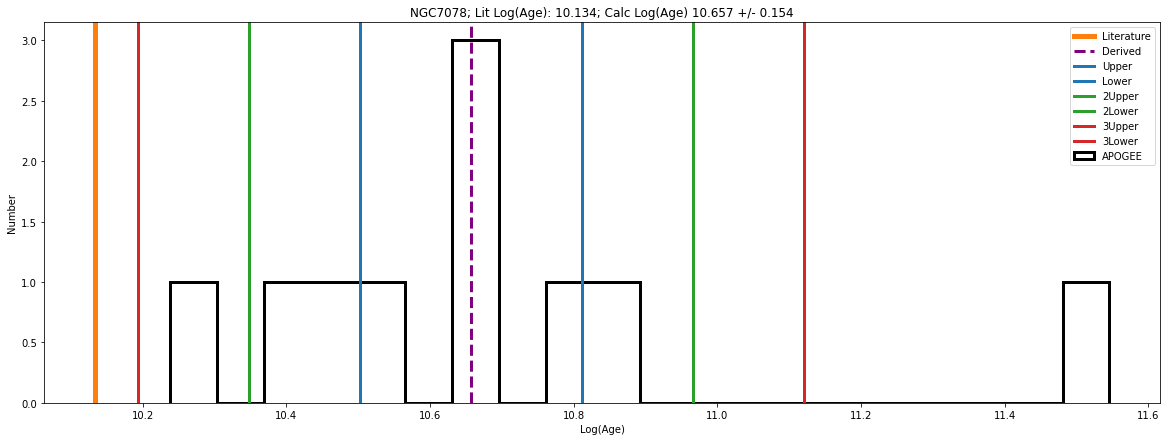

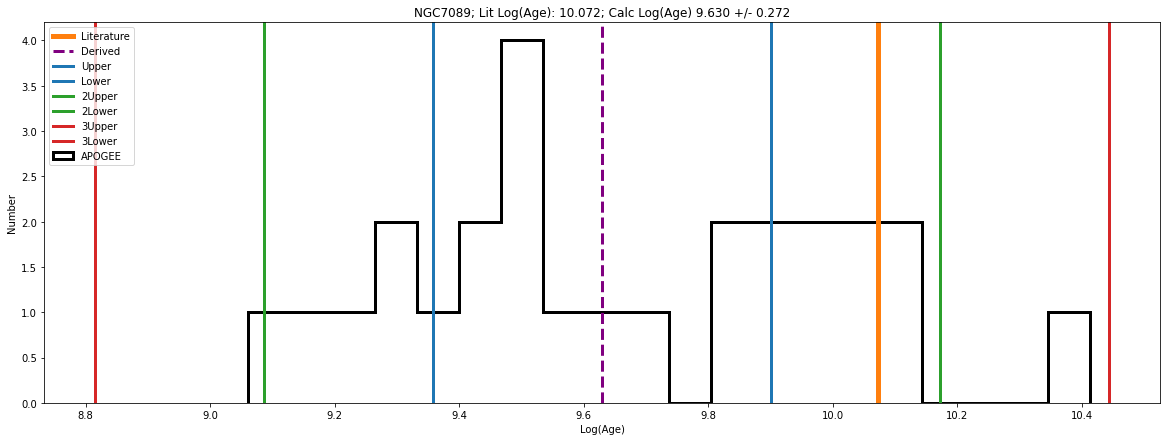

In [114]:
for i in range(len(np.squeeze(s2_ind))):
    clus_al = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
                                       (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind[i]])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind[i]])
    plt.figure(figsize=[20,7])
    
    ### Calculated Age Distribution
    plt.hist(parages_lit[clus],histtype='step',lw=3.0,bins=20,label='APOGEE',color='k')
#     plt.hist(parages_lit[clus_al],histtype='step',lw=3.0,bins=20,label='[Al/Fe]',color='lightgrey',ls='--')
    
    ### Literature Value
#     plt.axvline(np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]),c='tab:orange',label='Literature',lw=3.0)
    plt.axvline(log_xmatch_age[i],c='tab:orange',label='Literature',lw=5.0)
    
    ### Calculated Age With Different Sigmas
    plt.axvline(np.median(parages_lit[clus]),c='purple',ls='--',label='Derived',lw=3.0)
    plt.axvline(np.median(parages_lit[clus])+afunc.mad(parages_lit[clus]),c='tab:blue',label='Upper',lw=3.0)
    plt.axvline(np.median(parages_lit[clus])-afunc.mad(parages_lit[clus]),c='tab:blue',label='Lower',lw=3.0)
    plt.axvline(np.median(parages_lit[clus])+2.*afunc.mad(parages_lit[clus]),c='tab:green',label='2Upper',lw=3.0)
    plt.axvline(np.median(parages_lit[clus])-2.*afunc.mad(parages_lit[clus]),c='tab:green',label='2Lower',lw=3.0)
    plt.axvline(np.median(parages_lit[clus])+3.*afunc.mad(parages_lit[clus]),c='tab:red',label='3Upper',lw=3.0)
    plt.axvline(np.median(parages_lit[clus])-3.*afunc.mad(parages_lit[clus]),c='tab:red',label='3Lower',lw=3.0)
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind[i]],log_xmatch_age[i],
        np.median(parages_lit[clus]),afunc.mad(parages_lit[clus])))
    #np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]])
    plt.xlabel(r'Log(Age)')
    plt.ylabel(r'Number')
    plt.show()

In [115]:
# close_age_lit = []
# close_feh_lit = []
# for i in apogee_clus_idx:
#     use_age = np.median(parages_lit[i])
#     use_feh = np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i]))
    
#     close_age_lit.append(closest(use_age,parsec['logAge']))
#     close_feh_lit.append(closest(use_feh,parsec['MH']))
    
# supp2_close_age = []
# for j in supp2['Age'][s2_ind]:
#     supp2_close_age.append(closest(np.log10(j*(10**9)),parsec['logAge']))
    
close_age_lit = []
med_age_lit = []
close_feh_lit = []
med_feh_lit = []
for i in apogee_clus_idx2:
    use_age = np.median(parages_lit[i])
    med_age_lit.append(np.median(parages_lit[i]))
    use_feh = np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i]))
    med_feh_lit.append(np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i])))
    
    close_age_lit.append(closest(use_age,parsec['logAge']))
    close_feh_lit.append(closest(use_feh,parsec['MH']))
    
supp2_close_age_lit = []
for i in range(len(log_xmatch_age)):
    supp2_close_age_lit.append(closest(np.asarray(log_xmatch_age)[i],parsec['logAge']))

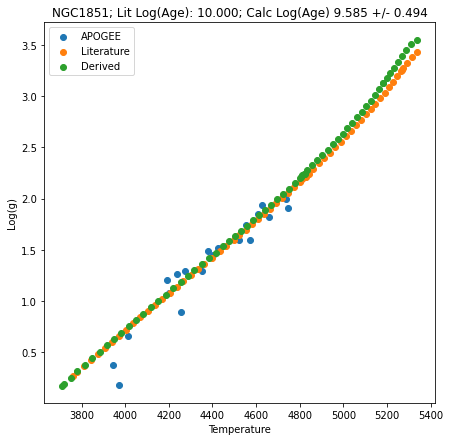

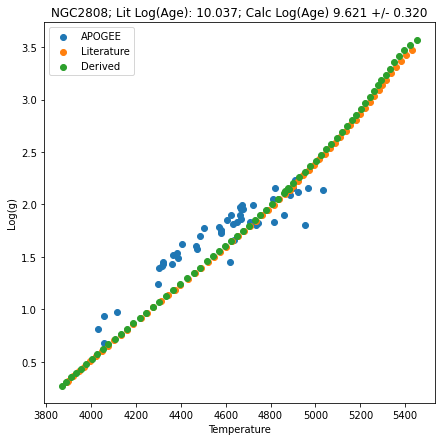

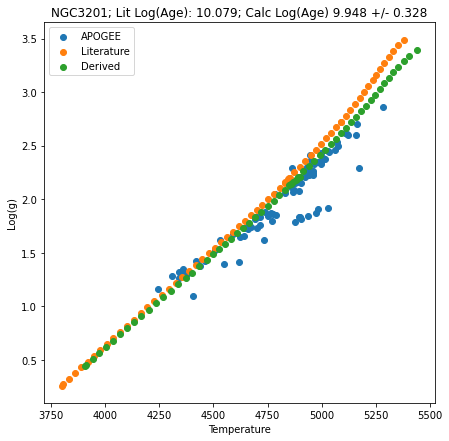

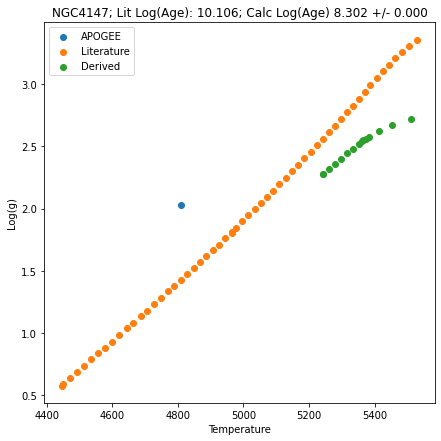

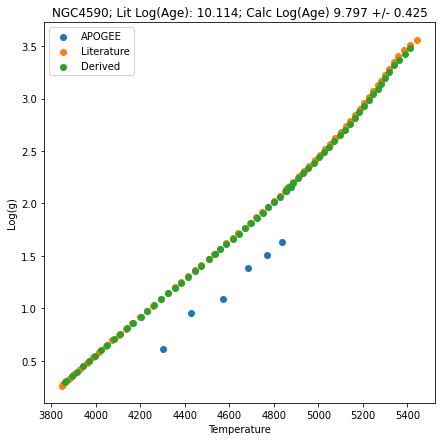

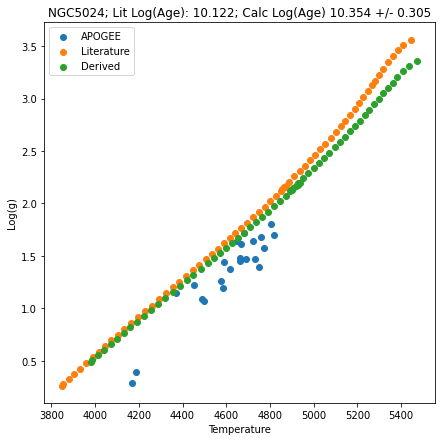

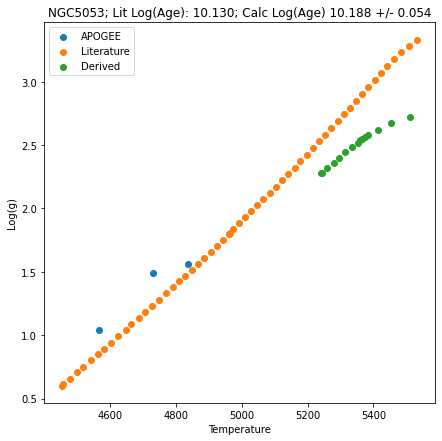

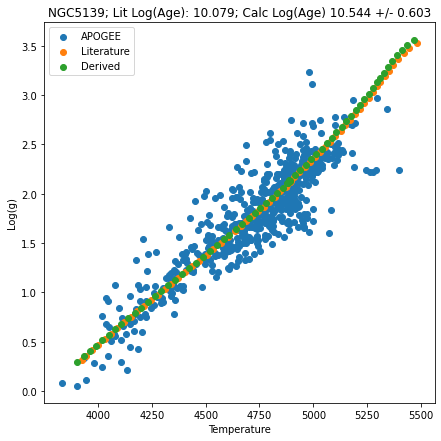

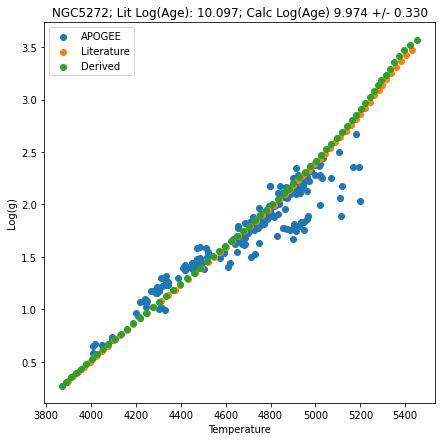

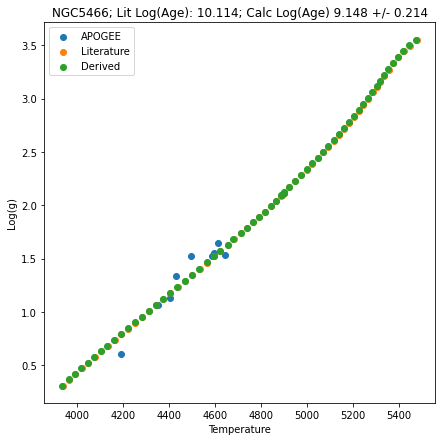

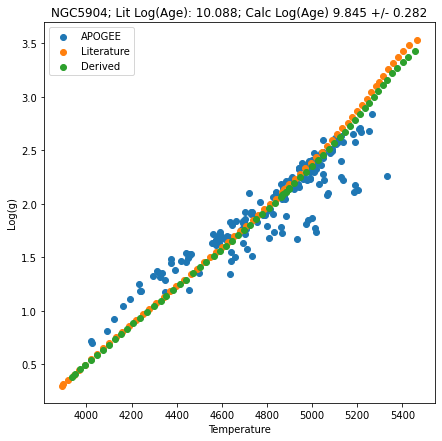

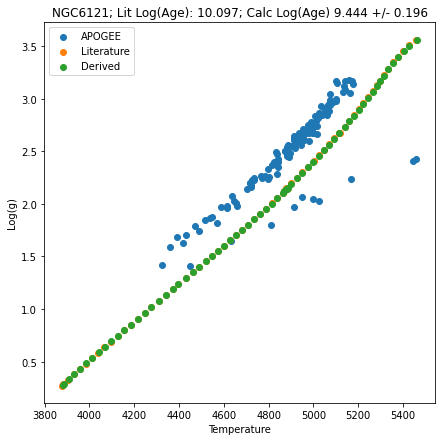

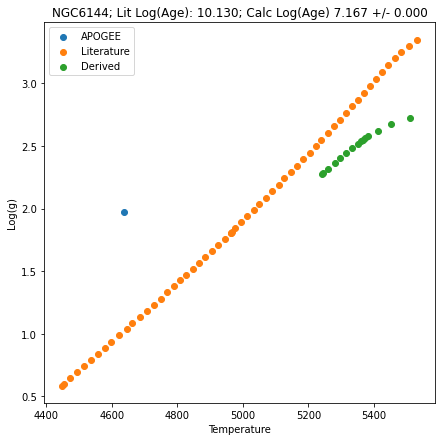

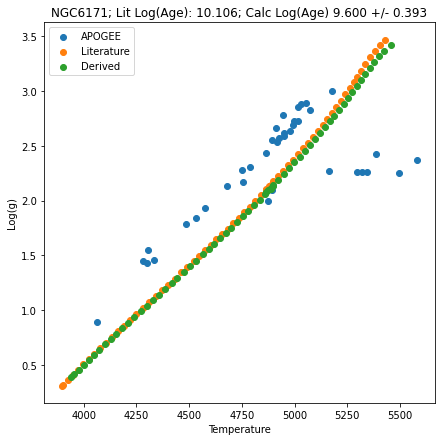

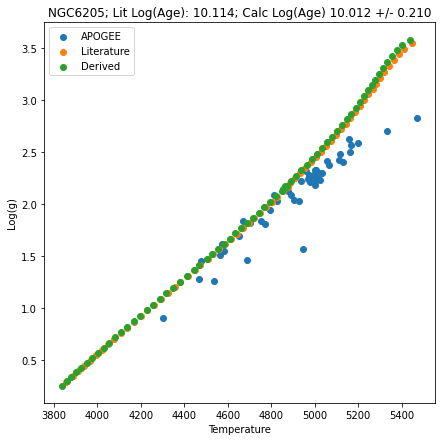

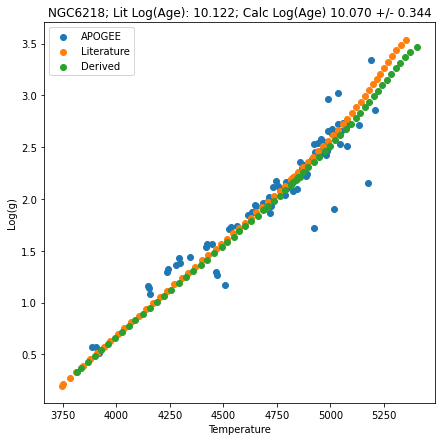

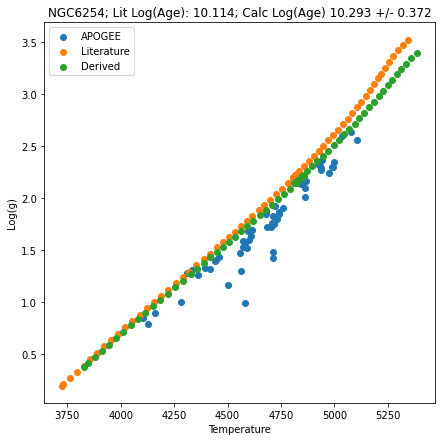

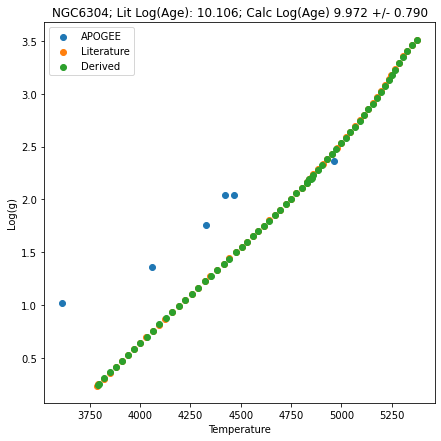

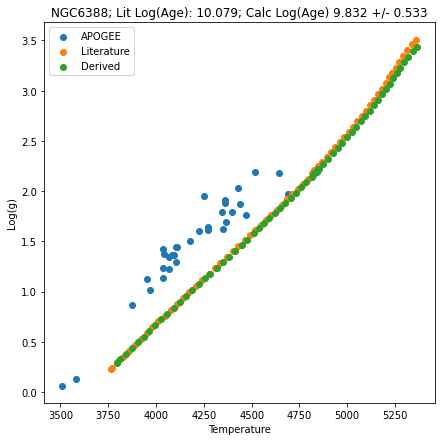

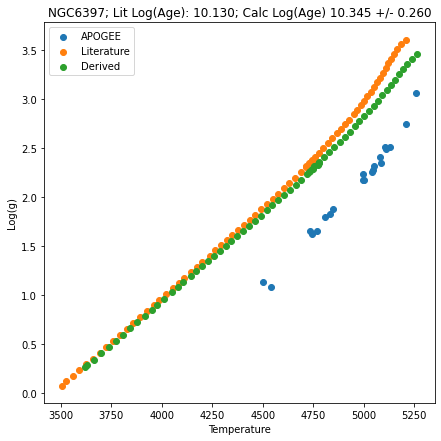

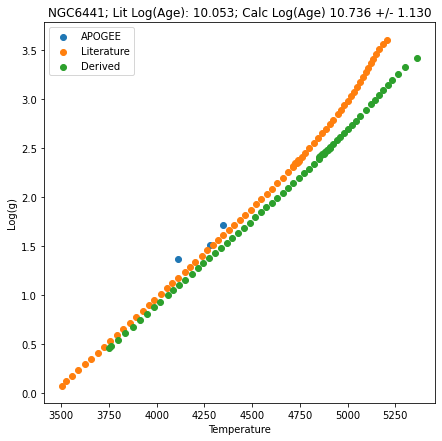

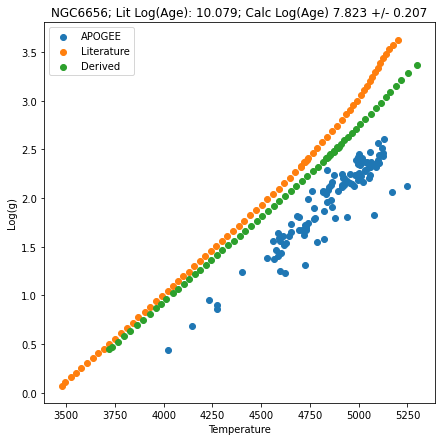

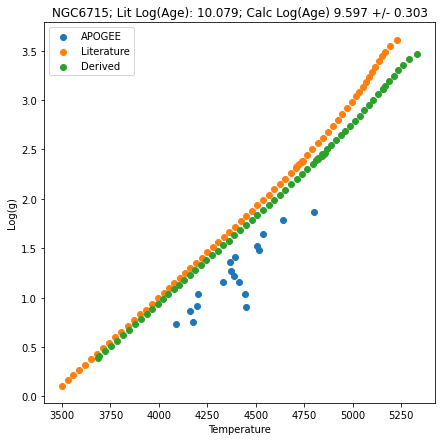

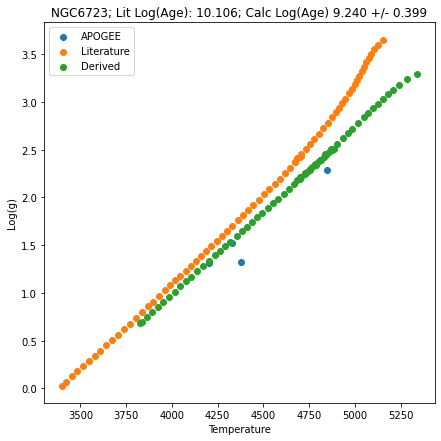

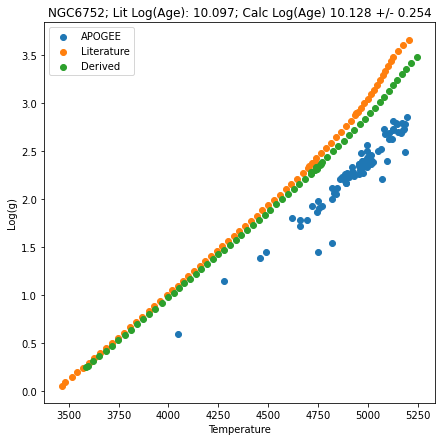

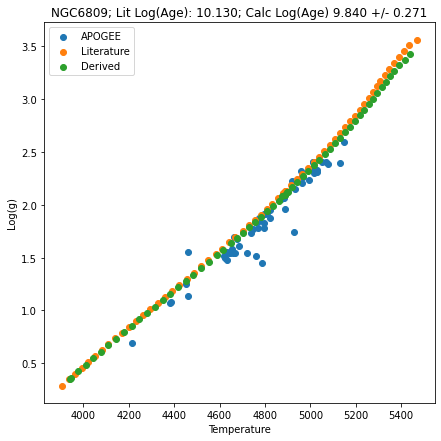

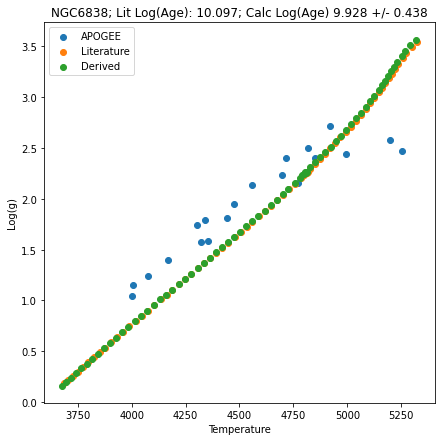

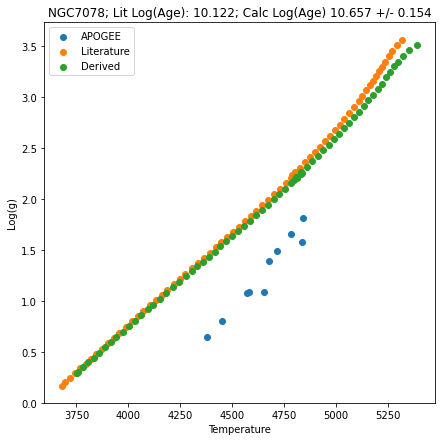

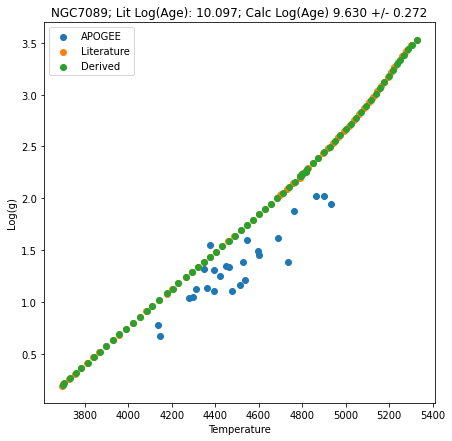

In [120]:
# derived = [] 
# derived_err = []
# lits = []
# for i in range(len(np.squeeze(s2_ind))):
#     plt.figure(figsize=[7,7])
#     clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
#                                        (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
#     theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
#     pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
#     plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
#     plt.scatter(10**parsec['logTe'][theo],parsec['logg'][theo],label='Literature')
#     plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Derived')
    
#     plt.legend()
    
#     plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
#         np.asarray(supp2['Cluster'])[s2_ind][i],log_xmatch_age[i],
#         np.median(parages[clus]),afunc.mad(parages[clus])))
#     #np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]])
#     derived.append(np.median(parages[clus]))
#     derived_err.append(afunc.mad(parages[clus]))
#     lits.append(log_xmatch_age[i])
# #     lits.append(np.log10(np.asarray(supp2['Age']*10**9)[s2_ind[i]]))
# #     lits.append(np.log10(np.asarray(clus_ages)[s2_ind][i]*10**9))
    
#     plt.xlabel(r'Temperature')
#     plt.ylabel(r'Log(g)')
#     plt.show()

derived_lit = [] 
derived_lit_err = []

for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh_lit[i]))
    pred = np.where((parsec['logAge']==close_age_lit[i])&(parsec['MH']==close_feh_lit[i]))
    
    plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
    plt.scatter(10**parsec['logTe'][theo],parsec['logg'][theo],label='Literature')
    plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Derived')
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age'])[s2_ind][i]*10**9),
        np.median(parages_lit[clus]),afunc.mad(parages_lit[clus])))
    
    derived_lit.append(np.median(parages_lit[clus]))
    derived_lit_err.append(afunc.mad(parages_lit[clus]))
    
    plt.xlabel(r'Temperature')
    plt.ylabel(r'Log(g)')
    plt.show()

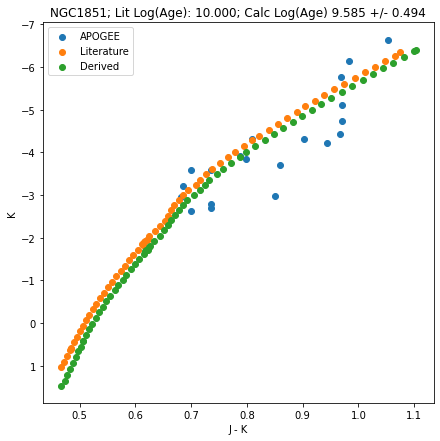

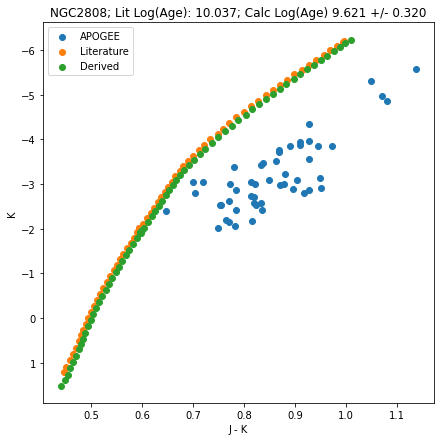

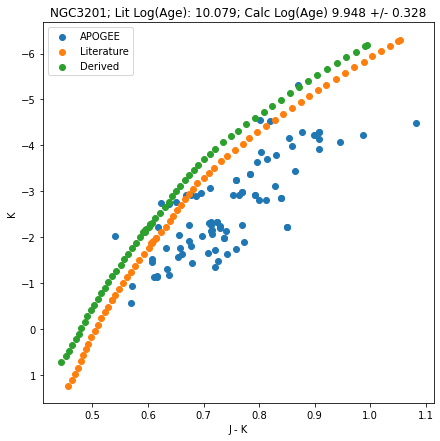

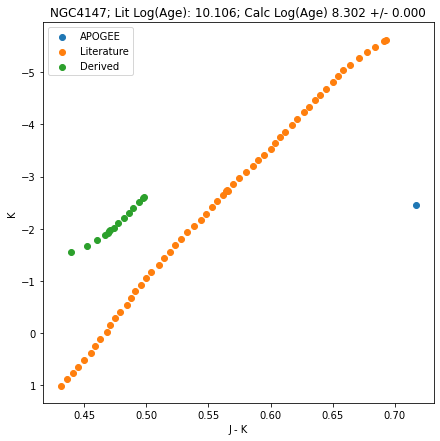

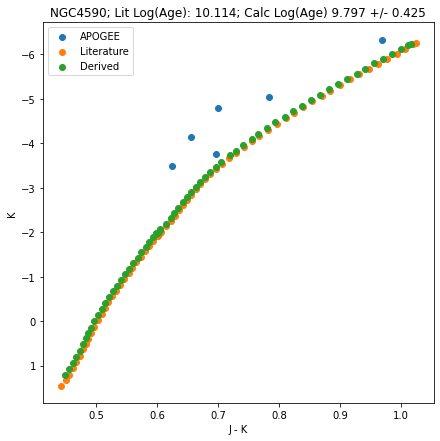

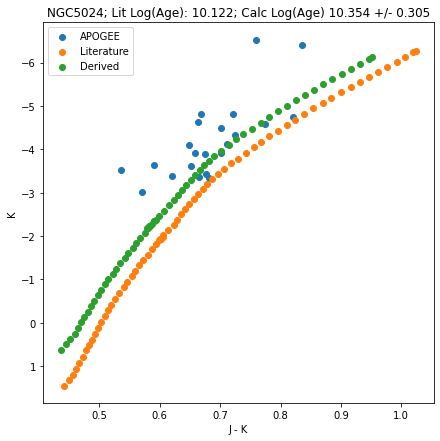

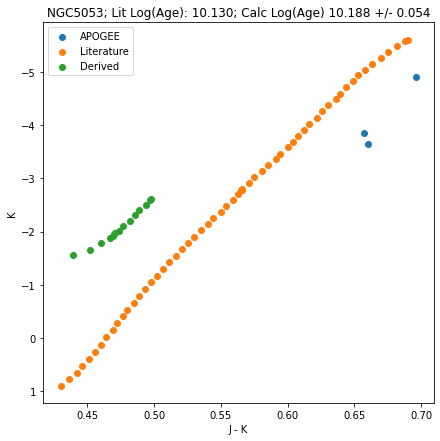

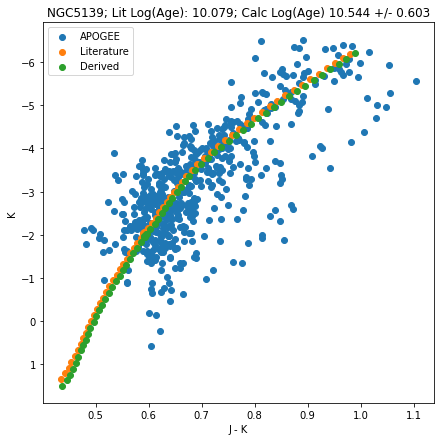

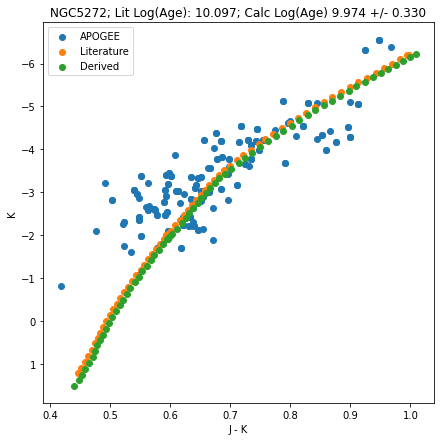

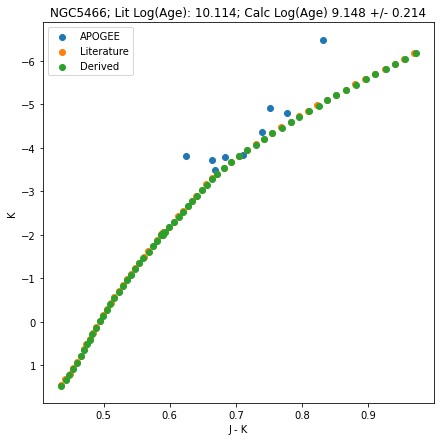

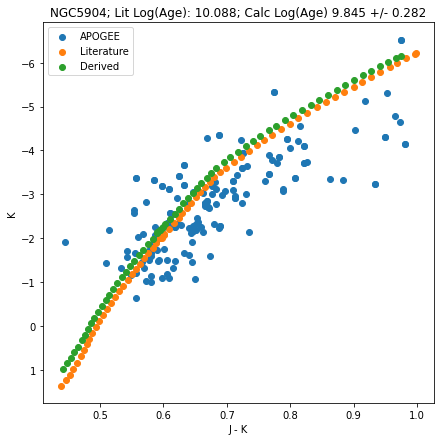

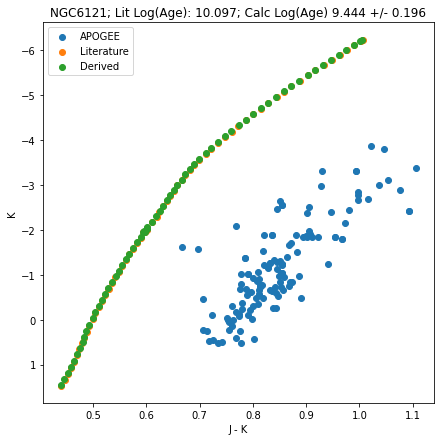

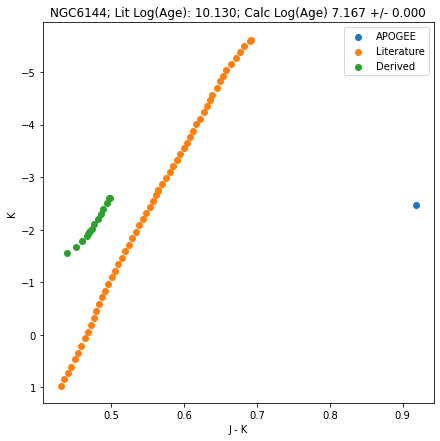

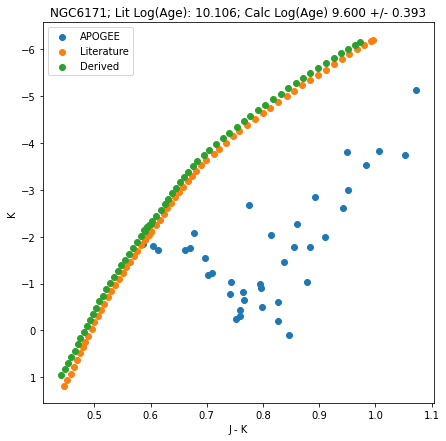

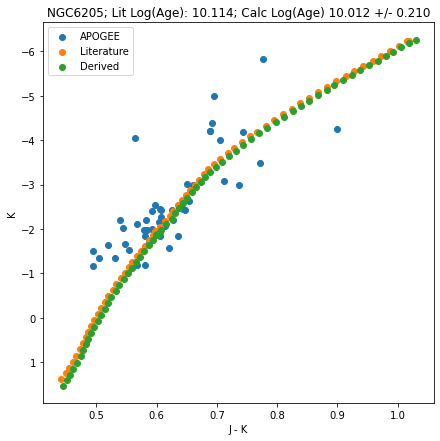

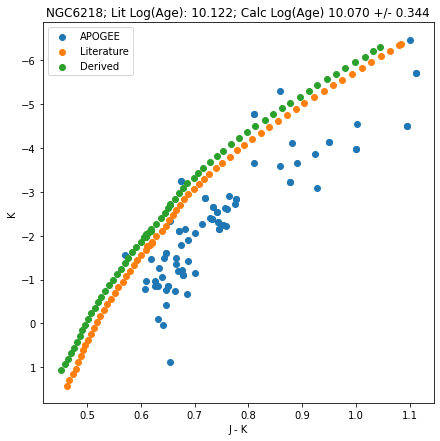

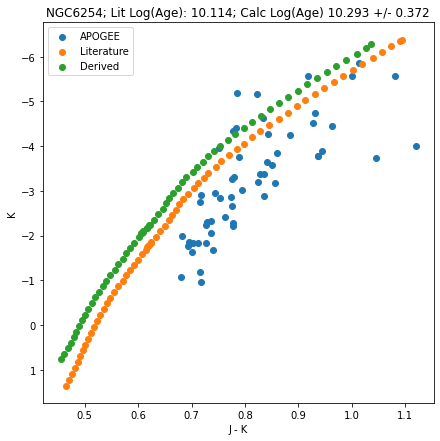

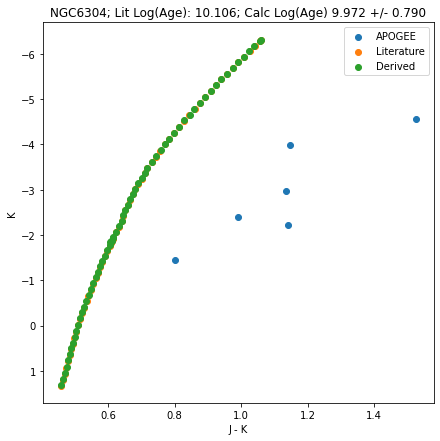

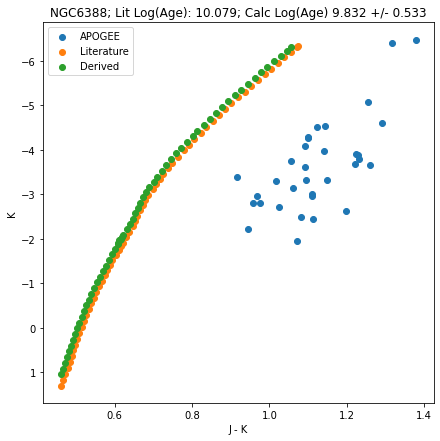

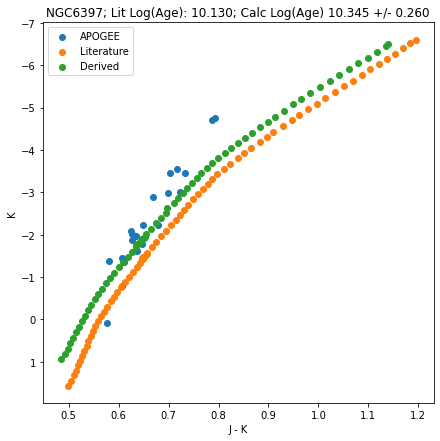

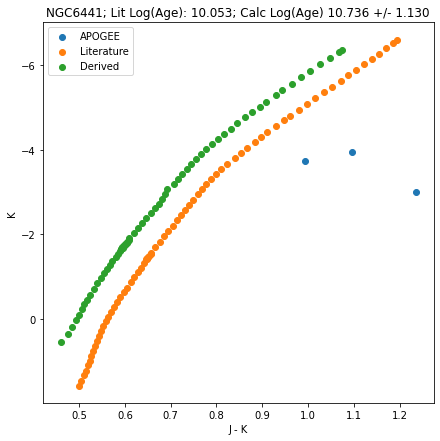

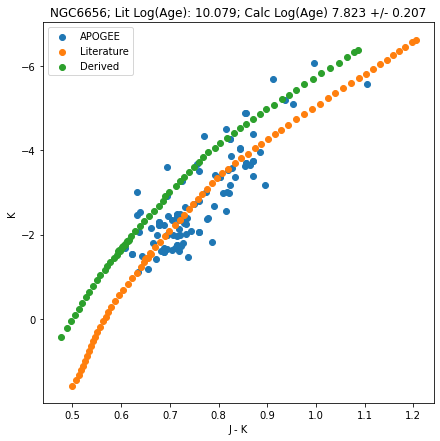

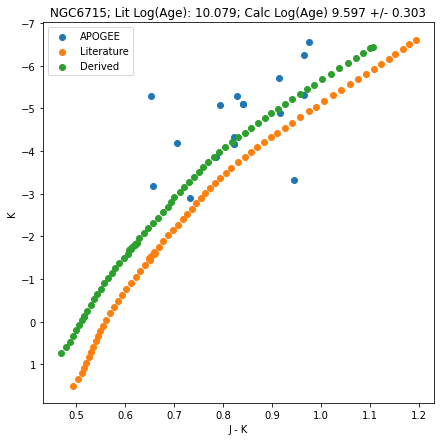

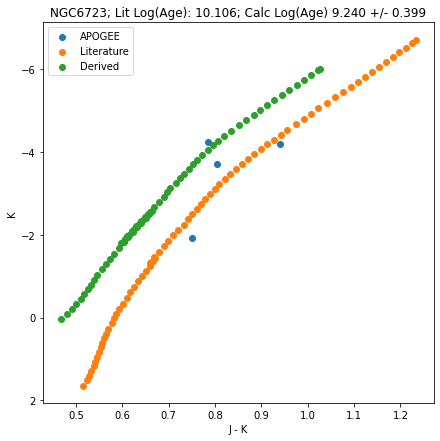

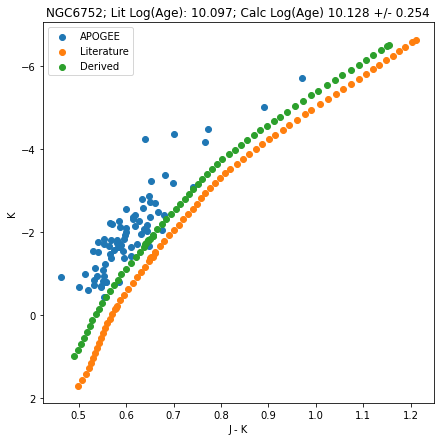

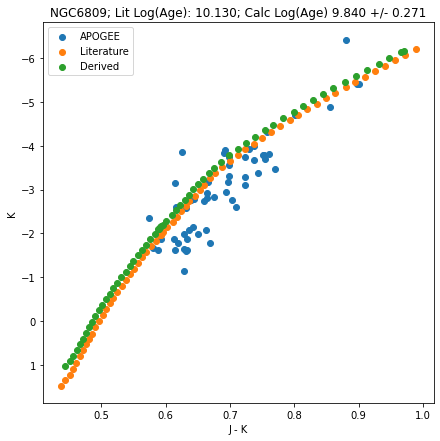

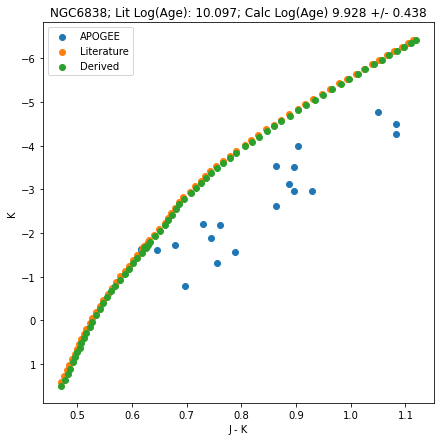

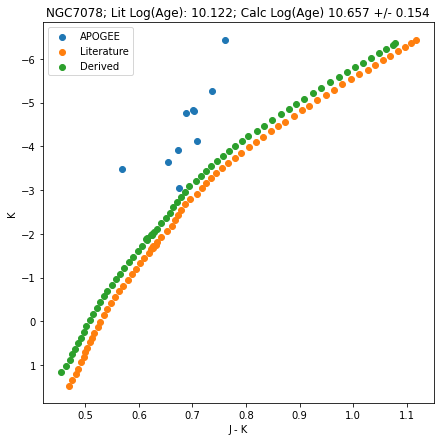

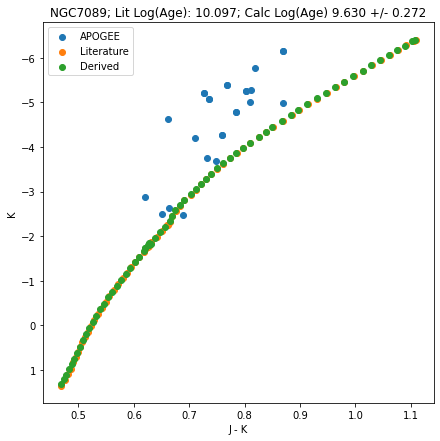

In [119]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh_lit[i]))
    pred = np.where((parsec['logAge']==close_age_lit[i])&(parsec['MH']==close_feh_lit[i]))
    
    plt.scatter((gcs['J']-gcs['K'])[clus],gcs_ksmag[clus],label='APOGEE')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[theo],parsec['Ksmag'][theo],label='Literature')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[pred],parsec['Ksmag'][pred],label='Derived')
    
    plt.legend()
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age'])[s2_ind][i]*10**9),
        np.median(parages_lit[clus]),afunc.mad(parages_lit[clus])))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

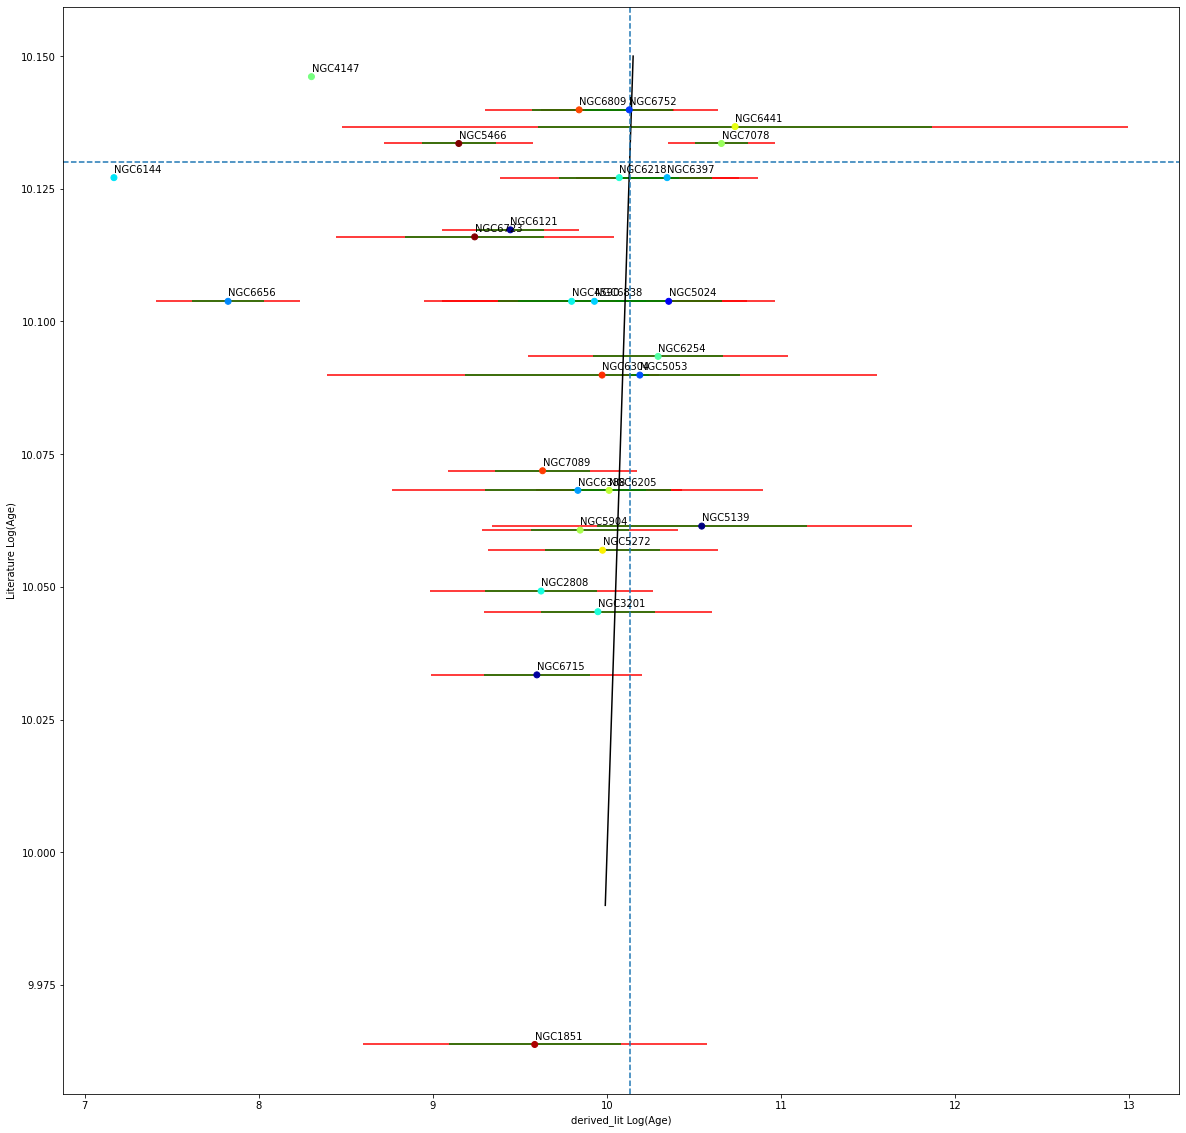

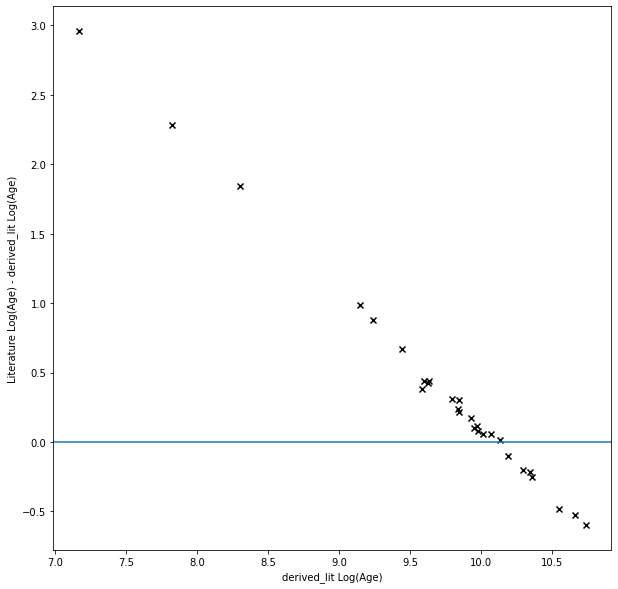

In [121]:
fin = np.where((np.isfinite(derived_lit)==True)&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))

plt.figure(figsize=[20,20])
plt.errorbar(np.asarray(derived_lit)[fin],np.asarray(lits)[fin],xerr=np.asarray(derived_lit_err)[fin],
             ls='none',c='green',zorder=2)
plt.errorbar(np.asarray(derived_lit)[fin],np.asarray(lits)[fin],xerr=2.*np.asarray(derived_lit_err)[fin],
             ls='none',c='red',zorder=1)
plt.scatter(np.asarray(derived_lit)[fin],np.asarray(lits)[fin],c=np.random.random(len(derived_lit))[fin],
            zorder=3,cmap='jet')
plt.plot([9.99,10.15],[9.99,10.15],c='k')

for i in range(len(np.asarray(derived_lit)[fin])):
    plt.text(np.asarray(derived_lit)[fin][i]*(1.+0.0001),np.asarray(lits)[fin][i]*(1.+0.0001),
             '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(10.13,c='tab:blue',ls='--')
plt.axvline(10.13,c='tab:blue',ls='--')

plt.xlabel('derived_lit Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()

###
plt.figure(figsize=[10,10])
plt.scatter(x=np.asarray(derived_lit)[fin],y=np.subtract(lits,derived_lit)[fin],c='k',marker='x')
plt.axhline(0.0)

plt.xlabel('derived_lit Log(Age)')
plt.ylabel('Literature Log(Age) - derived_lit Log(Age)')
plt.show()

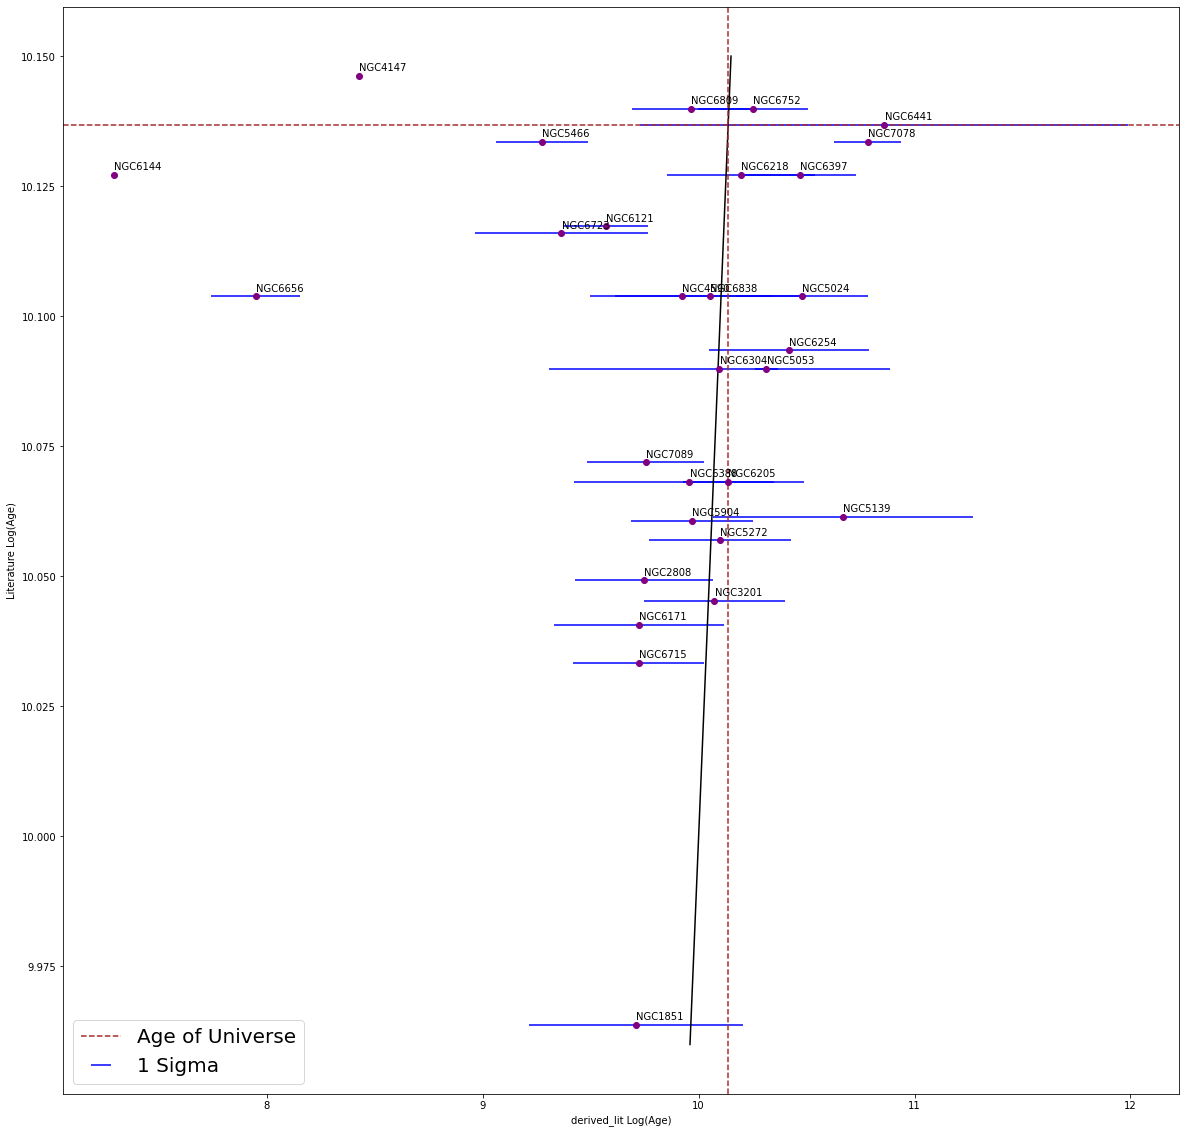

In [122]:
fin = np.where((np.isfinite(derived_lit)==True))#&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))
shift = 0.125

plt.figure(figsize=[20,20])

plt.errorbar(np.asarray(derived_lit)[fin]+shift,log_xmatch_age[fin],xerr=np.asarray(derived_lit_err)[fin],
             ls='none',c='blue',zorder=2,label='1 Sigma')
# plt.errorbar(np.asarray(derived_lit)[fin]+shift,log_xmatch_age[fin],xerr=2.*np.asarray(derived_lit_err)[fin],
#              ls='none',c='green',zorder=1,label='2 Sigma')
plt.scatter(np.asarray(derived_lit)[fin]+shift,log_xmatch_age[fin],c='purple', zorder=3,cmap='jet') 
#c=np.random.random(len(derived_lit))[fin]
plt.plot([9.96,10.15],[9.96,10.15],c='k')

# plt.plot(np.linspace(9.8,10.,10),np.linspace(9.8,10.,10)+0.15,c='r')

for i in range(len(np.asarray(derived_lit)[fin])):
    plt.text(np.asarray(derived_lit)[fin][i]*(1.+0.0001)+shift,log_xmatch_age[fin][i]*(1.+0.0001),
             '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(10.136720567156408,c='brown',ls='--',label='Age of Universe')
plt.axvline(10.136720567156408,c='brown',ls='--')

plt.legend(loc='lower left',prop={'size': 20})

plt.xlabel('derived_lit Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()